In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro

from flowjax.flows import BlockNeuralAutoregressiveFlow
from flowjax.bijections import (
    BlockAutoregressiveNetwork,
    Invert,
    Chain,
    Affine,
    Exp,
    Tanh,
    LeakyTanh,
    OnePlusELU,
    )
from flowjax.distributions import Normal, Transformed
from flowjax.train import fit_to_data

In [2]:
np.random.seed(0)

In [3]:
data = np.load('/home/ADF/mdm988/Downloads/posteriors.pkl', allow_pickle=True)
true = np.array([p.attrs['injection_parameters']['chirp_mass'] for p in data])
posteriors = [np.array(p['chirp_mass']) for p in data]
n = min(p.size for p in posteriors)

x = np.array([np.random.choice(p, n, replace=False) for p in posteriors])
c = np.repeat(true[:, None], x.shape[1], axis=1)

In [4]:
x.shape, c.shape

((100, 462), (100, 462))

In [5]:
x, c = map(
    lambda z: jnp.array(np.concatenate(z)[:, None]),
    (x, c),
    )

I0000 00:00:1696534548.278183   29015 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
x.shape, c.shape

((46200, 1), (46200, 1))

In [7]:
dim = x.shape[1]
cond_dim = c.shape[1]

In [8]:
key = jax.random.PRNGKey(0)

In [9]:
key, key_ = jax.random.split(key)

base = Normal(
    loc=jnp.zeros(dim),
    scale=jnp.ones(dim),
    )

flow = BlockNeuralAutoregressiveFlow(
    key=key_,
    base_dist=base,
    cond_dim=cond_dim,
    nn_depth=1,
    nn_block_dim=10,
    flow_layers=1,
    invert=True,
    # activation=,
    )

preprocess = Invert(OnePlusELU(shape=(1,)))

In [11]:
key, key_ = jax.random.split(key)
flow, losses = fit_to_data(
    key=key_,
    dist=flow,
    # x=x,
    x=jax.vmap(preprocess.transform)(x),
    condition=c,
    loss_fn=None,
    max_epochs=1_000,
    max_patience=10,
    batch_size=1_000,
    val_prop=0.1,
    learning_rate=1e-3,
    optimizer=None,
    # filter_spec: Callable | PyTree = eqx.is_inexact_array,
    show_progress=True,
    )

 14%|▍  | 140/1000 [00:36<03:45,  3.81it/s, train=-2.0107827, val=-2.0135396 (Max patience reached)]


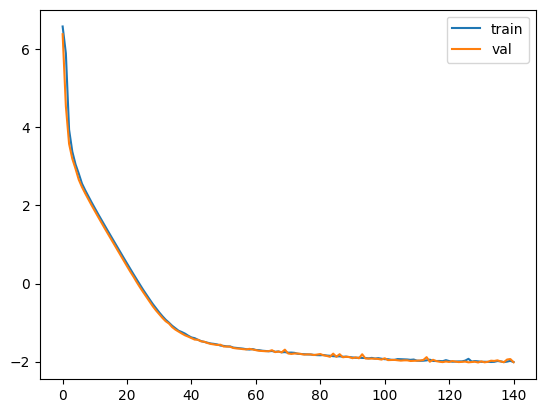

In [12]:
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend();

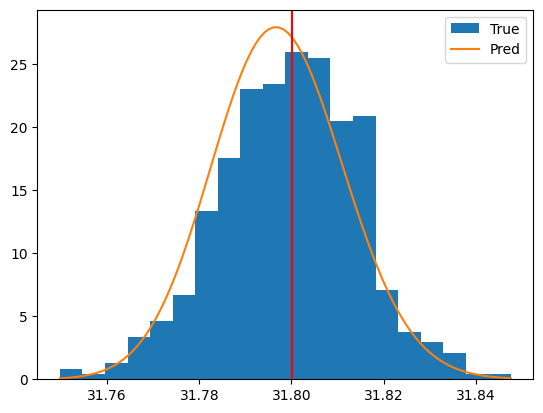

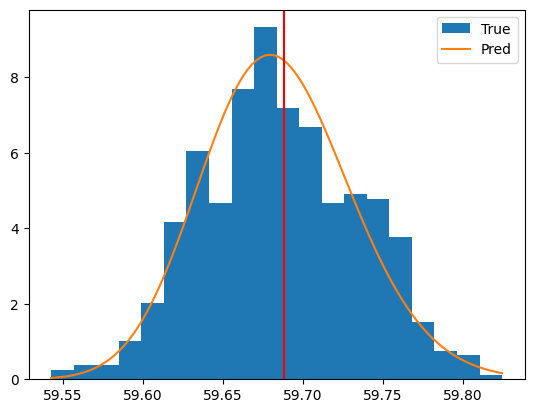

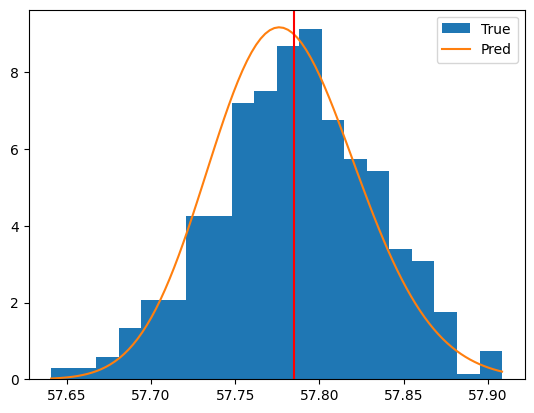

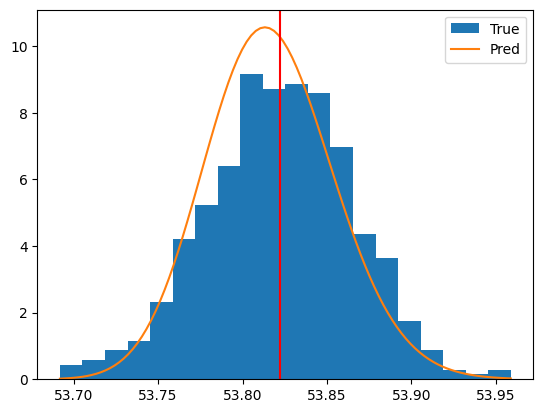

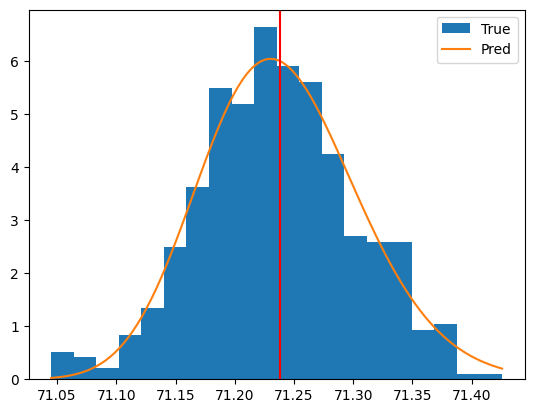

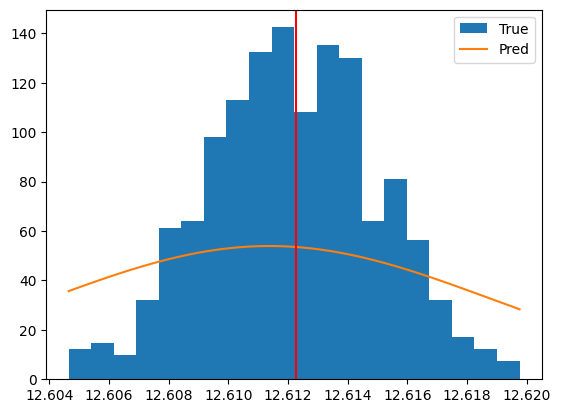

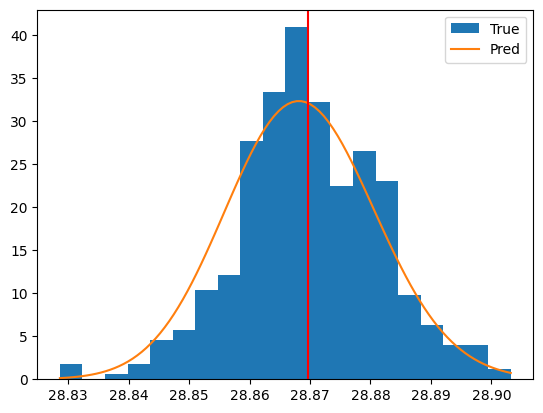

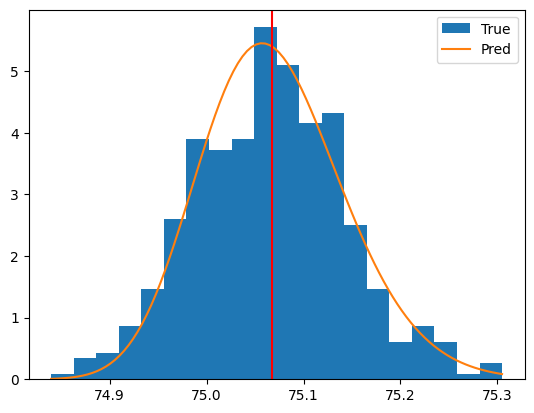

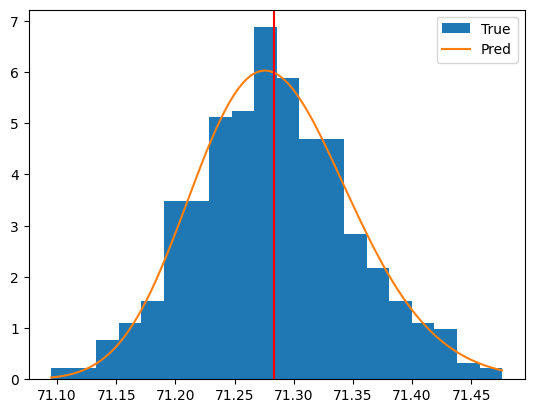

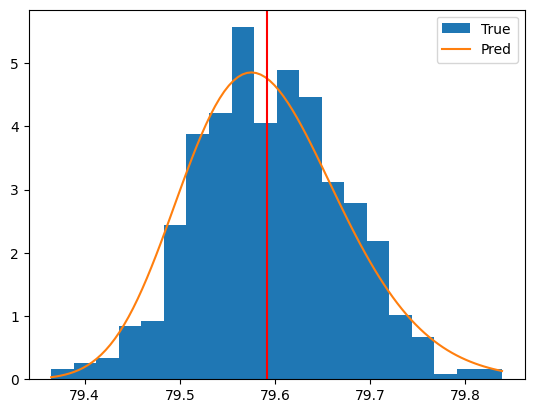

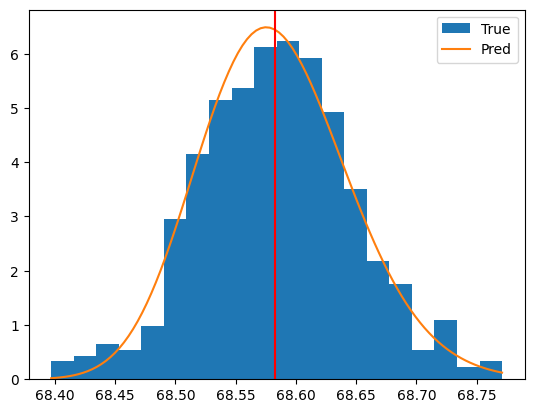

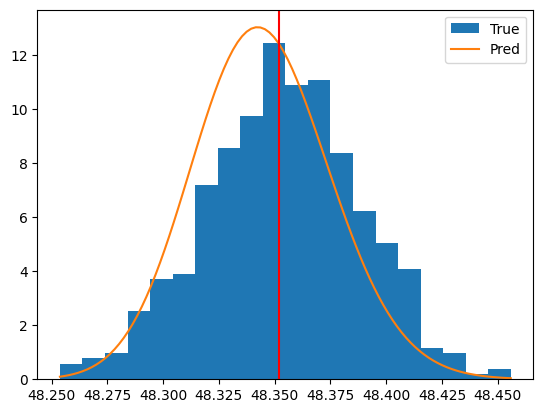

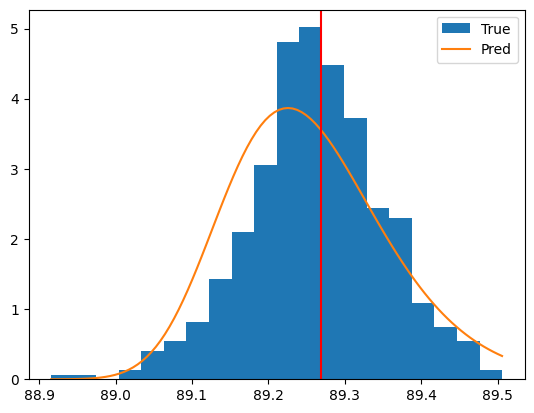

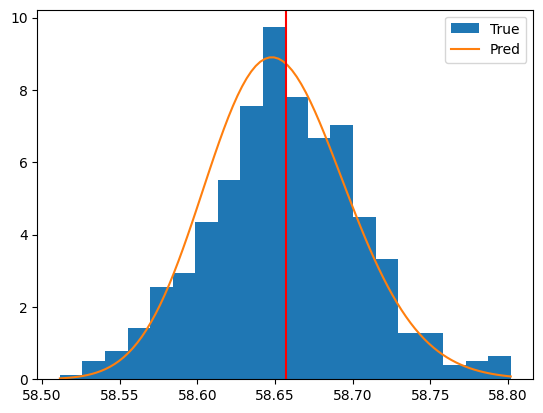

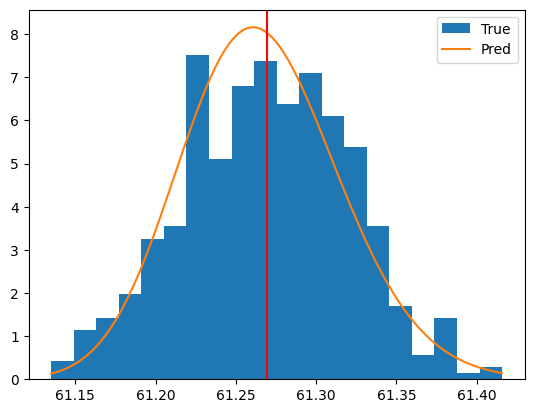

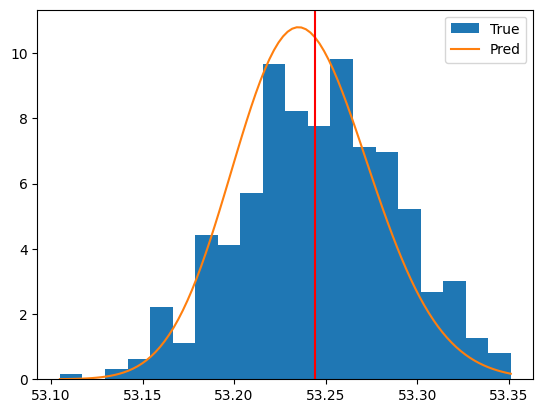

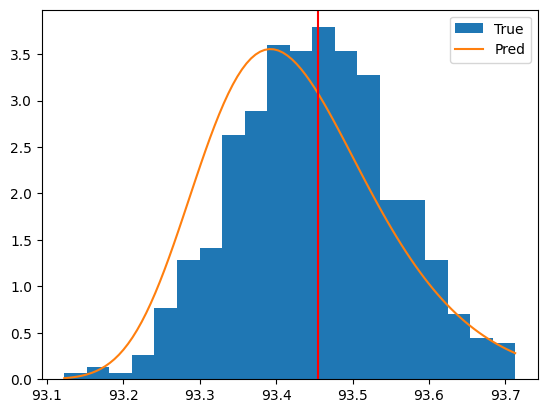

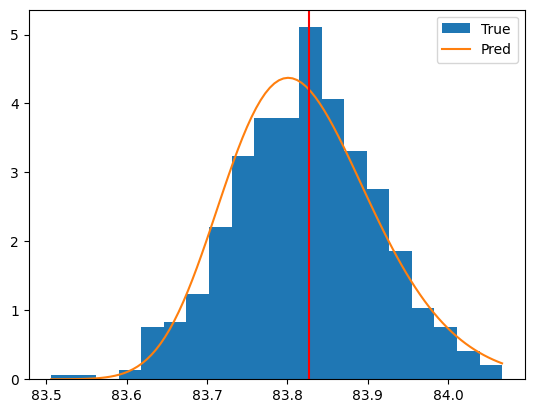

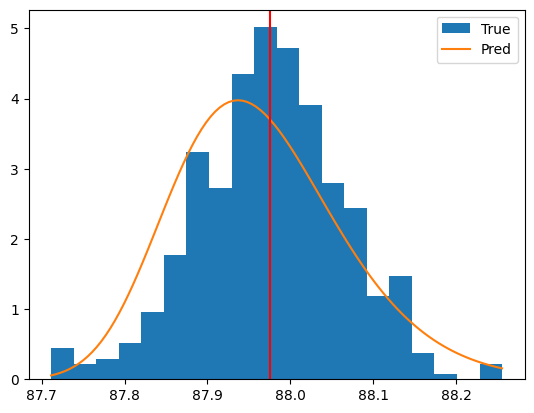

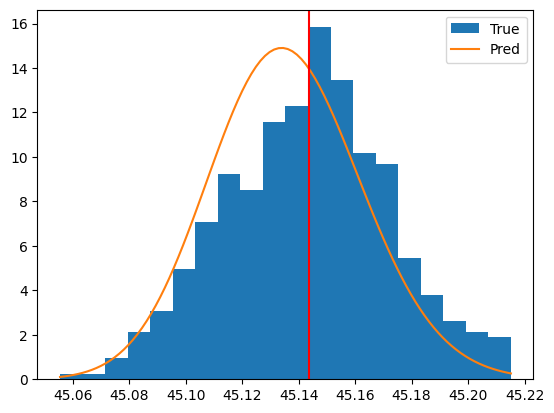

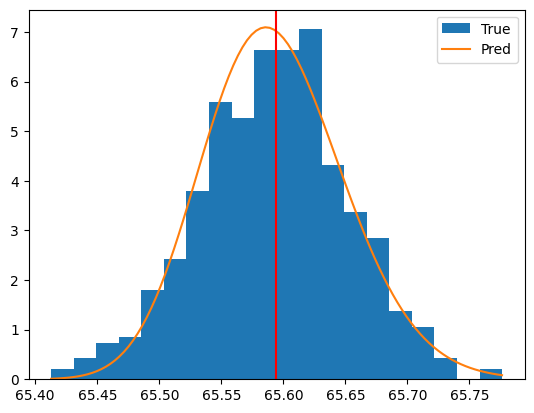

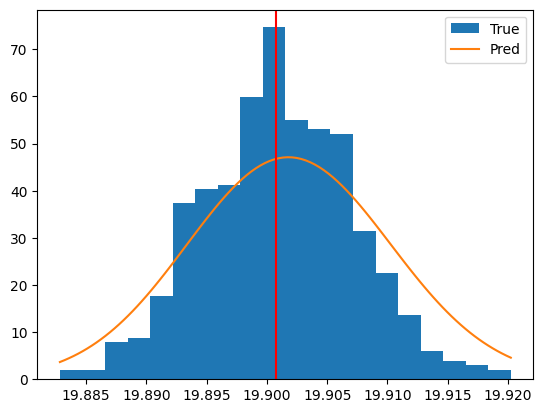

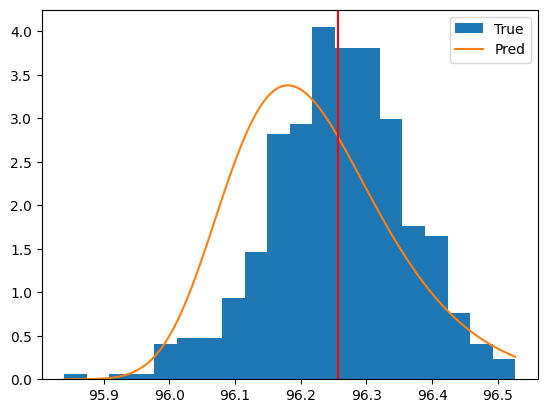

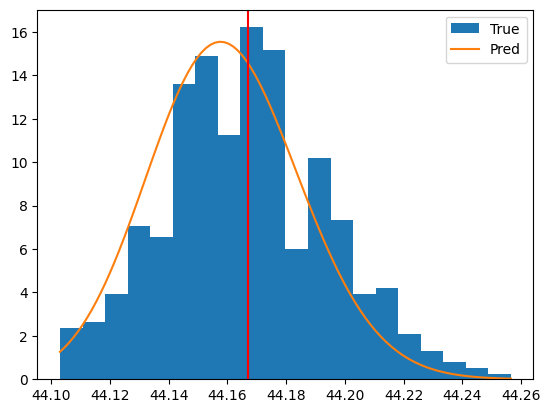

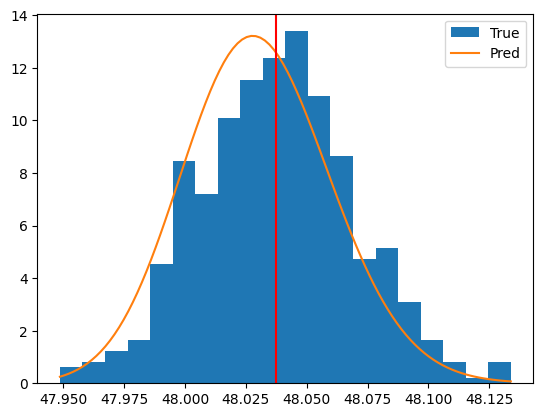

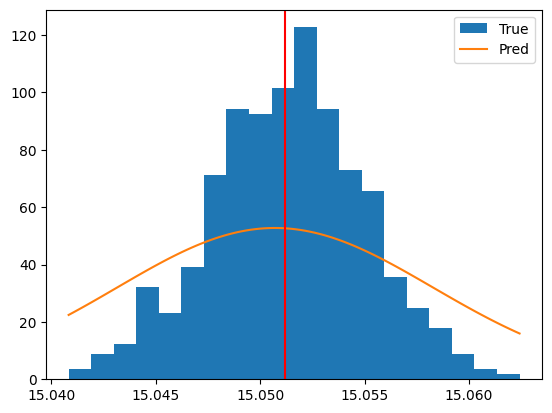

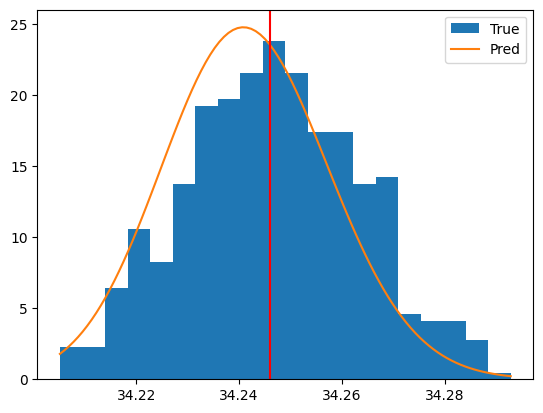

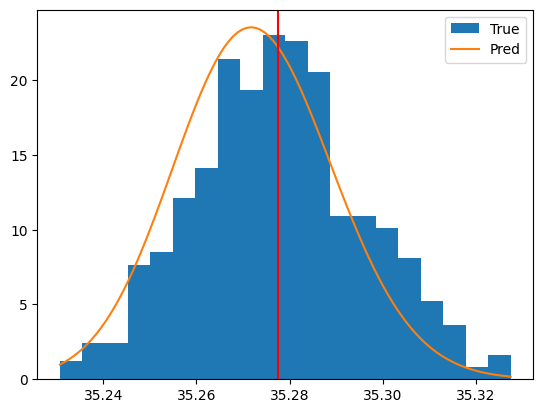

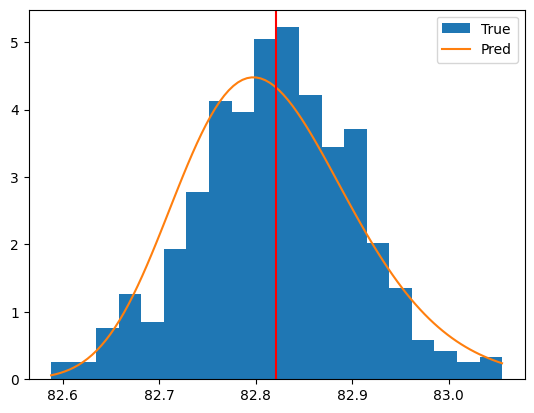

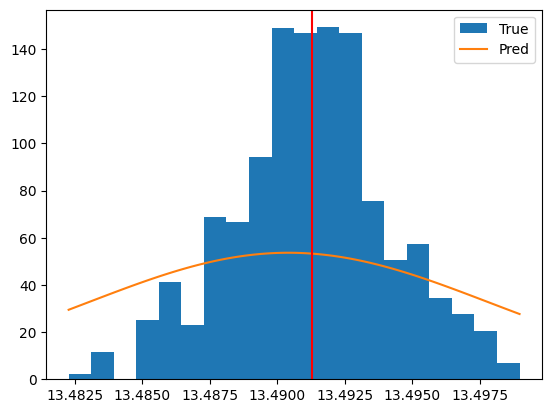

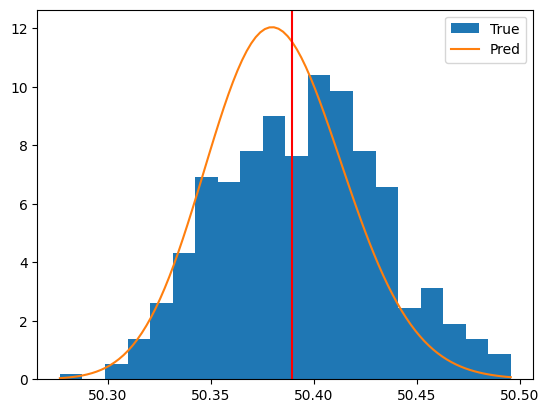

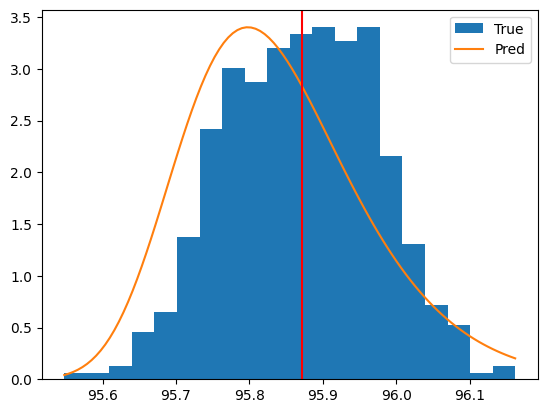

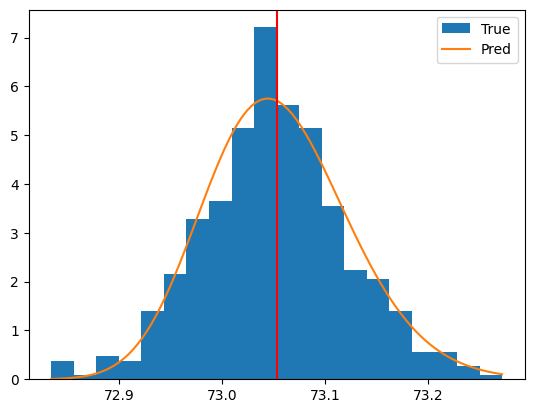

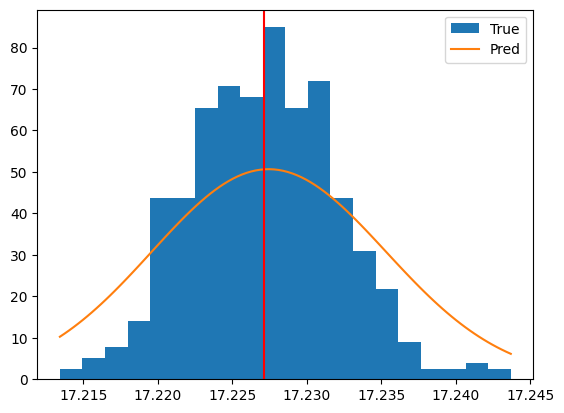

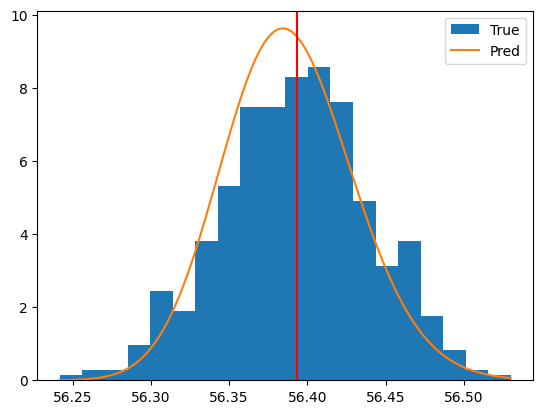

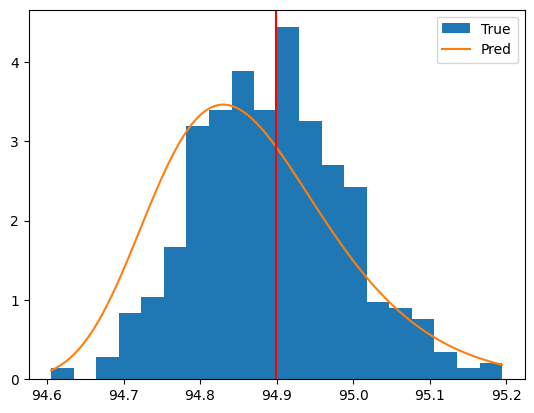

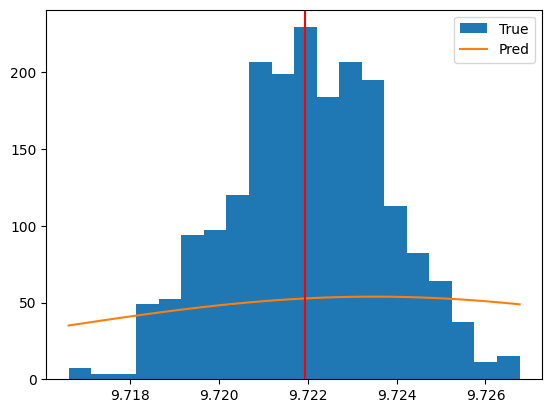

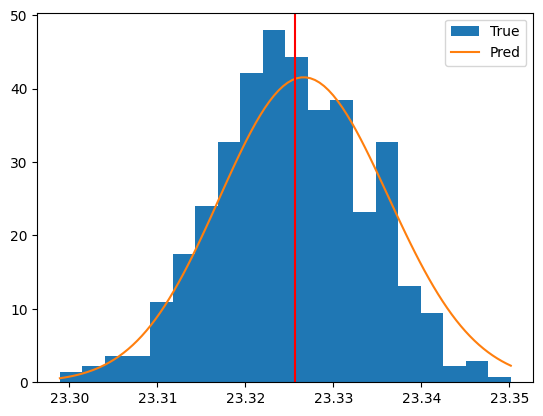

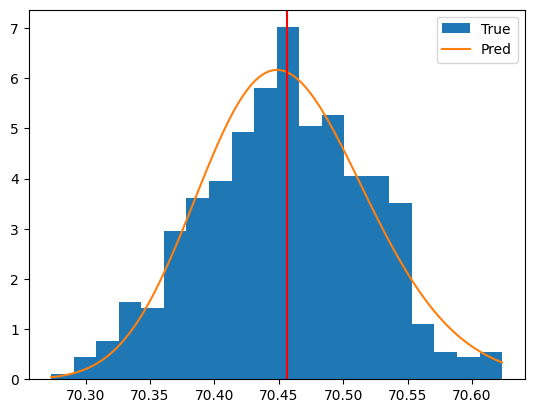

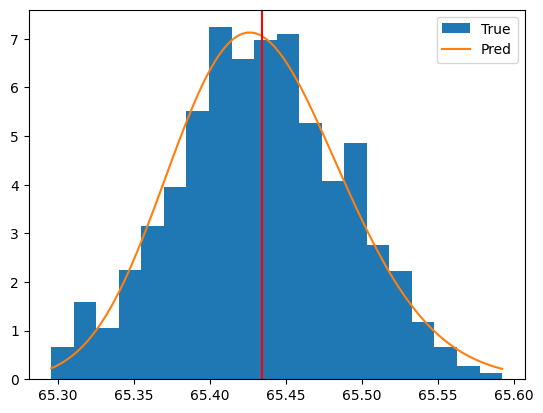

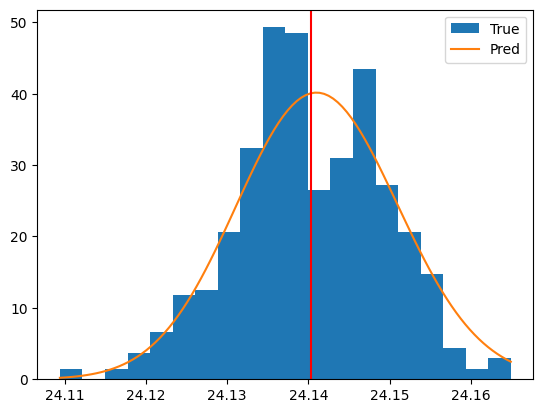

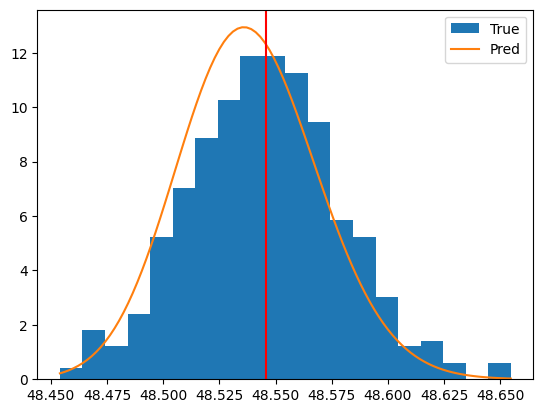

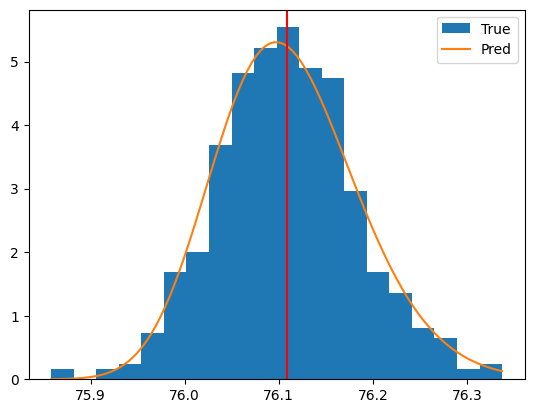

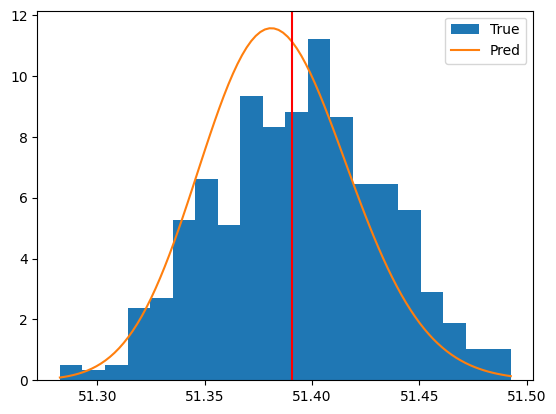

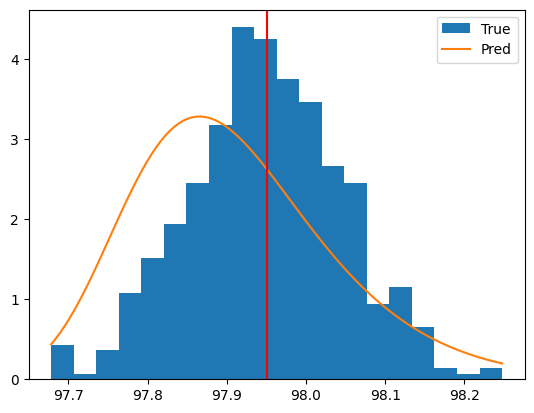

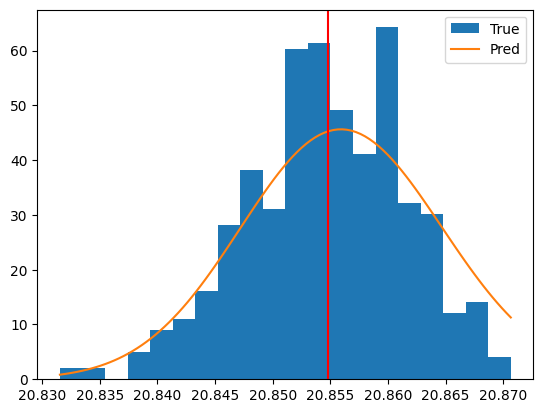

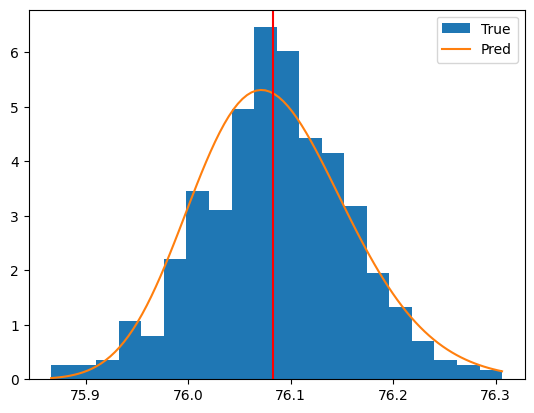

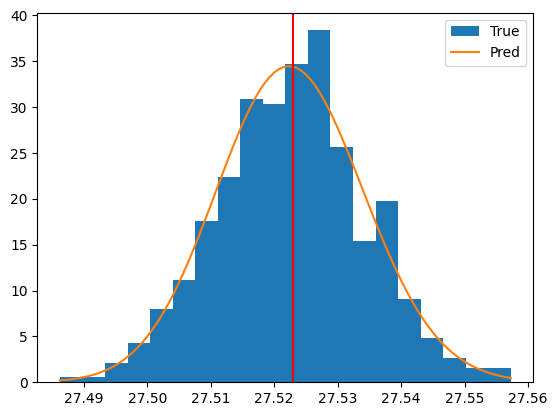

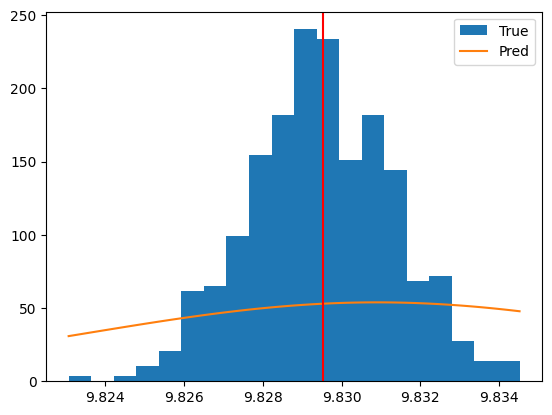

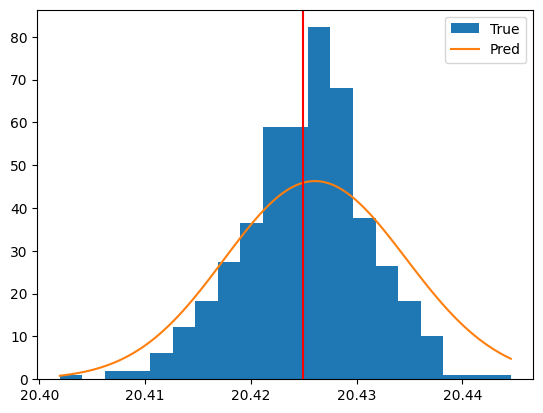

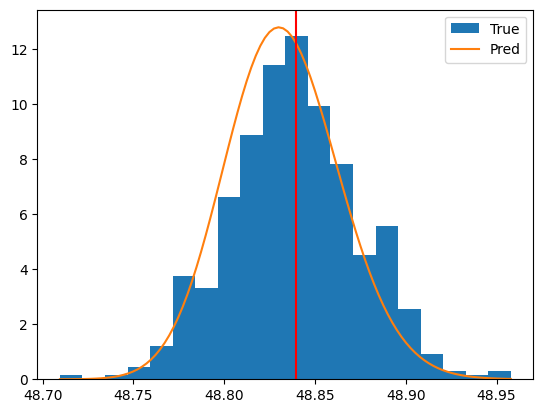

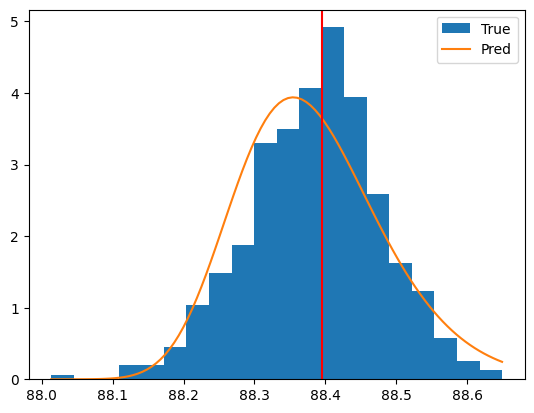

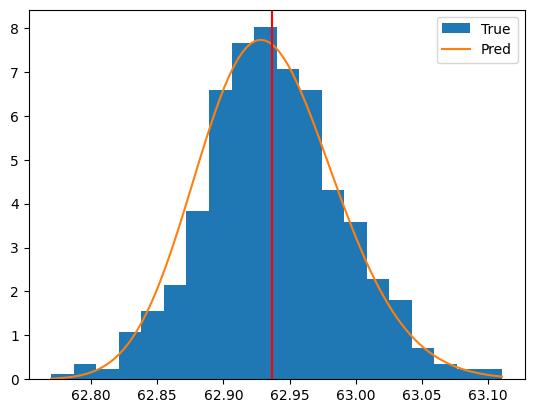

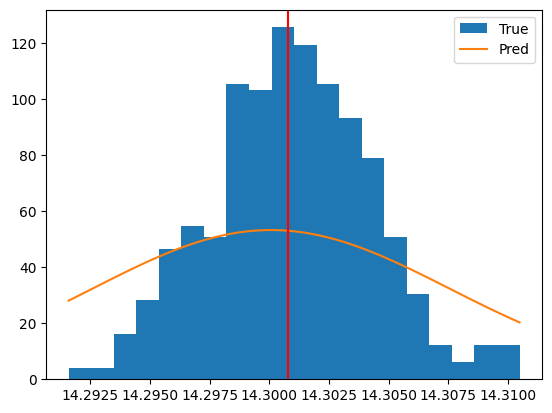

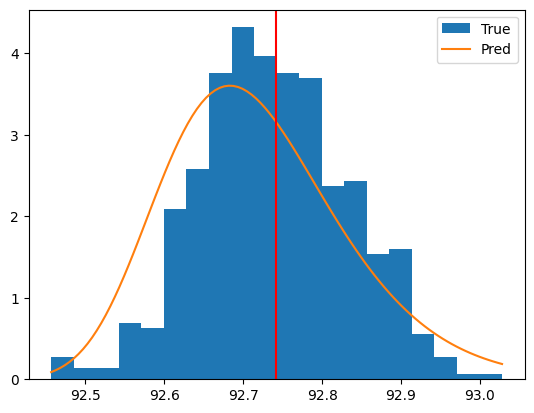

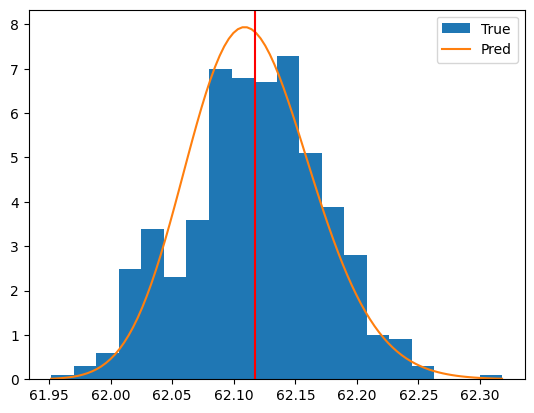

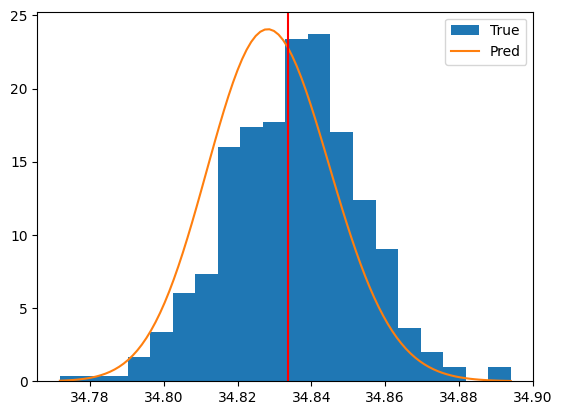

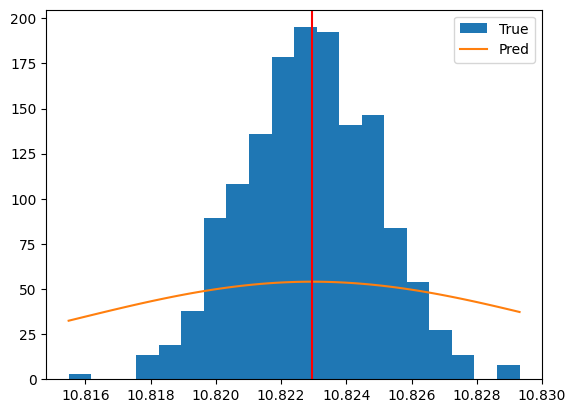

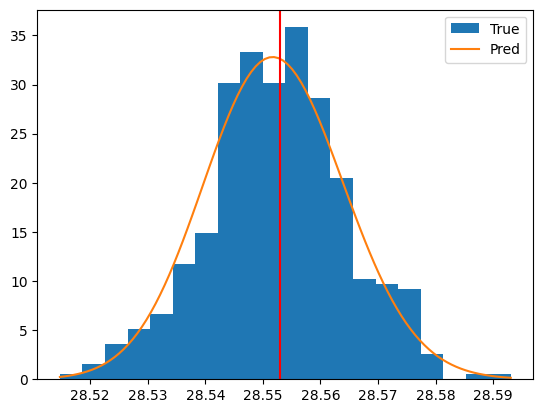

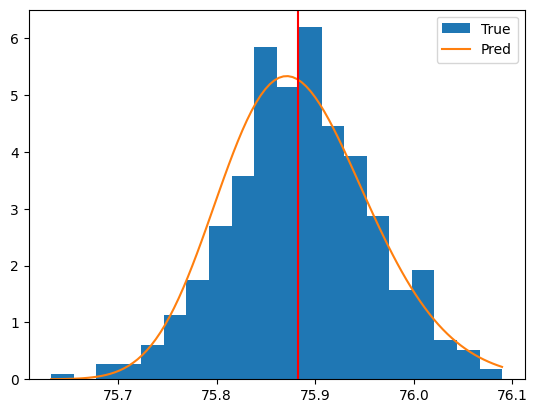

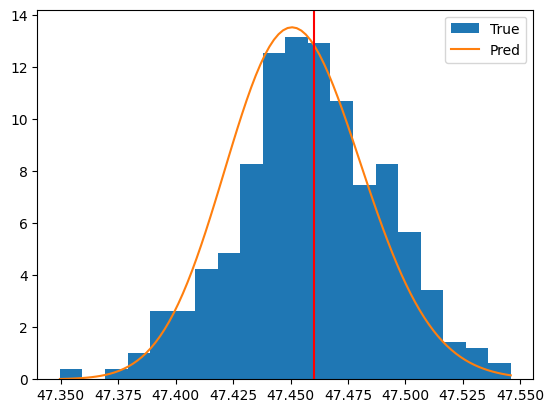

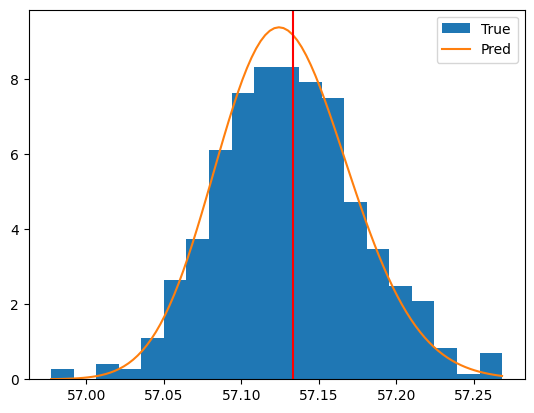

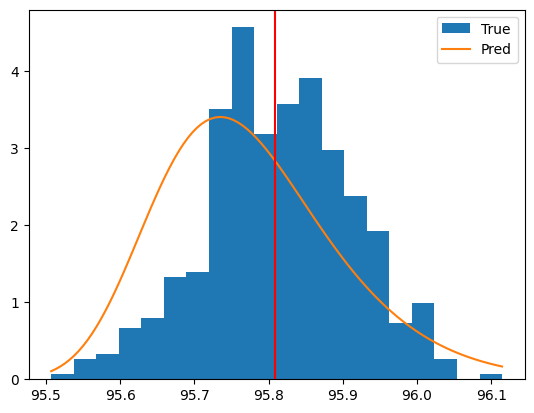

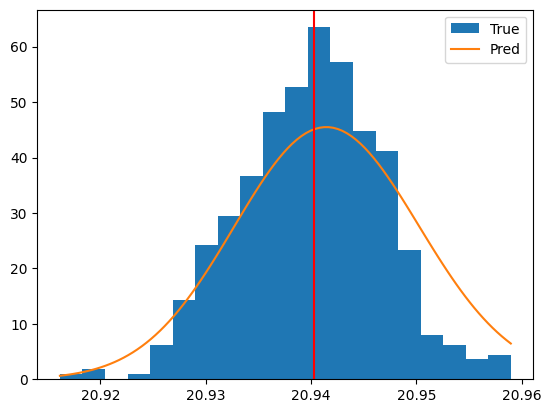

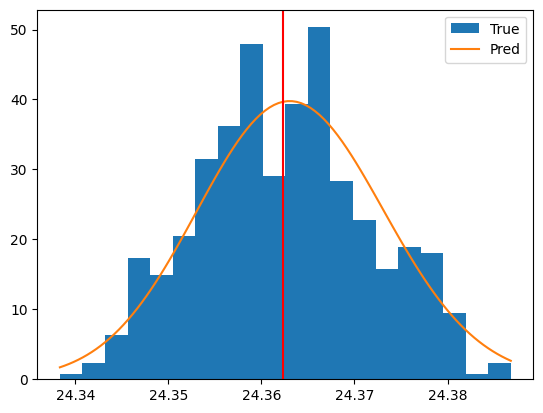

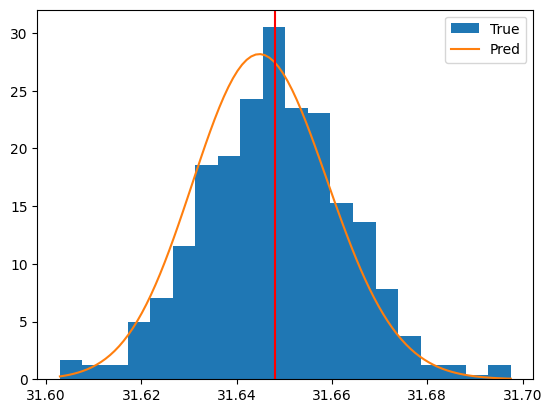

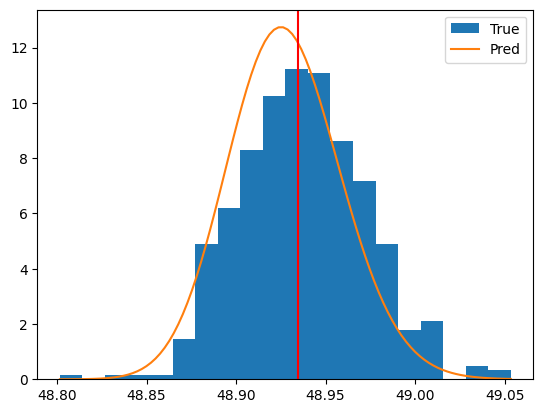

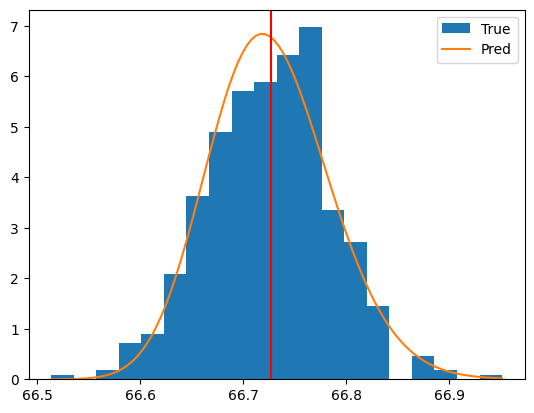

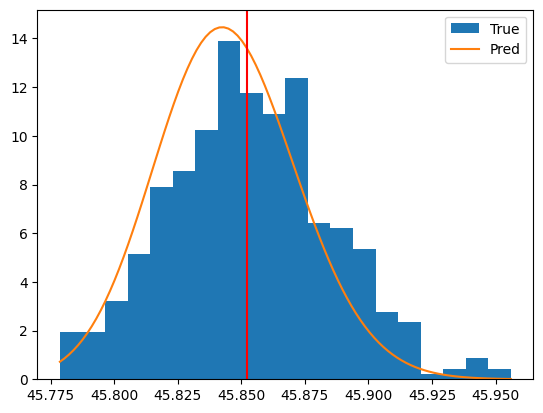

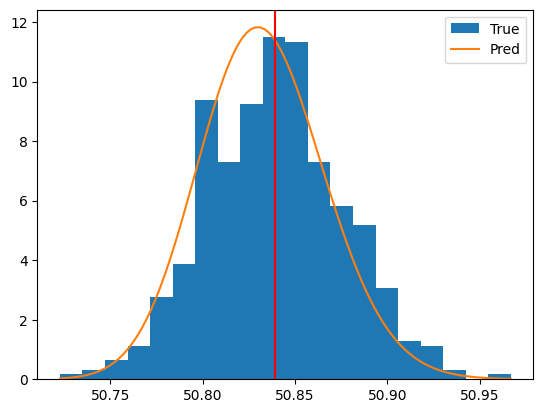

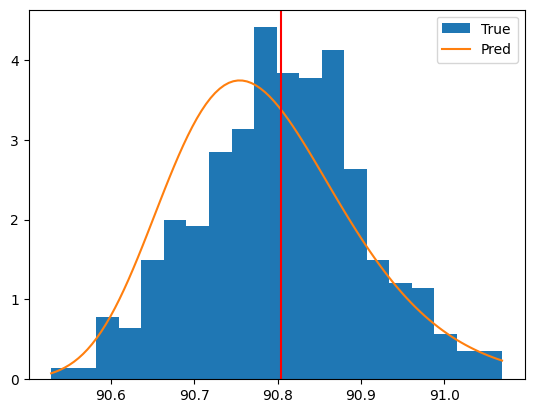

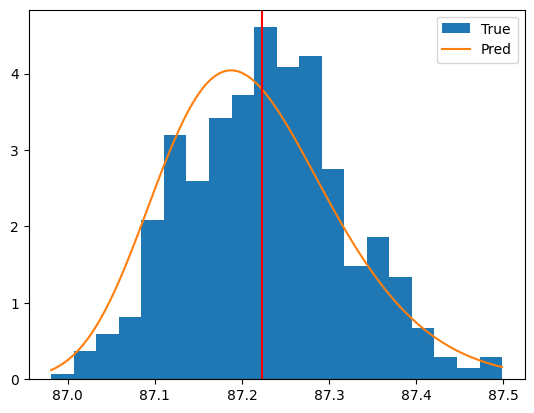

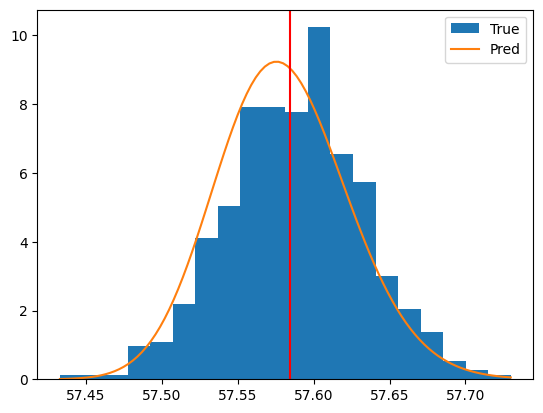

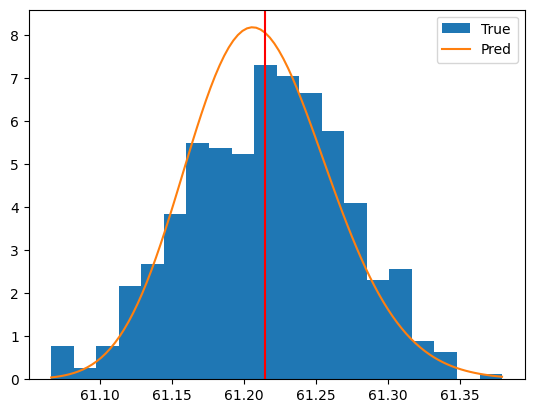

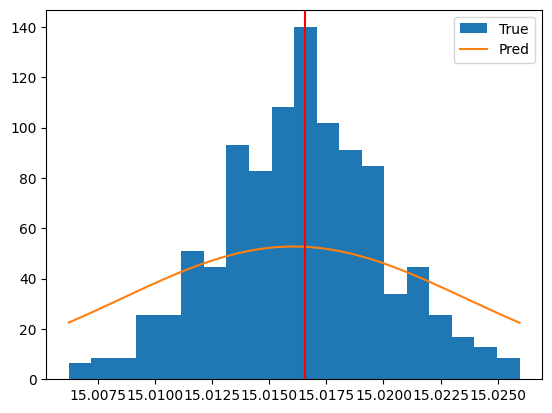

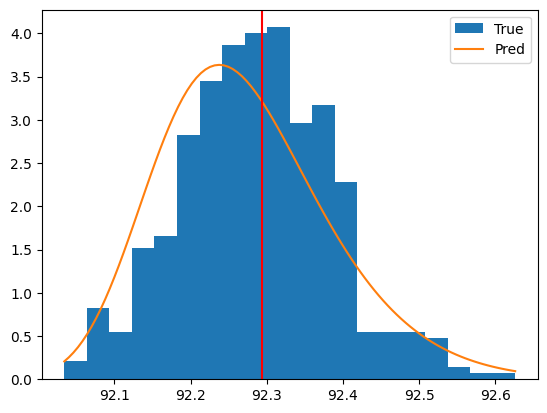

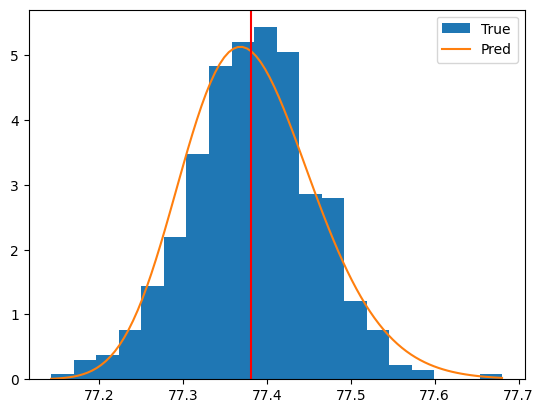

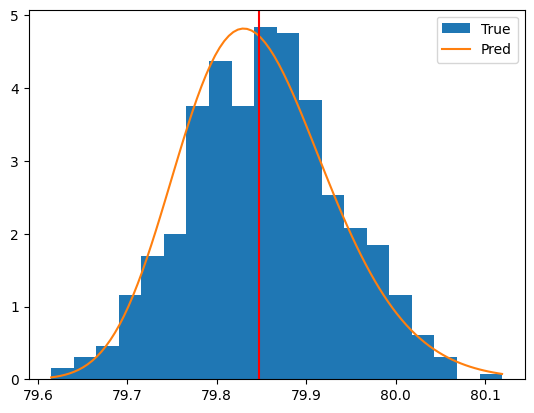

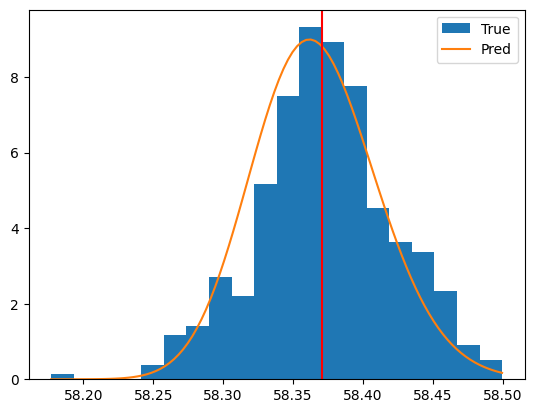

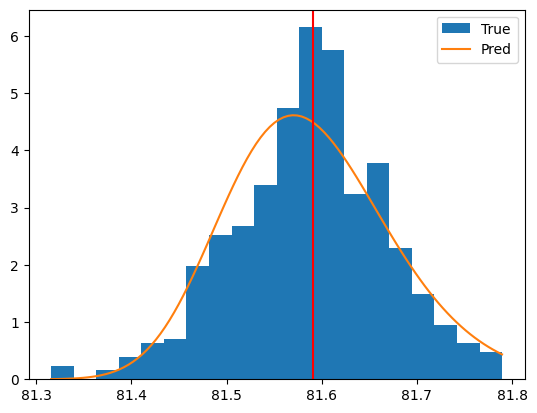

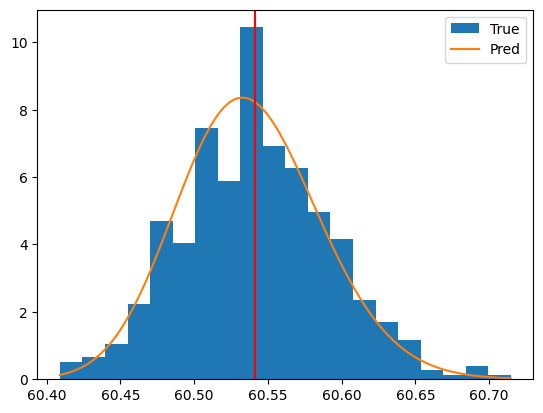

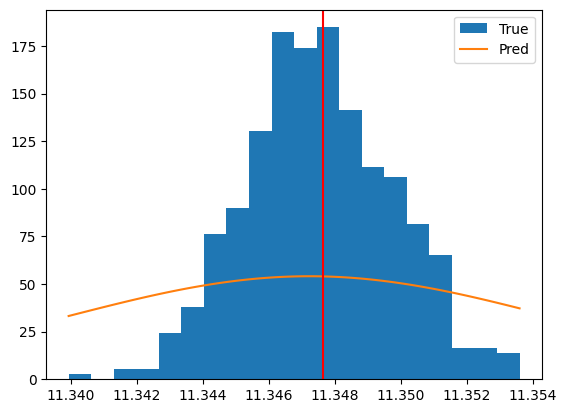

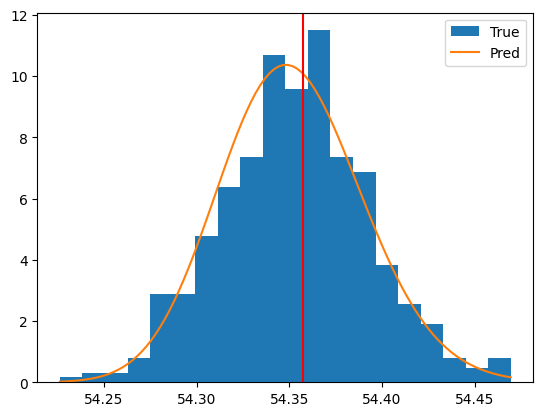

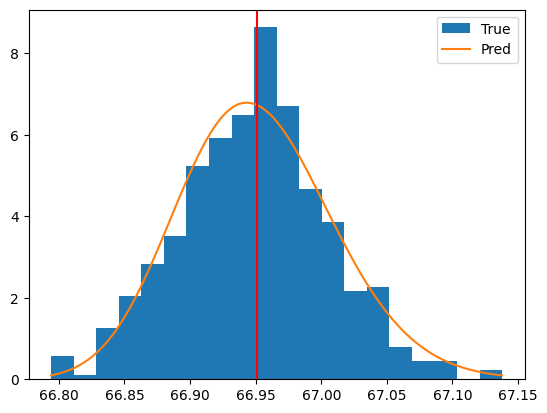

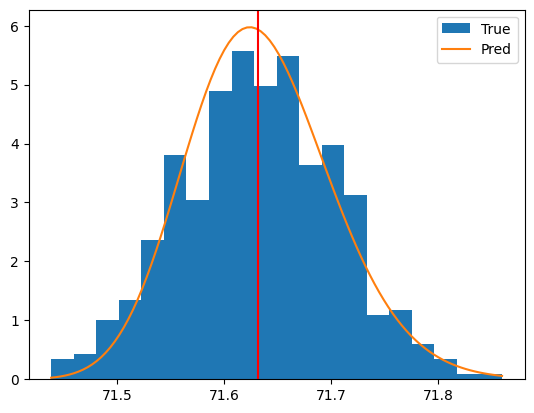

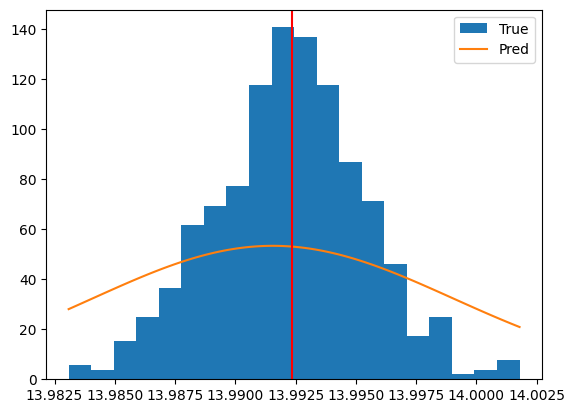

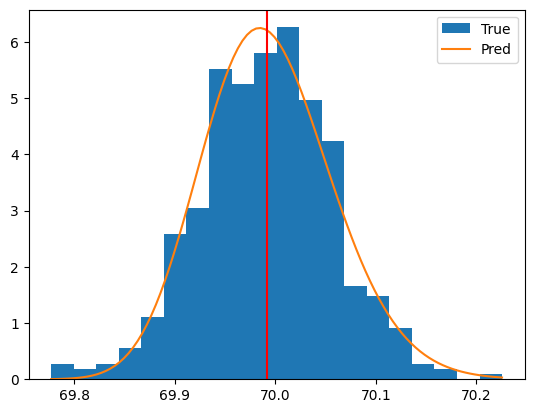

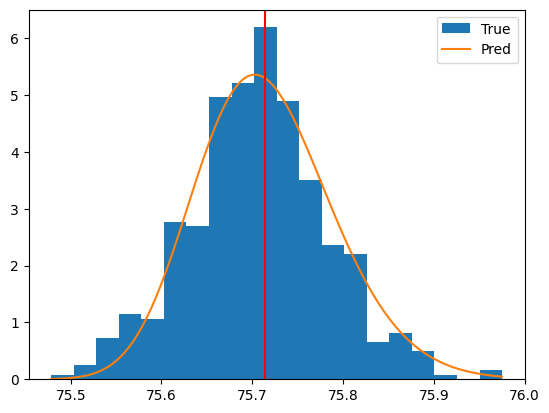

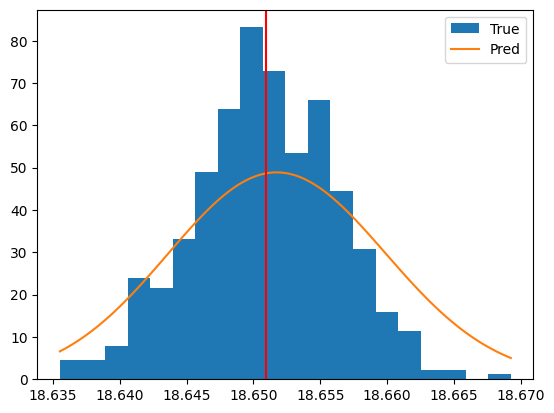

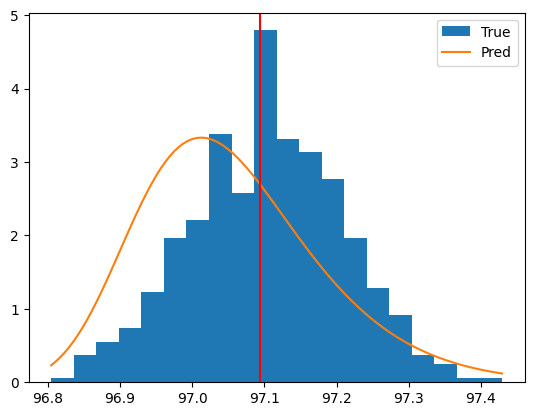

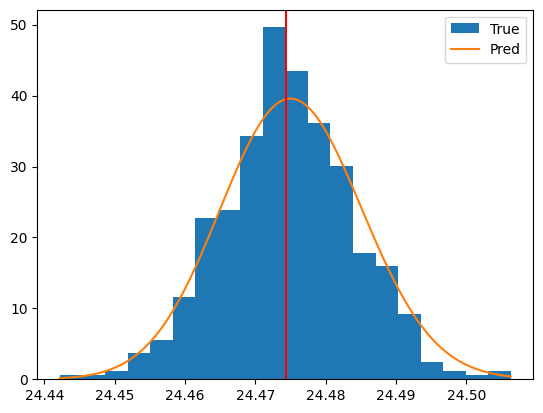

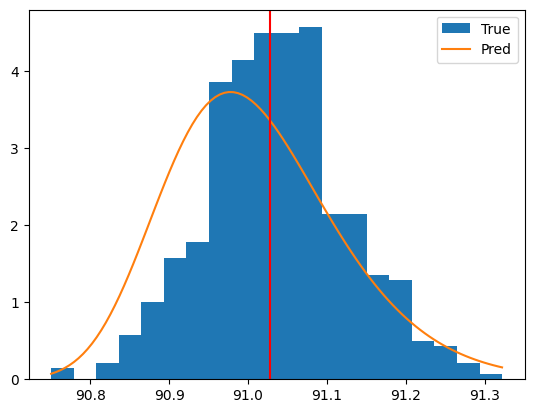

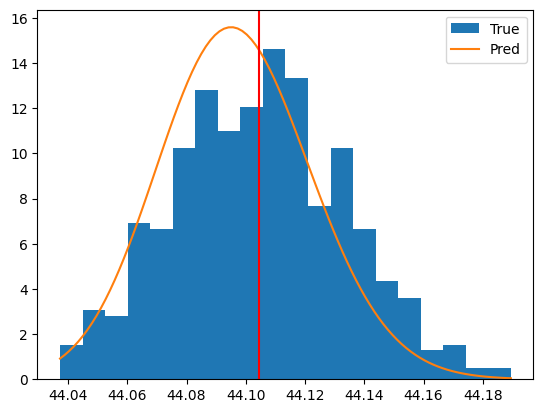

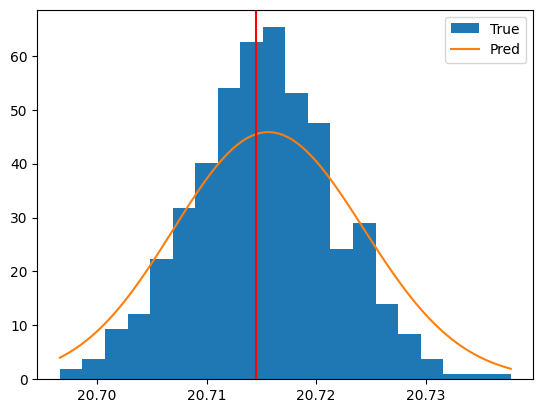

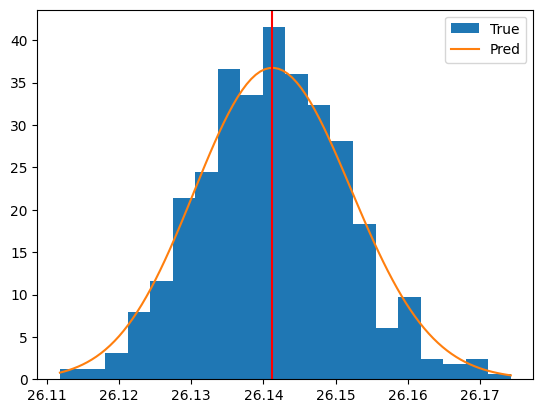

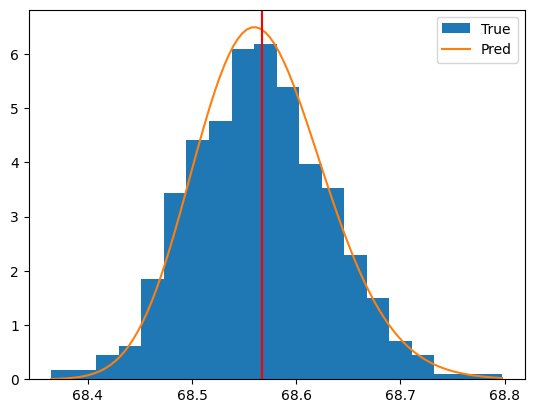

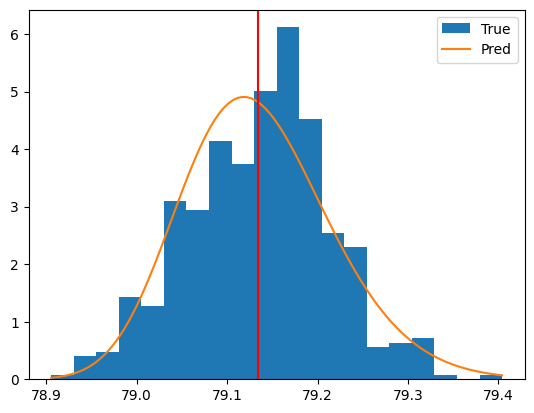

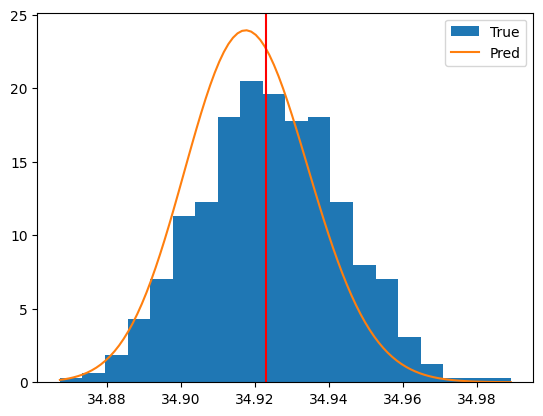

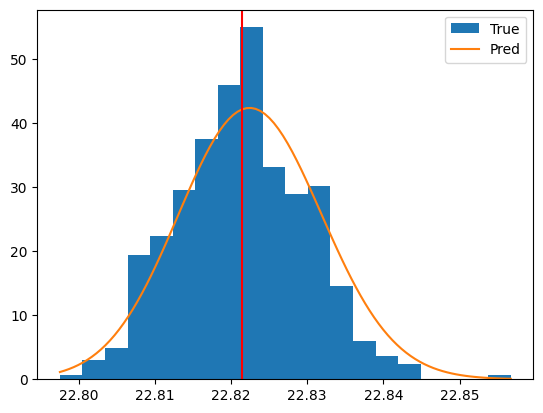

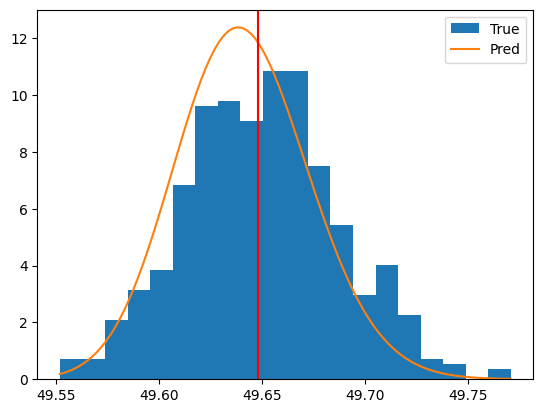

In [17]:
for p, t in zip(posteriors, true):

    t = jnp.array([t])

    p = jax.vmap(preprocess.transform)(p[:, None]).squeeze()

    plt.hist(p, bins=20, density=True, label='True')

    xx = jnp.linspace(p.min(), p.max(), 100)
    pred = jnp.exp(flow.log_prob(xx[:, None], t))
    plt.plot(xx, pred, label='Pred')

    t = preprocess.transform(t)
    plt.axvline(t, c='r')

    plt.legend()
    plt.show()

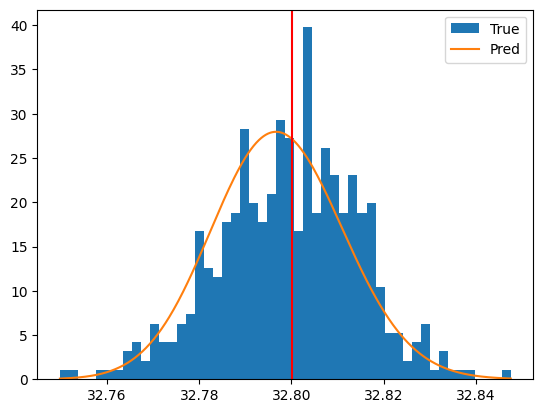

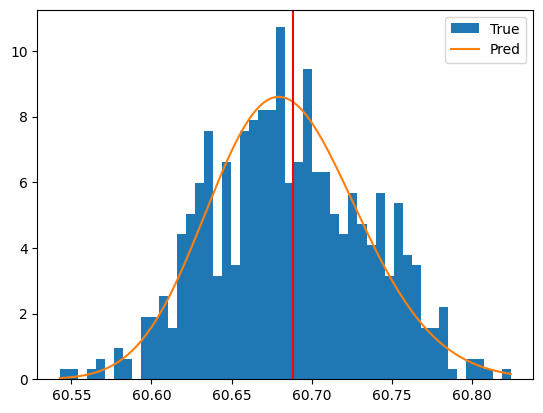

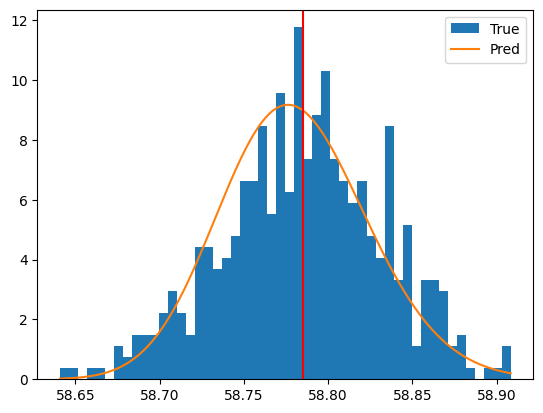

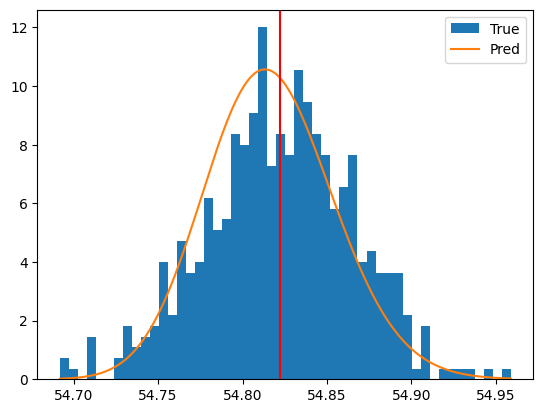

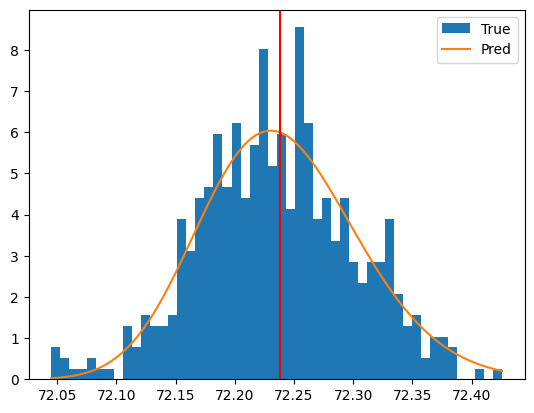

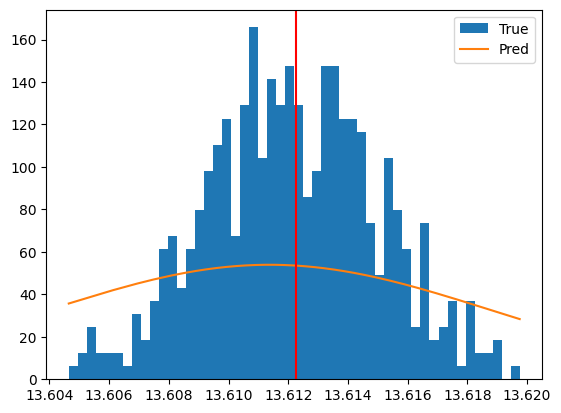

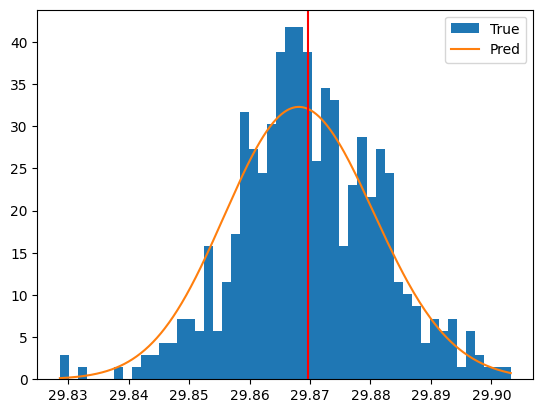

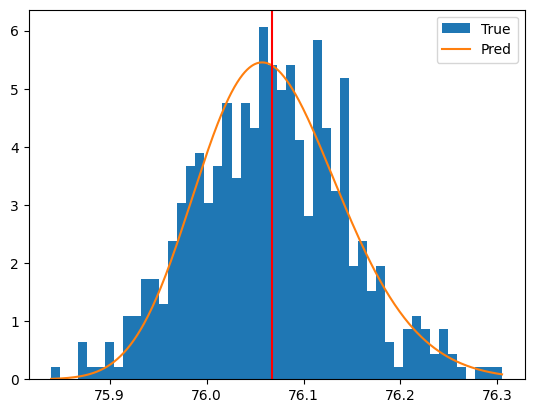

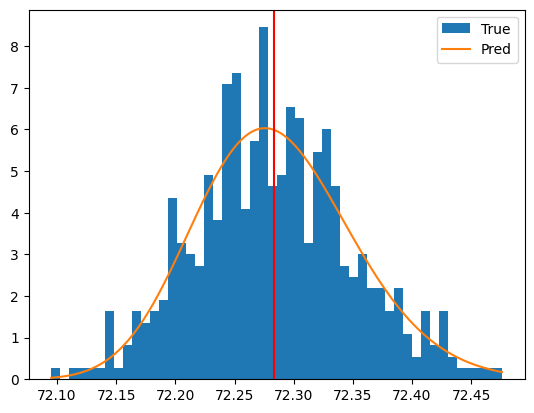

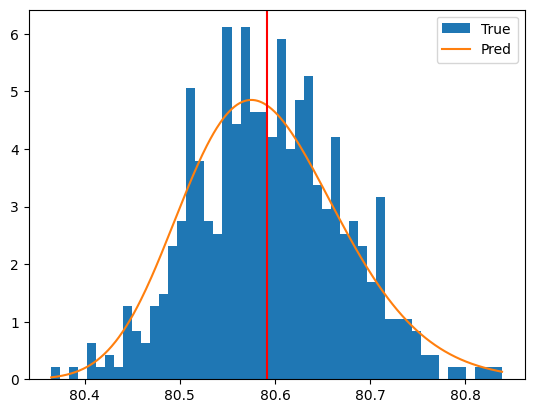

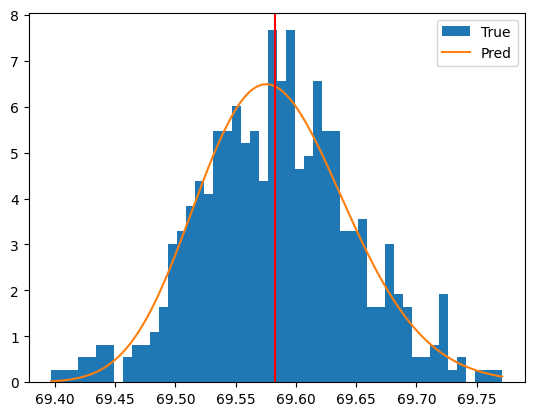

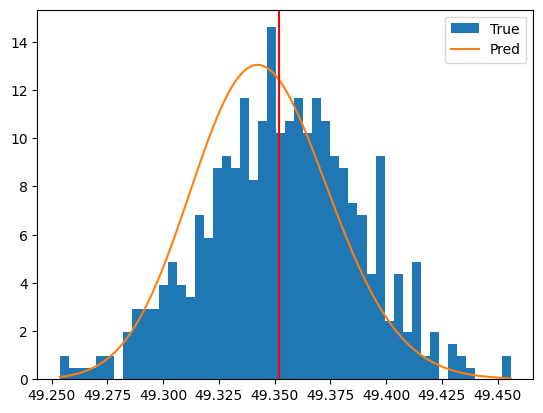

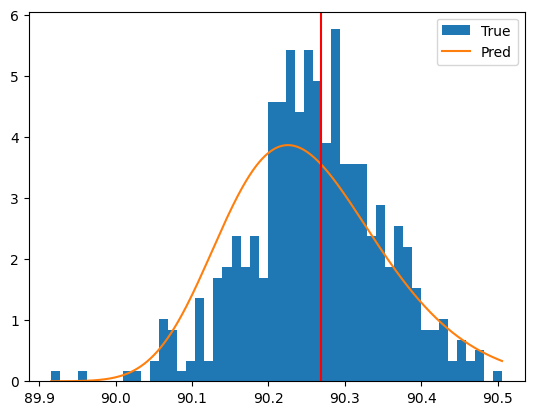

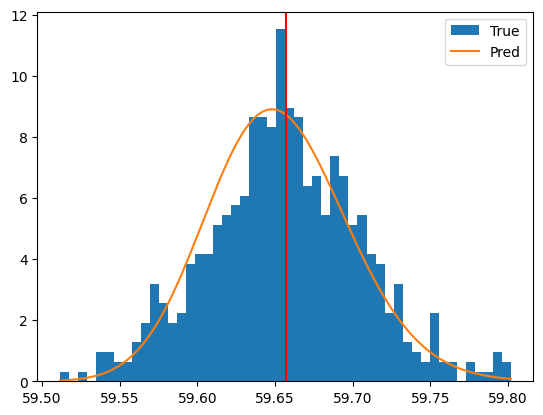

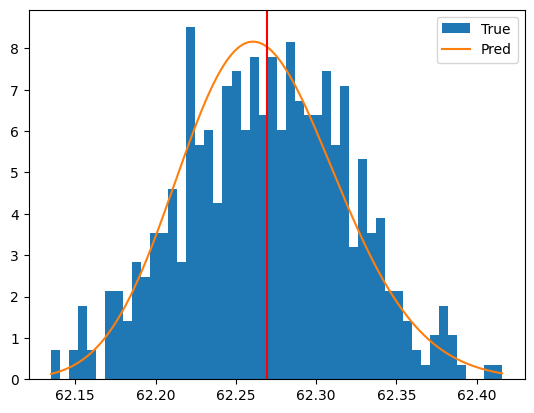

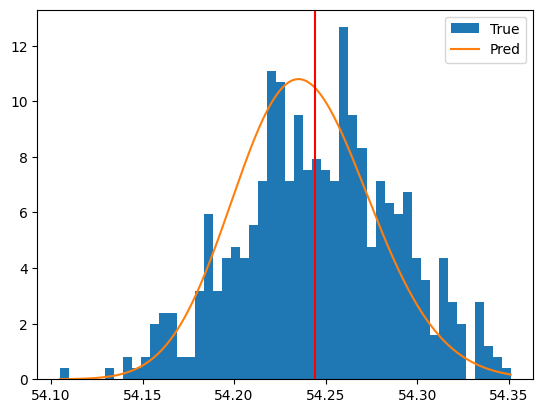

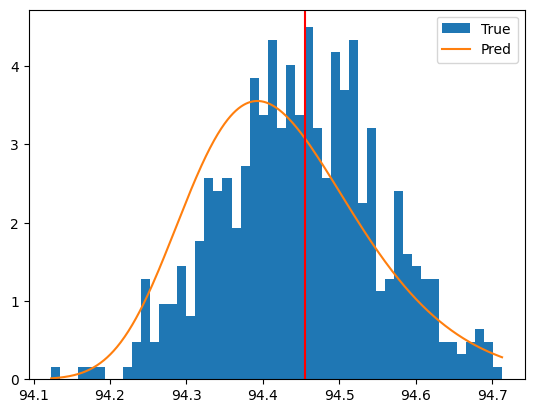

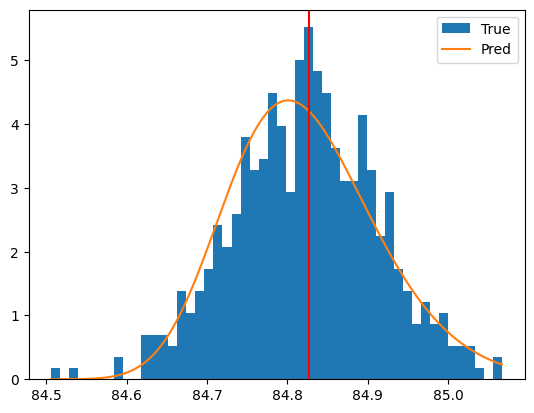

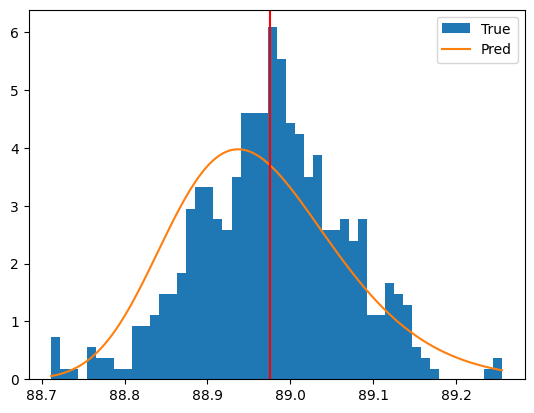

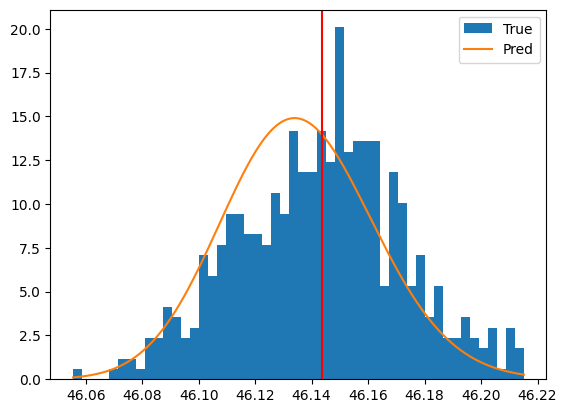

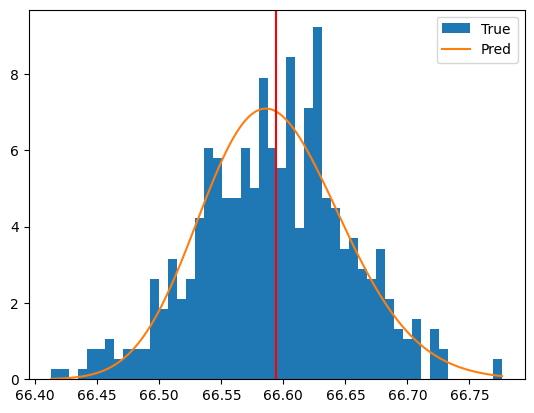

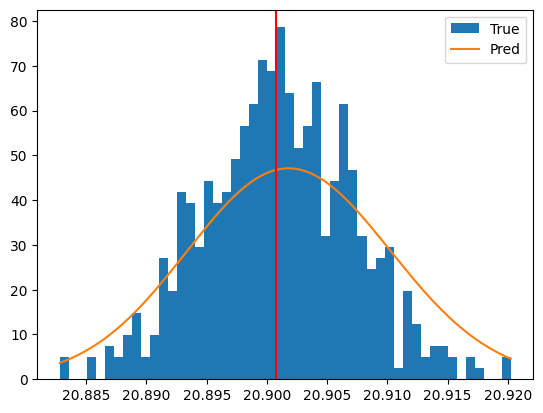

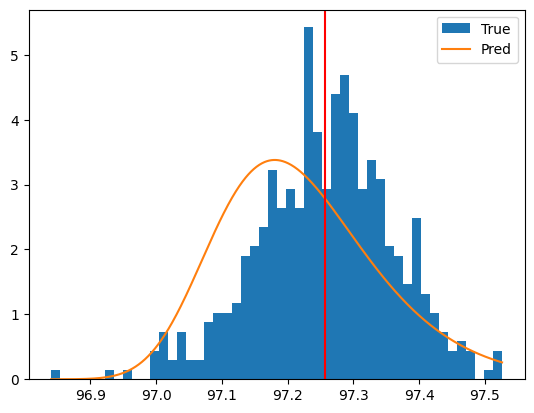

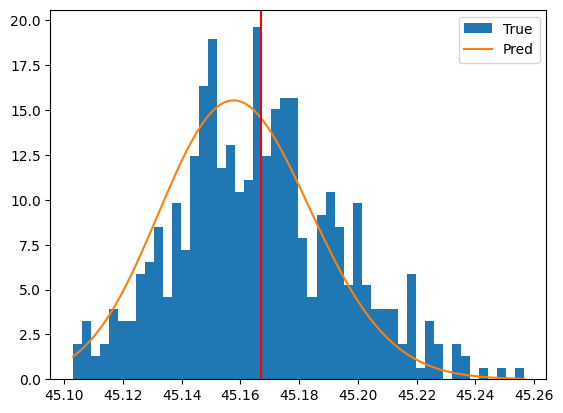

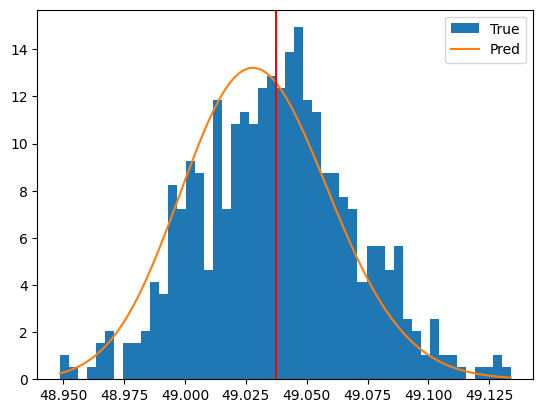

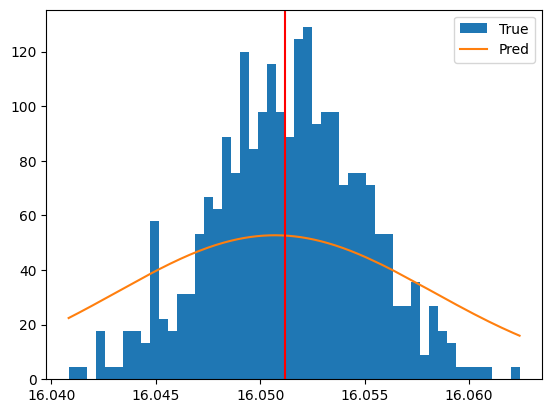

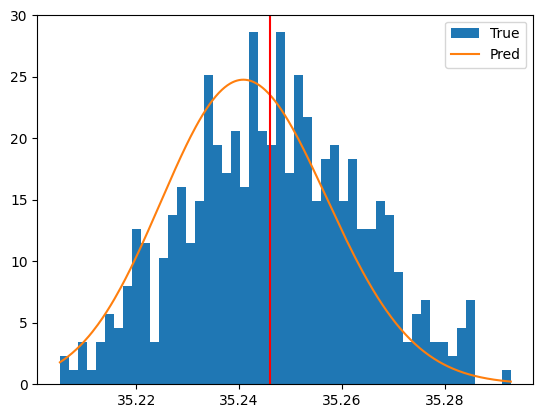

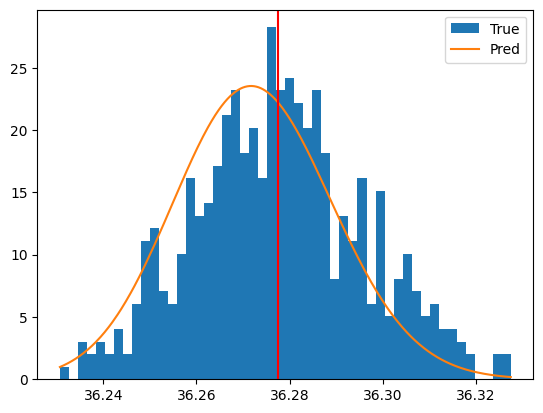

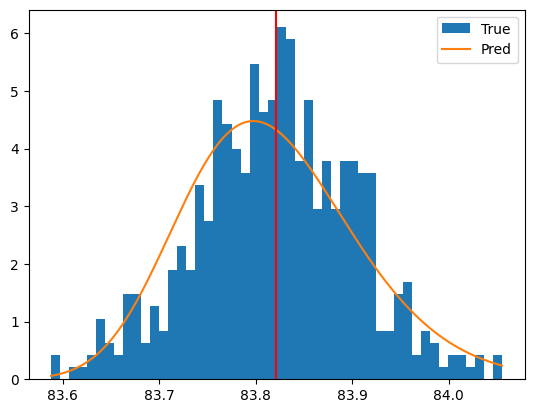

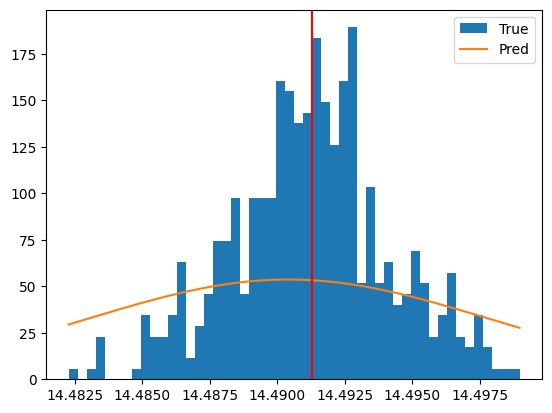

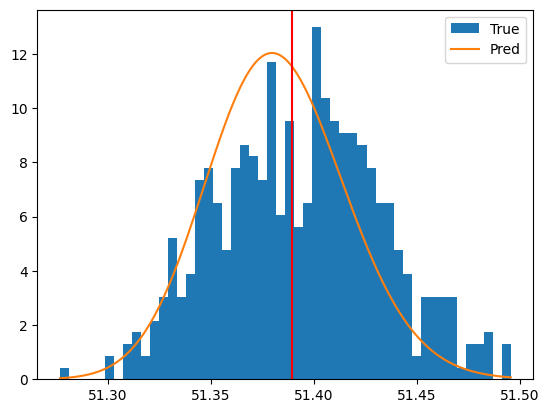

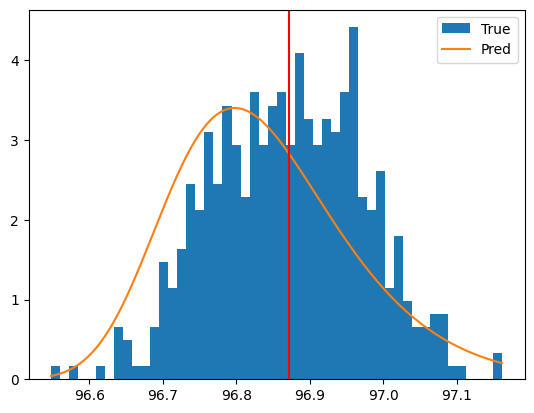

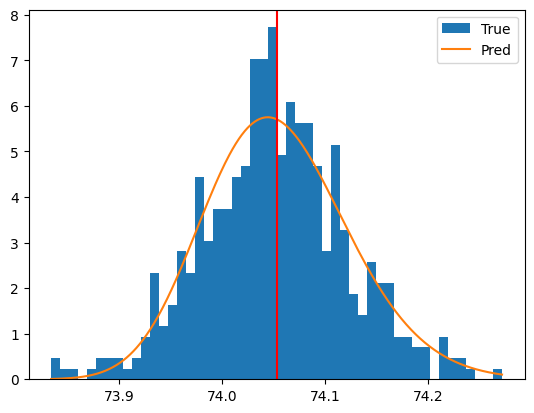

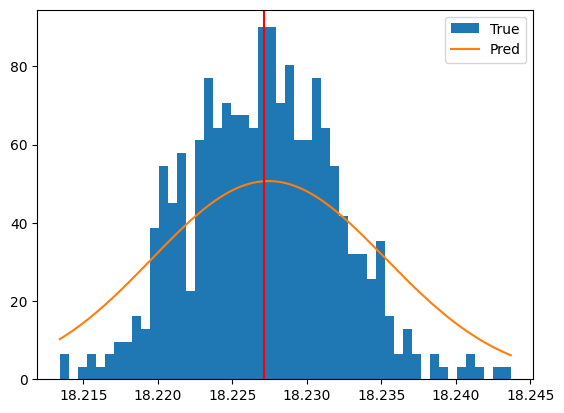

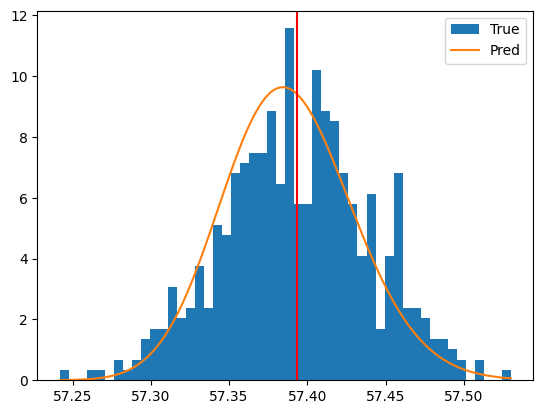

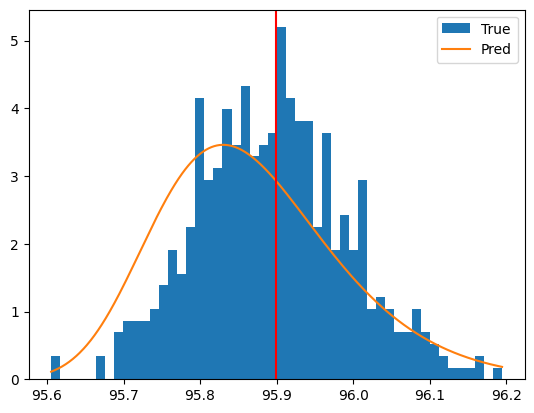

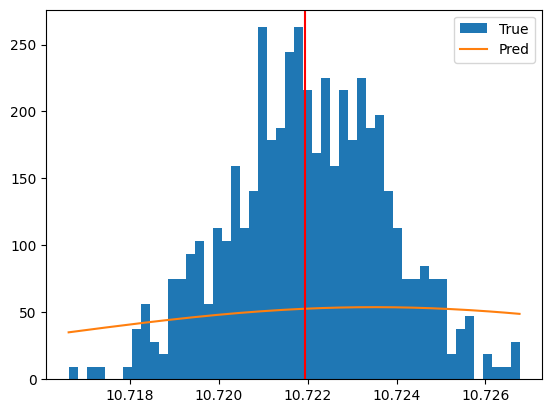

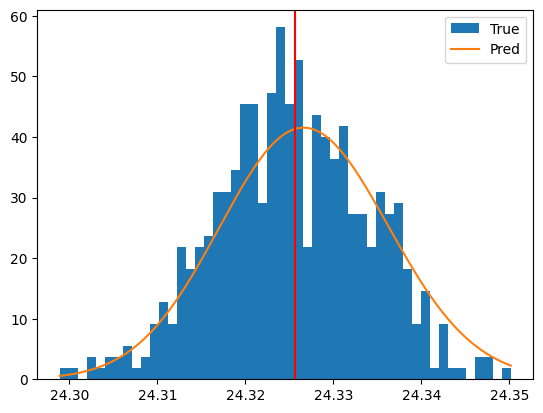

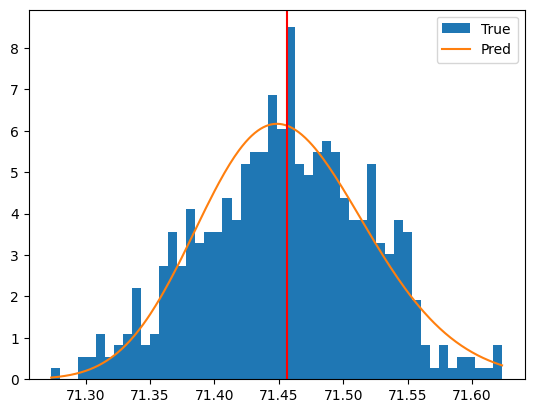

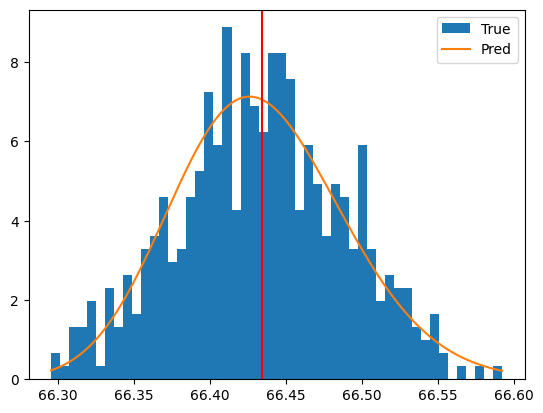

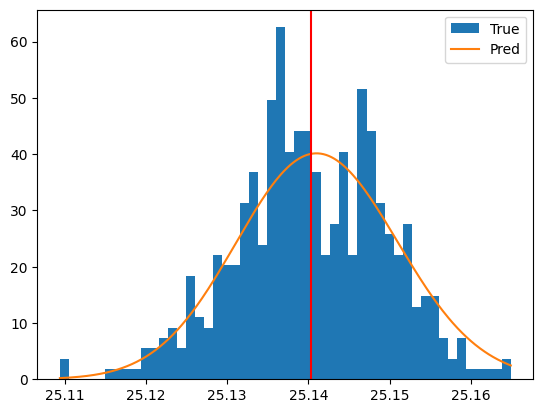

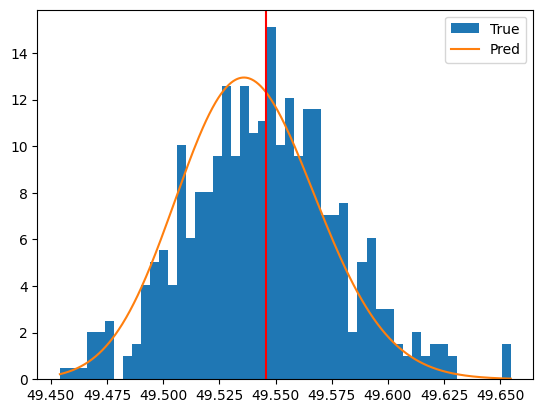

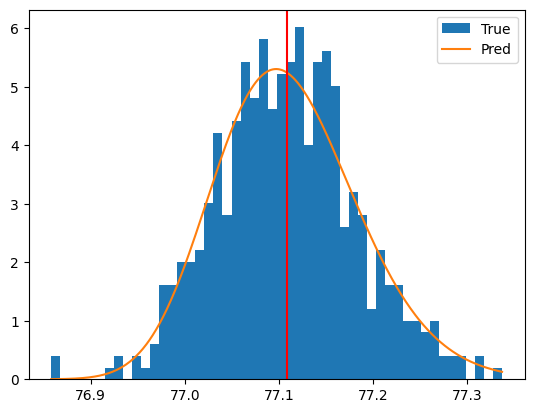

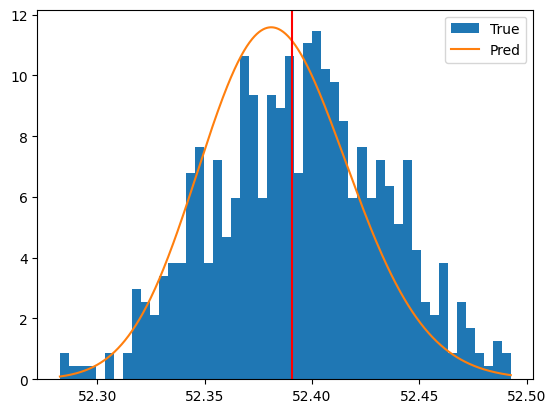

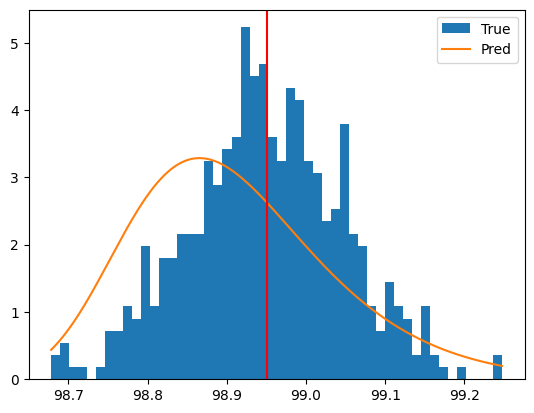

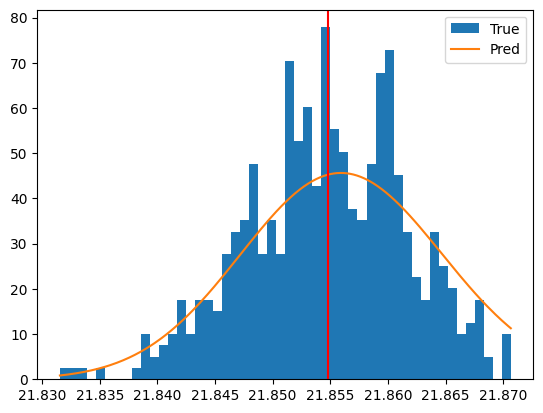

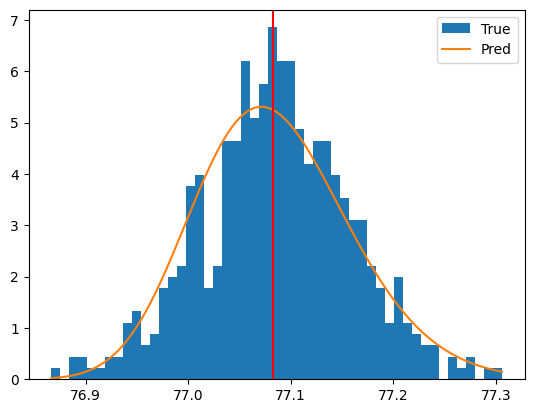

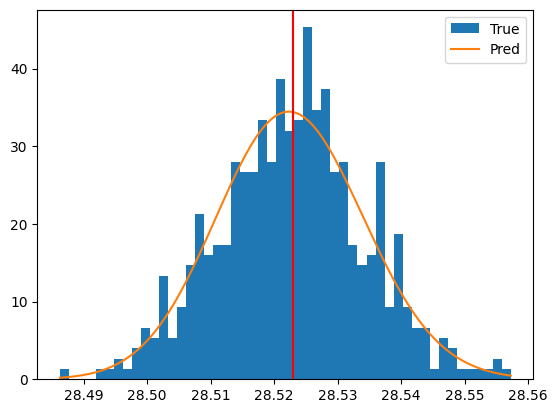

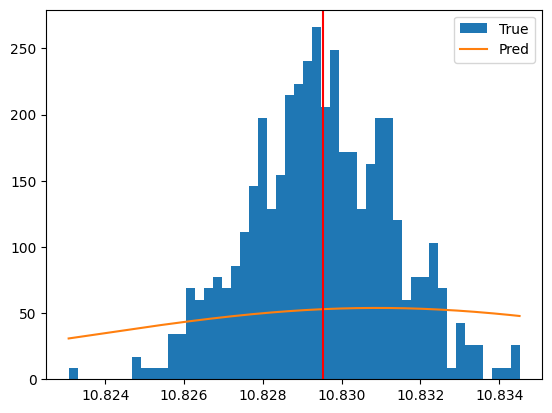

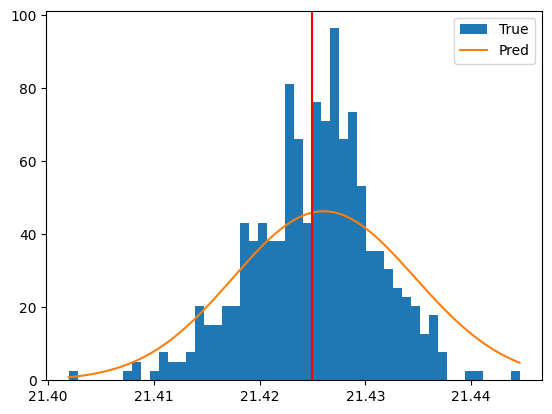

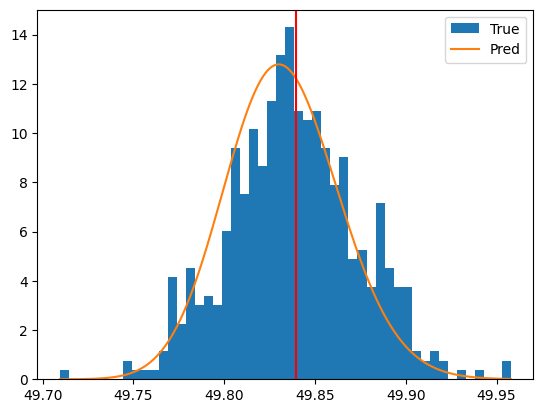

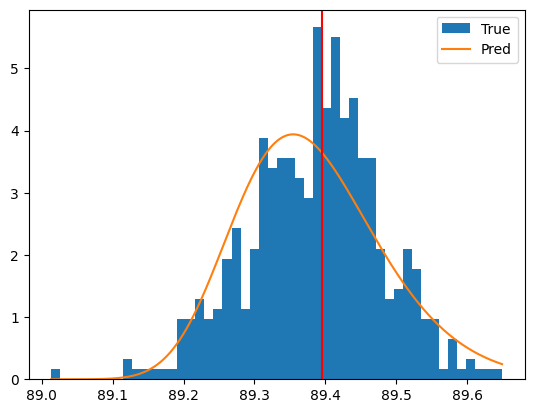

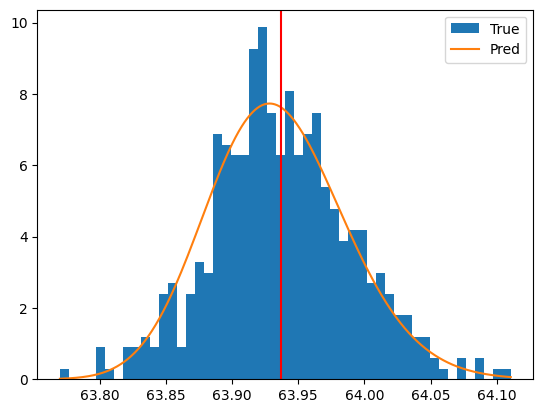

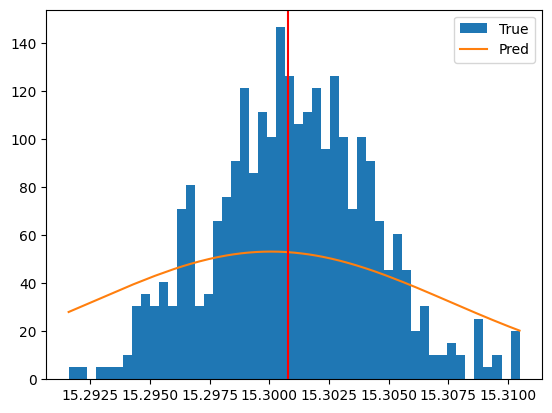

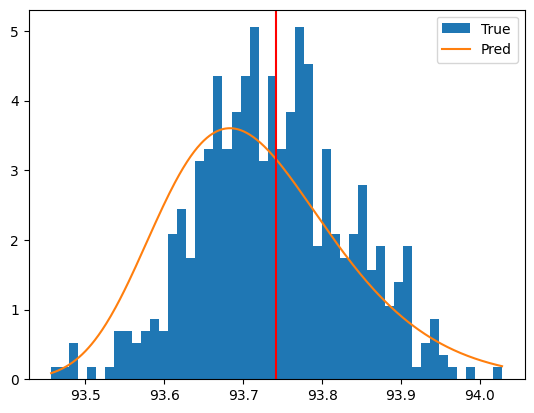

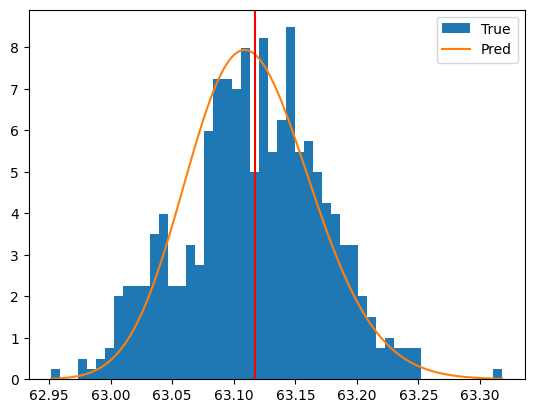

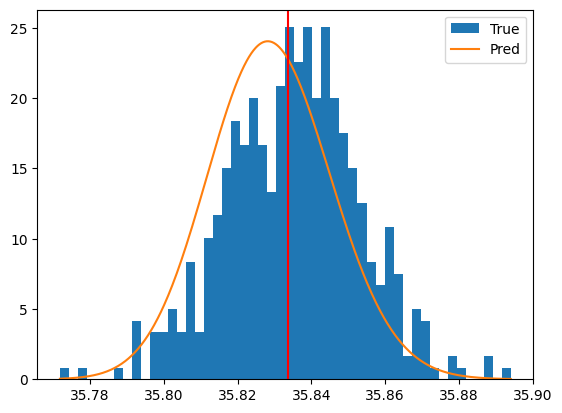

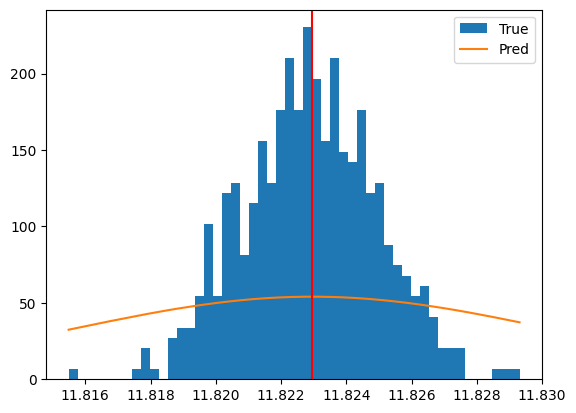

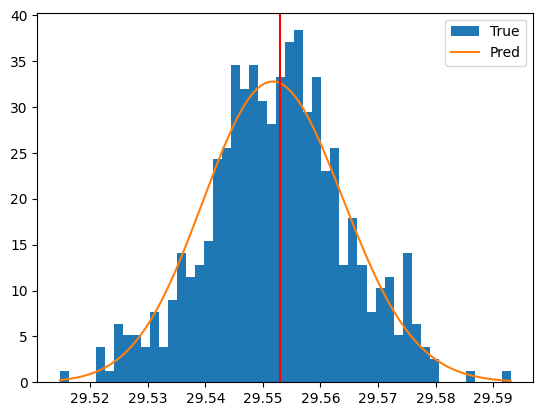

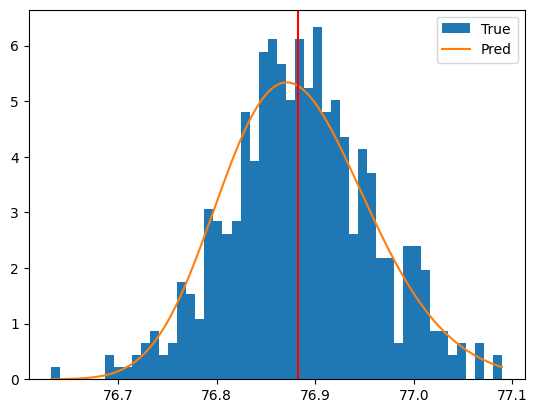

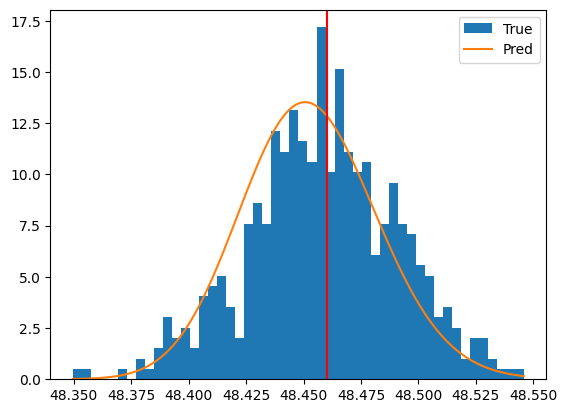

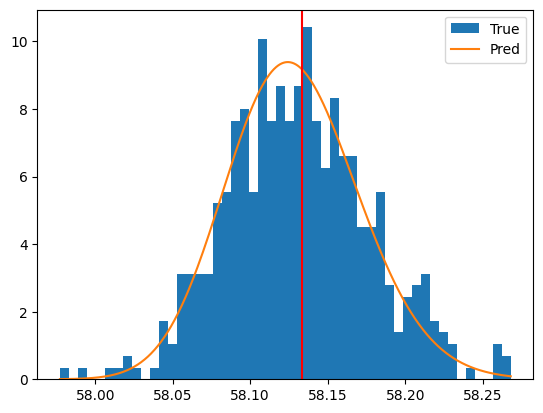

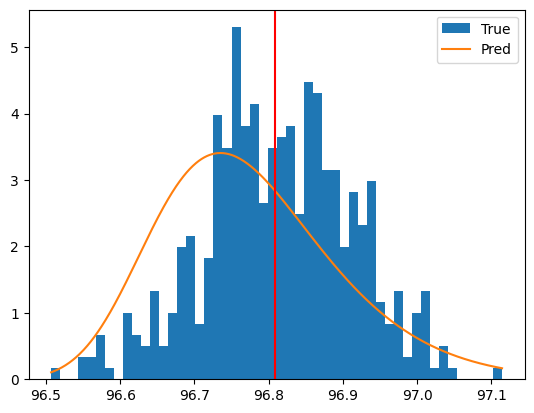

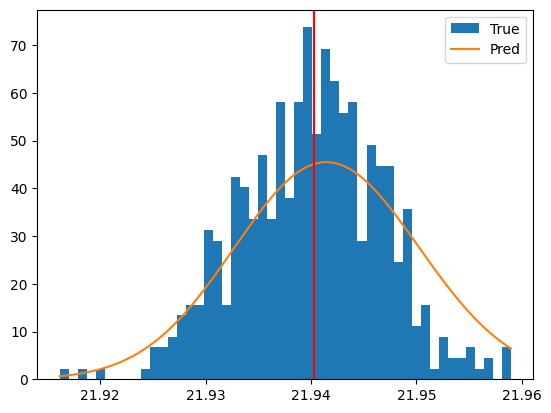

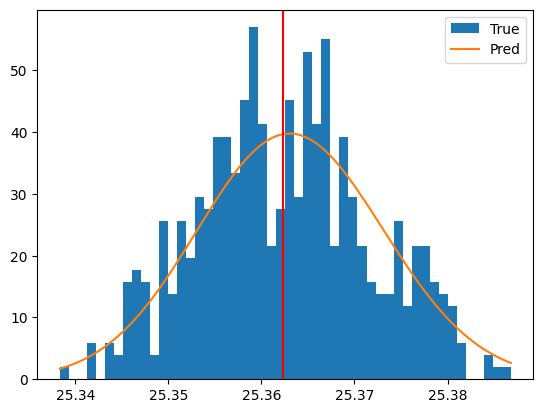

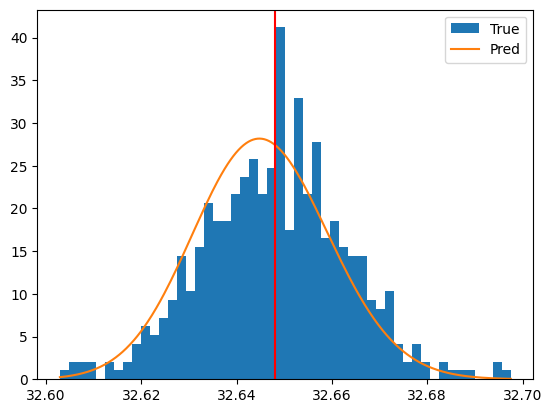

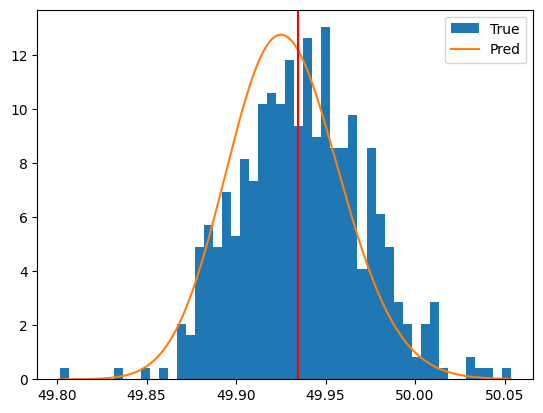

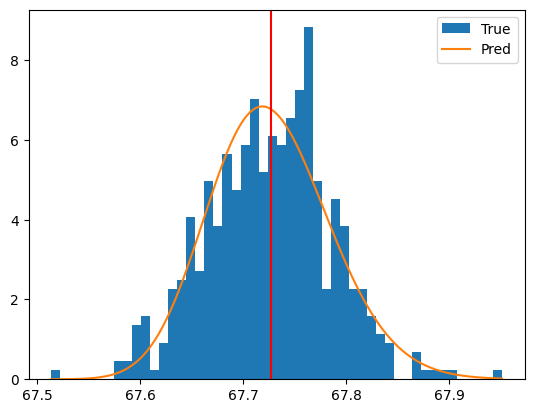

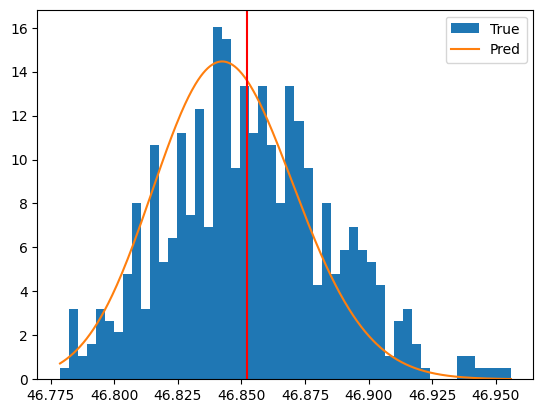

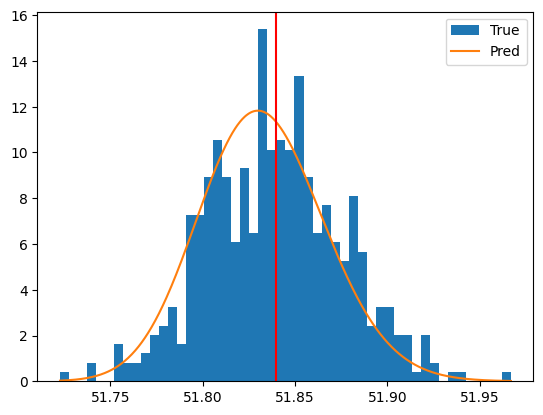

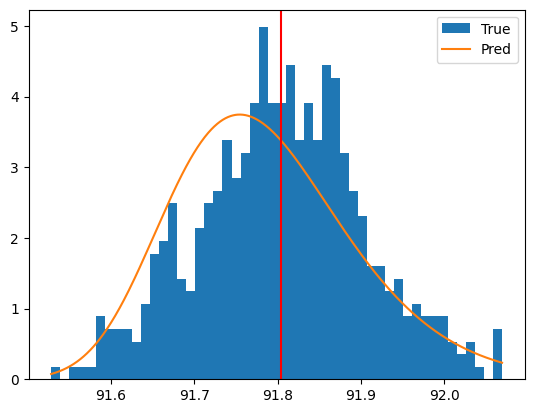

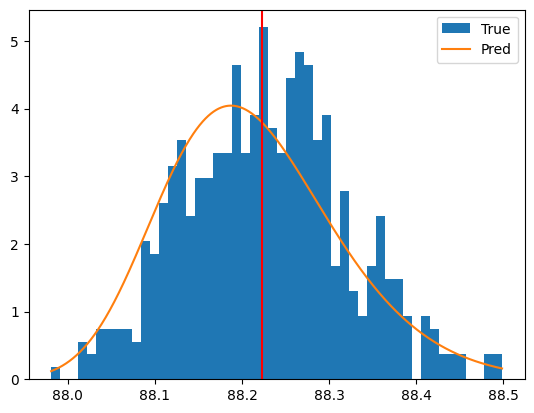

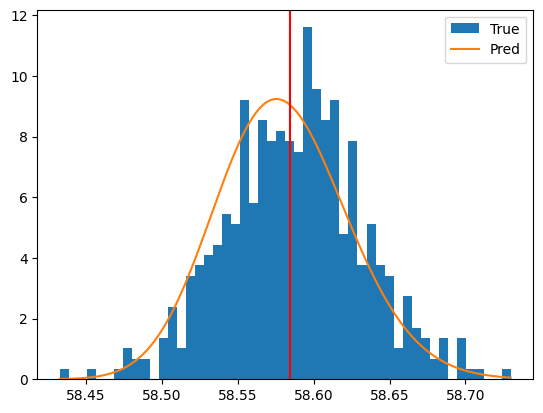

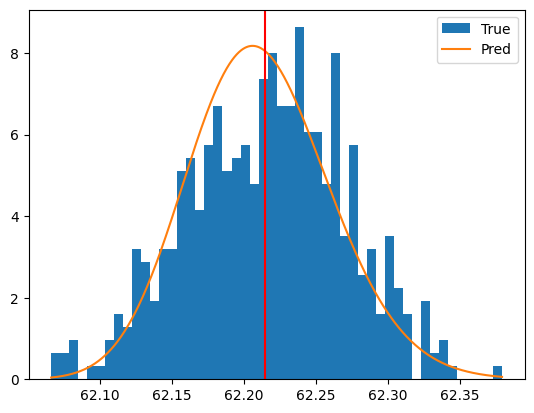

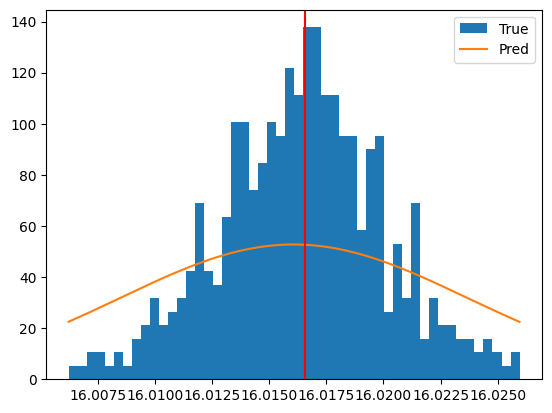

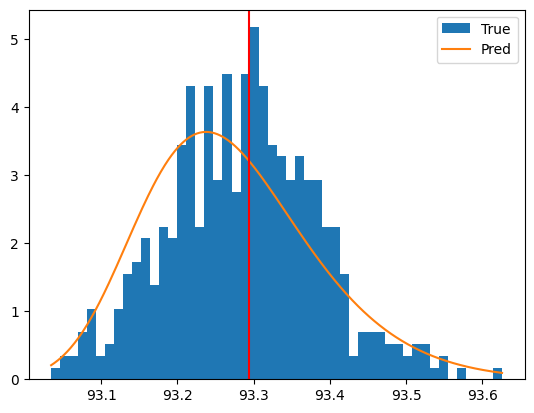

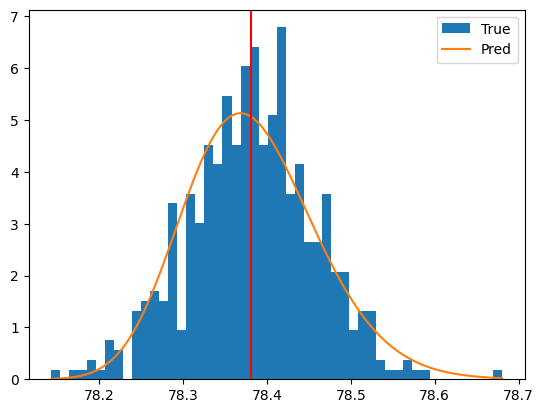

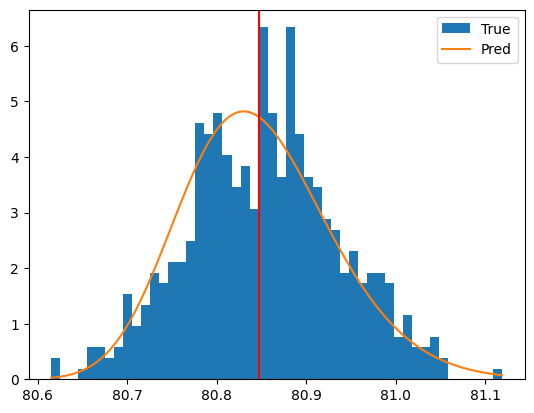

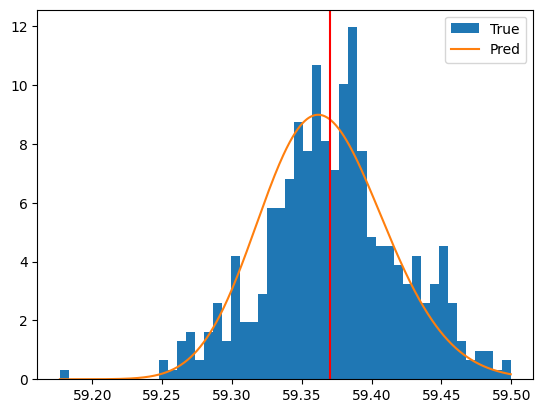

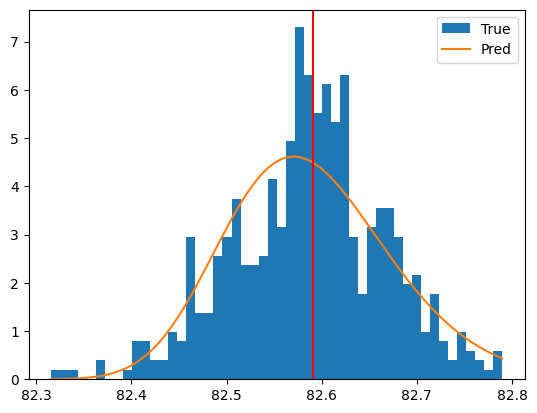

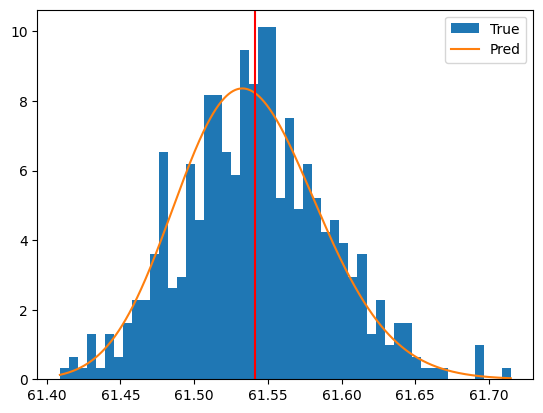

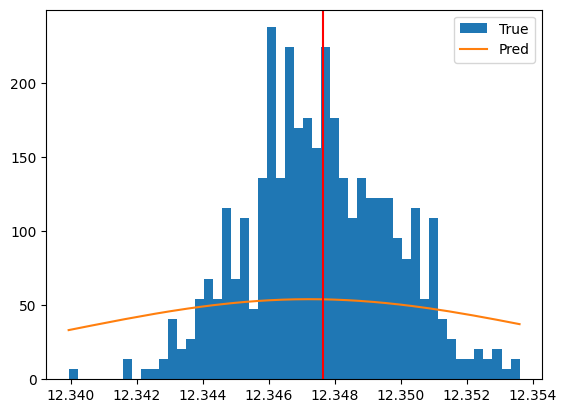

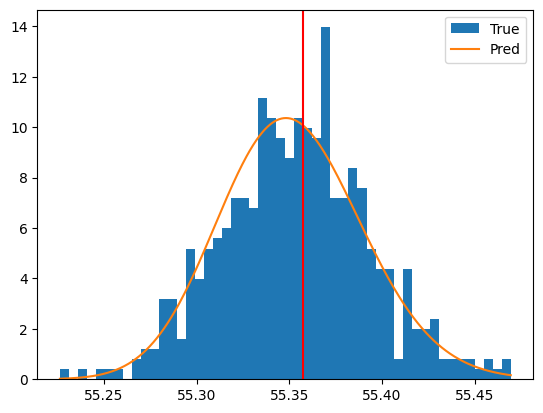

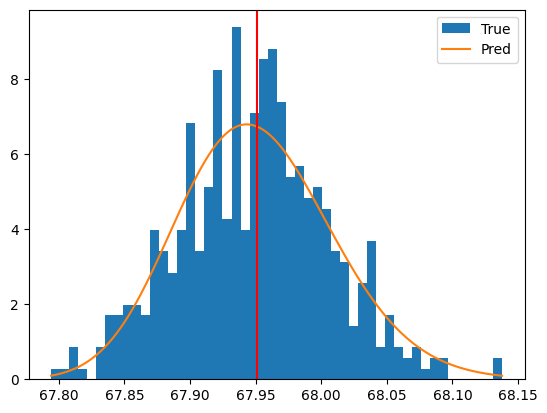

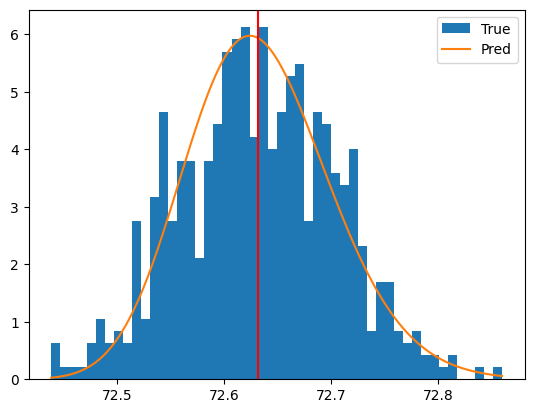

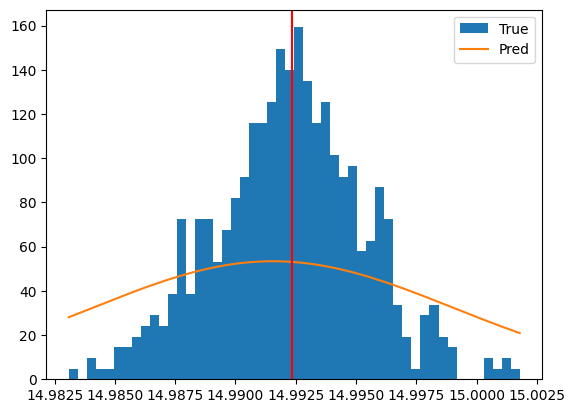

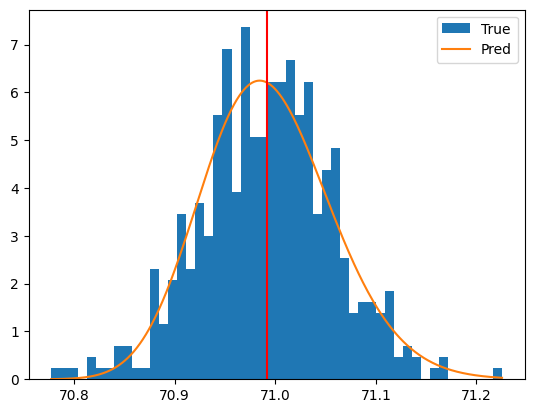

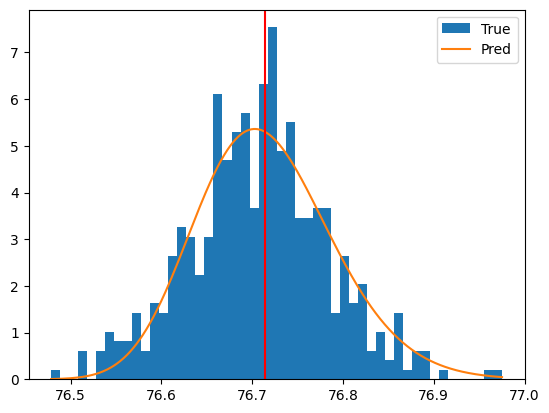

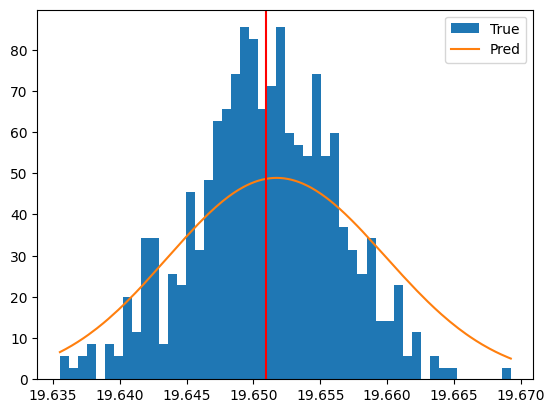

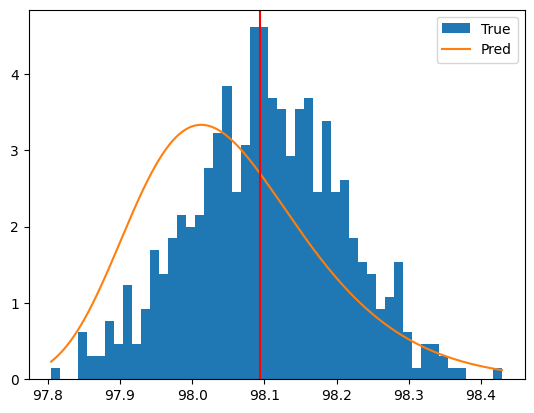

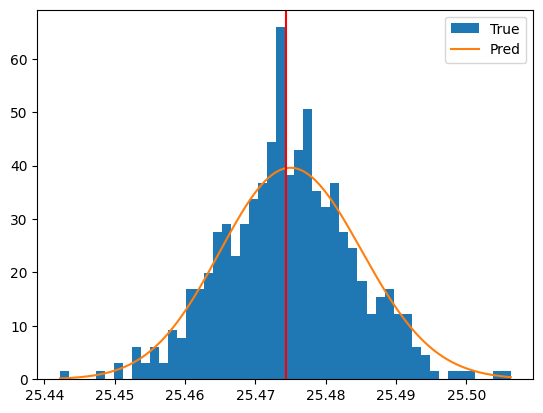

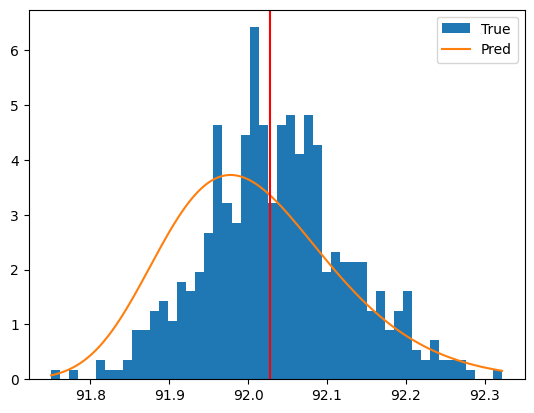

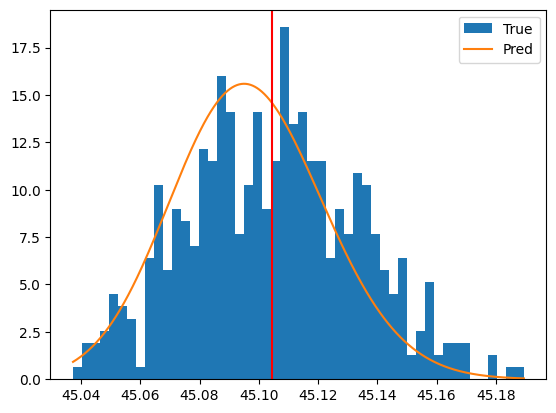

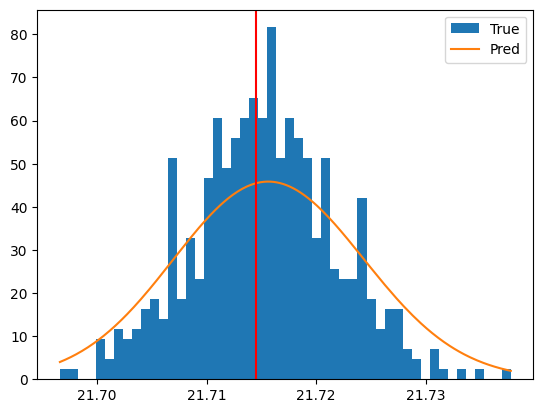

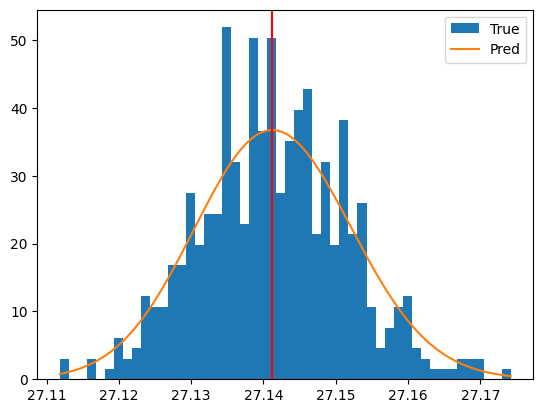

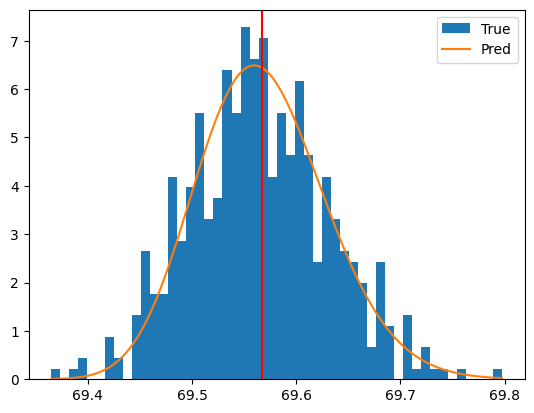

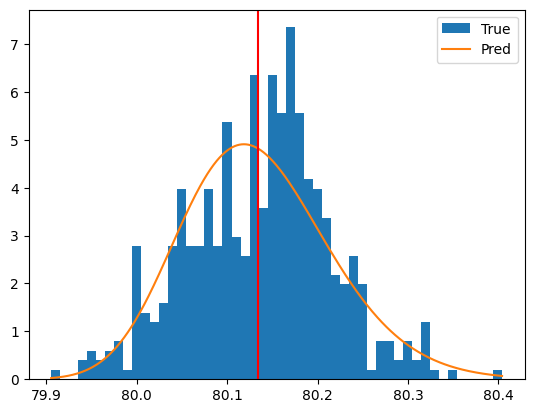

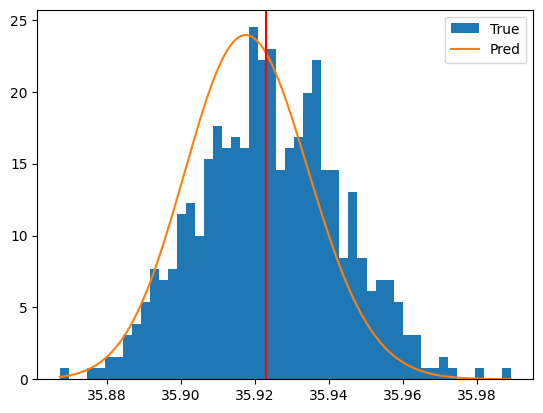

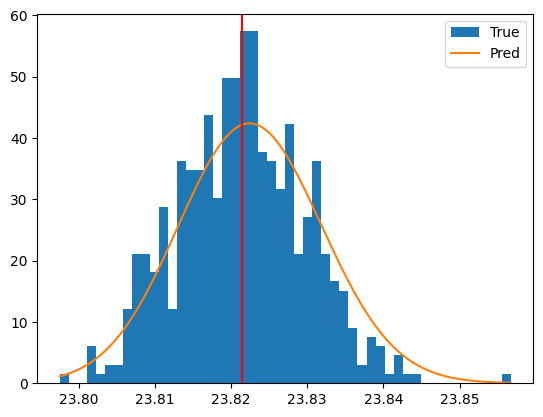

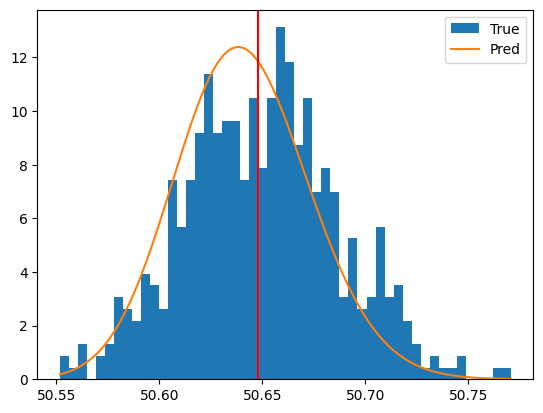

In [18]:
bounded_flow = Transformed(flow, Invert(preprocess))

for p, t in zip(posteriors, true):

    plt.hist(p, bins=50, density=True, label='True')

    xx = jnp.linspace(p.min(), p.max(), 1_000)
    pred = jnp.exp(bounded_flow.log_prob(xx[:, None], jnp.array([t])))
    plt.plot(xx, pred, label='Pred')

    plt.axvline(t, c='r')

    plt.legend()
    plt.show()

In [19]:
key, key_ = jax.random.split(key)

base = Normal(
    loc=jnp.zeros(dim),
    scale=jnp.ones(dim),
    )

flow = BlockNeuralAutoregressiveFlow(
    key=key_,
    base_dist=base,
    cond_dim=cond_dim,
    nn_depth=1,
    nn_block_dim=10,
    flow_layers=1,
    invert=True,
    # activation=,
    )

postprocess = OnePlusELU(shape=(1,))
flow = Transformed(flow, postprocess)

In [24]:
key, key_ = jax.random.split(key)
flow, losses = fit_to_data(
    key=key_,
    dist=flow,
    x=x,
    condition=c,
    loss_fn=None,
    max_epochs=1_000,
    max_patience=10,
    batch_size=1_000,
    val_prop=0.1,
    learning_rate=1e-3,
    optimizer=None,
    # filter_spec: Callable | PyTree = eqx.is_inexact_array,
    show_progress=True,
    )

 22%|▋  | 219/1000 [00:56<03:20,  3.89it/s, train=-2.0298676, val=-2.0463111 (Max patience reached)]


(-5.0, 5.0)

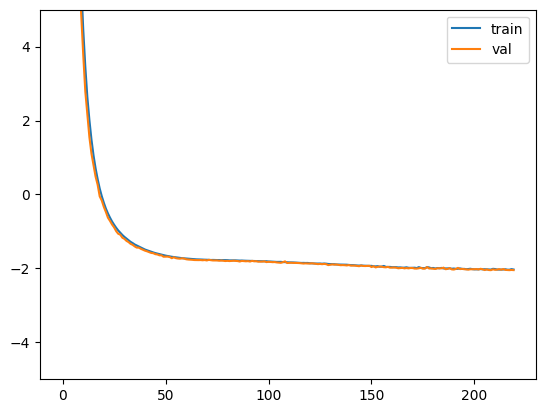

In [29]:
for label, loss in losses.items():
    plt.plot(loss, label=label)
plt.legend();
plt.ylim(-5, 5)

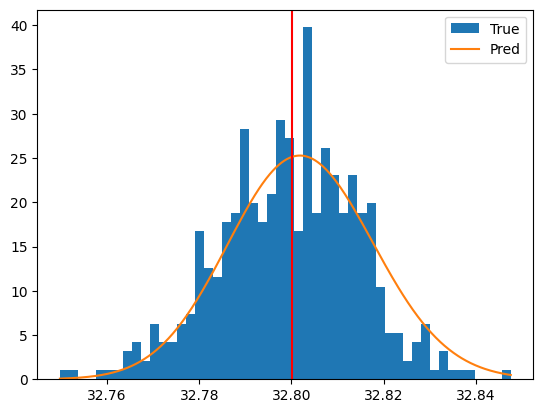

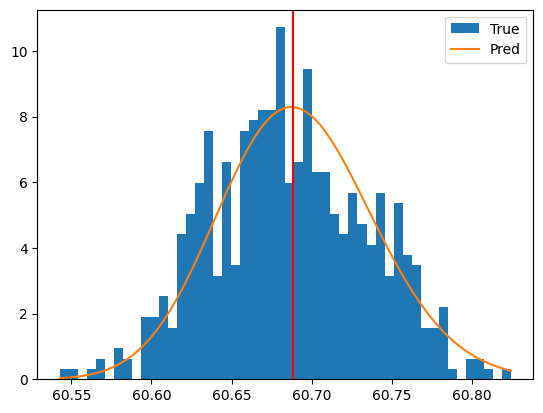

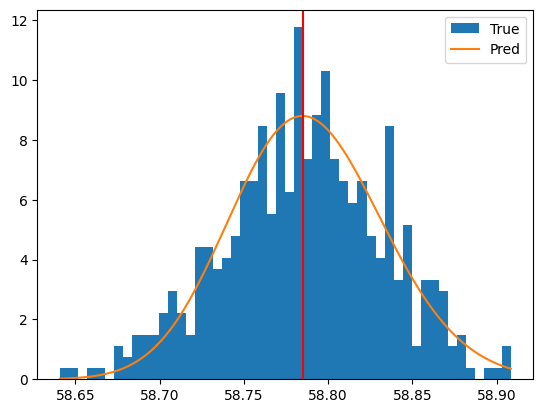

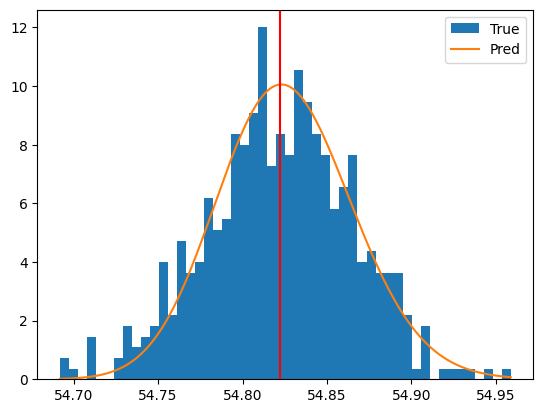

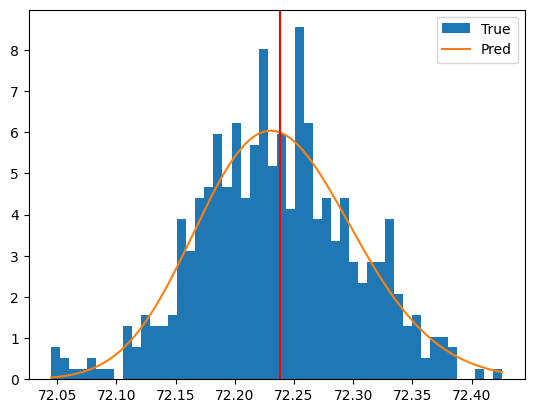

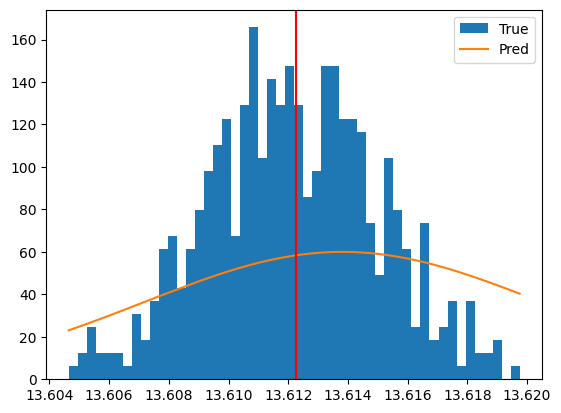

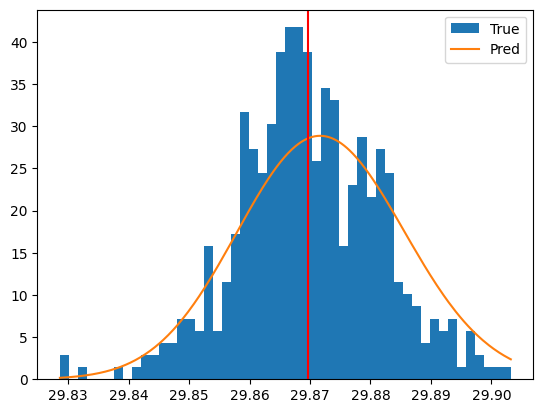

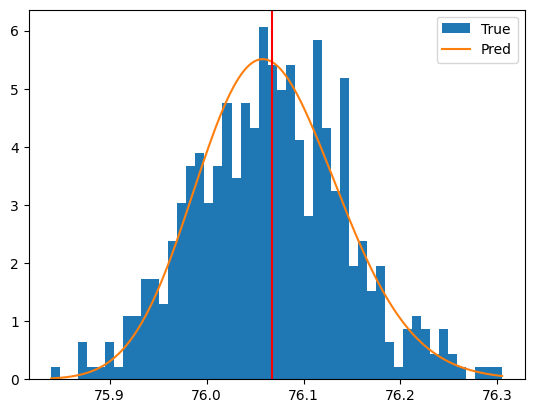

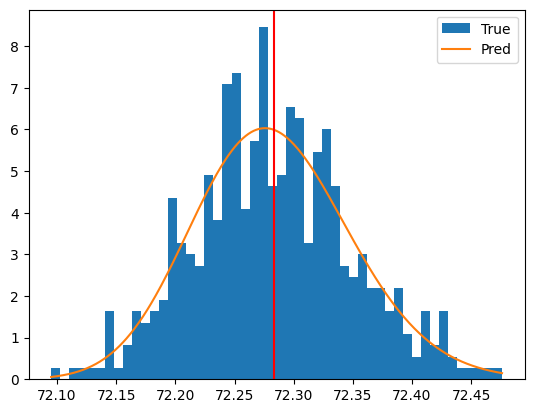

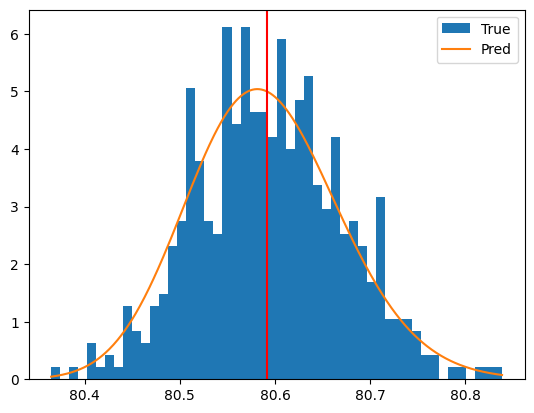

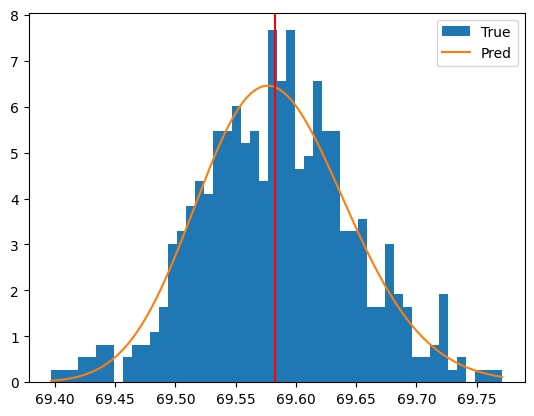

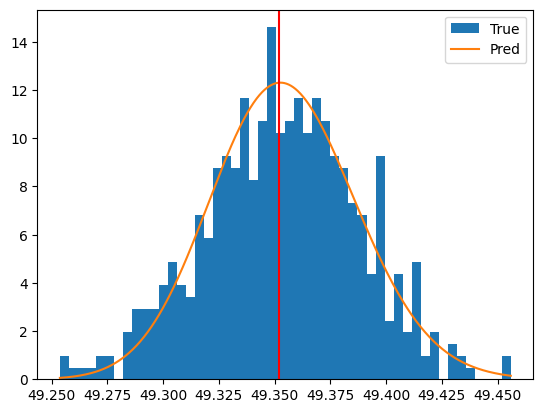

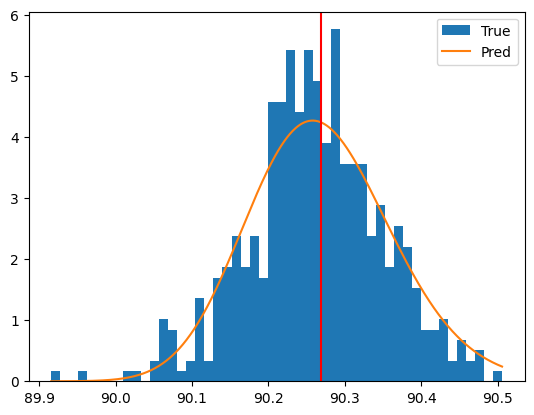

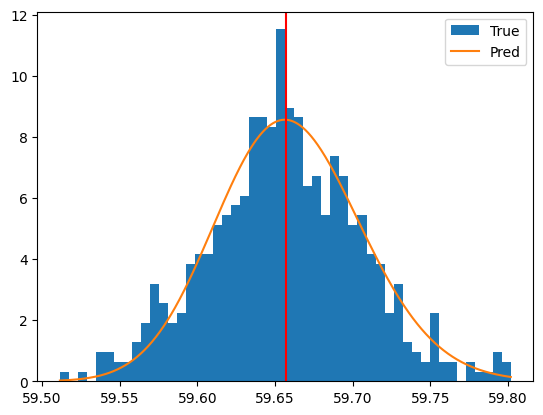

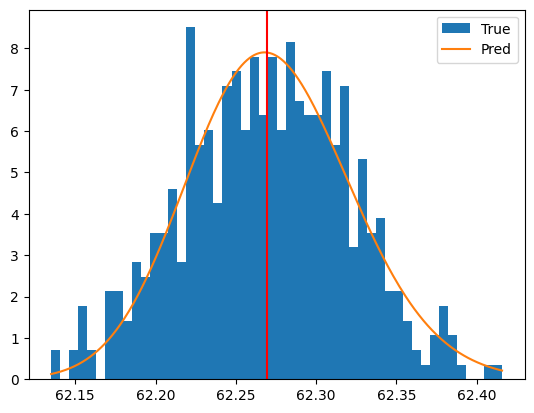

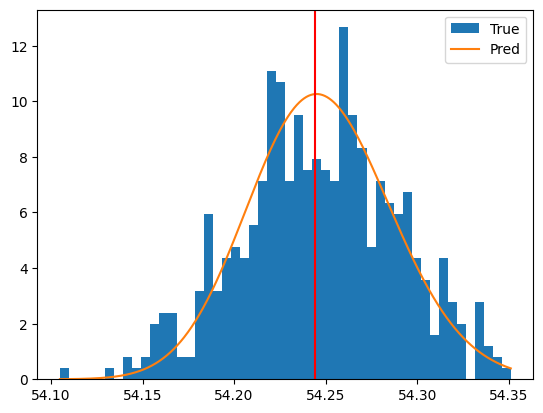

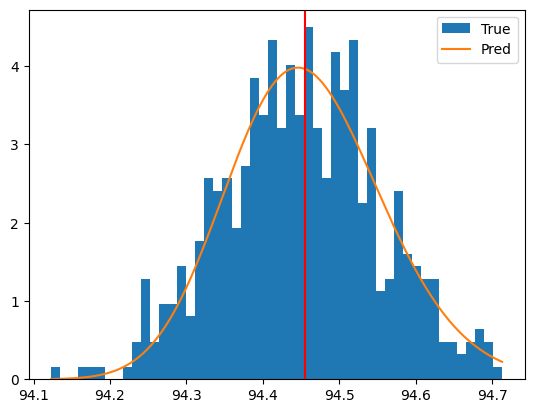

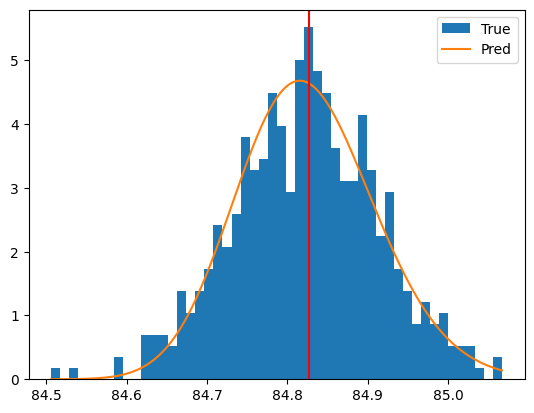

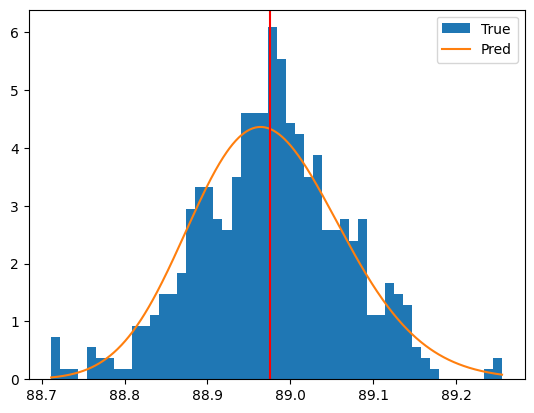

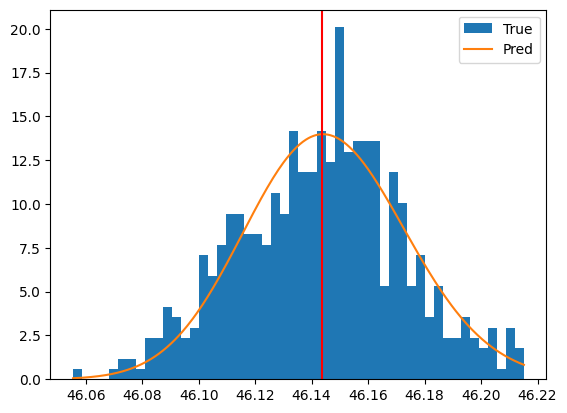

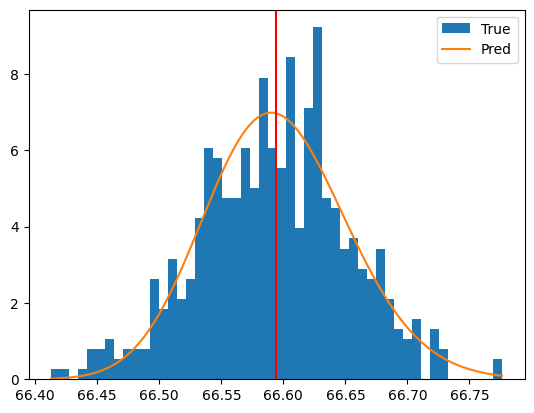

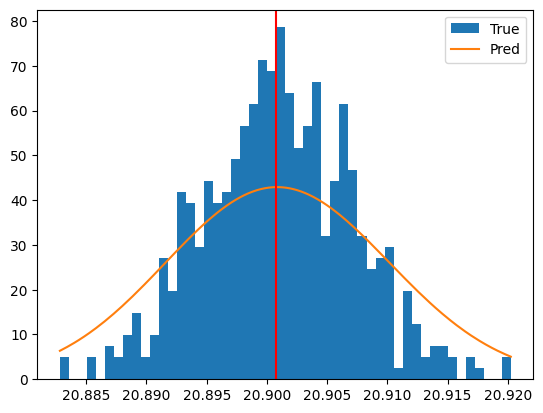

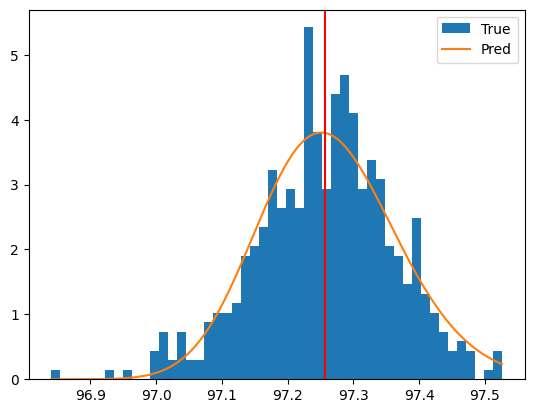

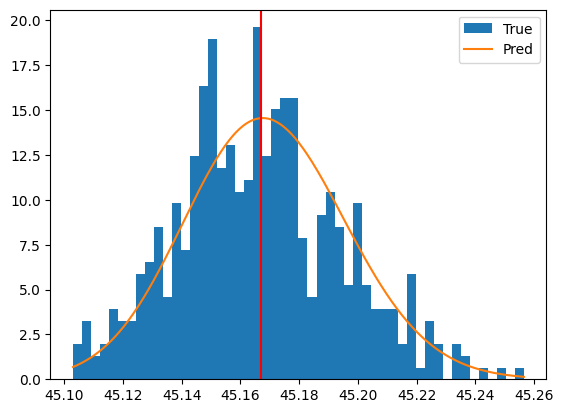

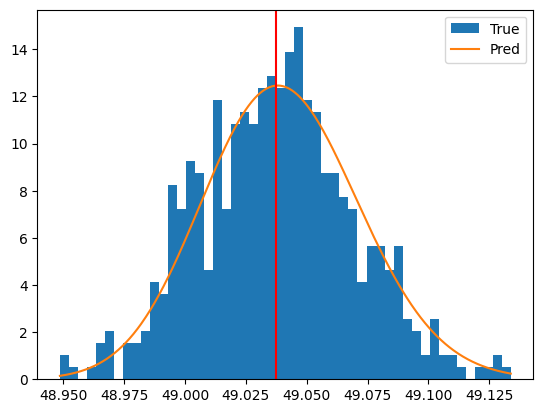

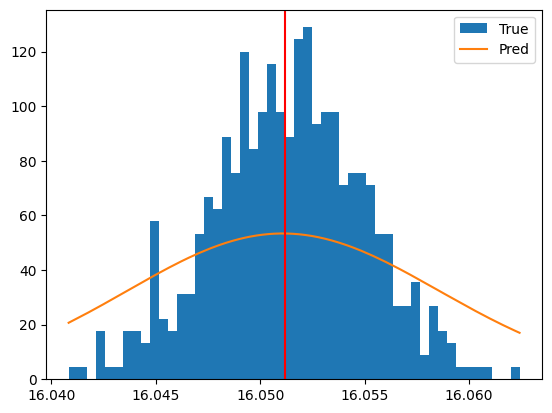

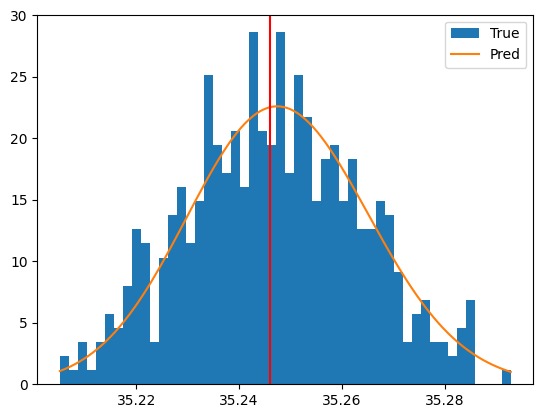

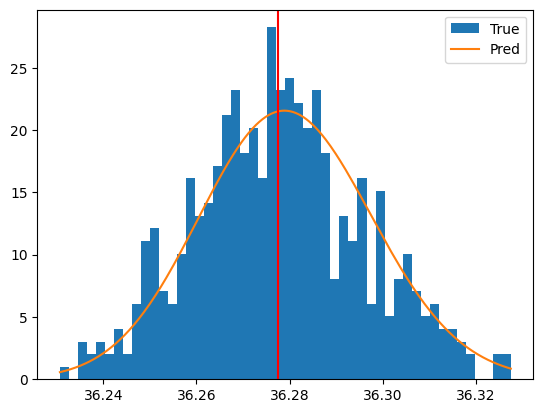

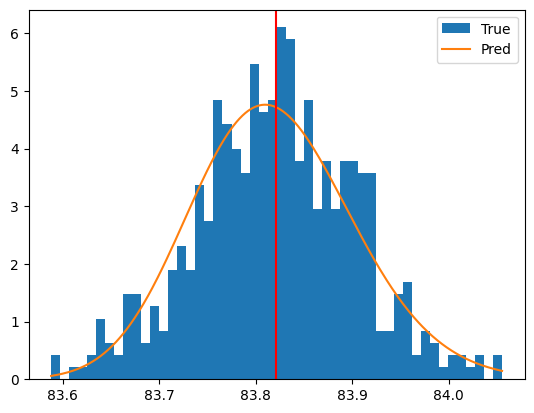

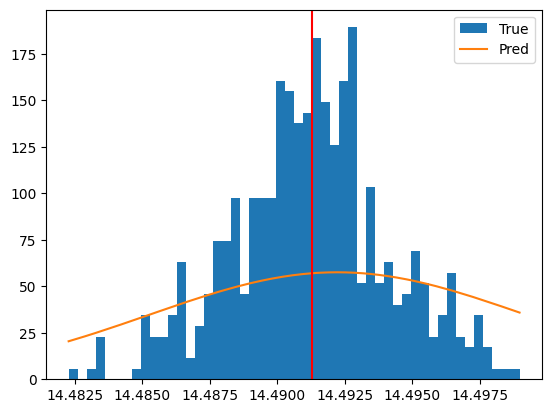

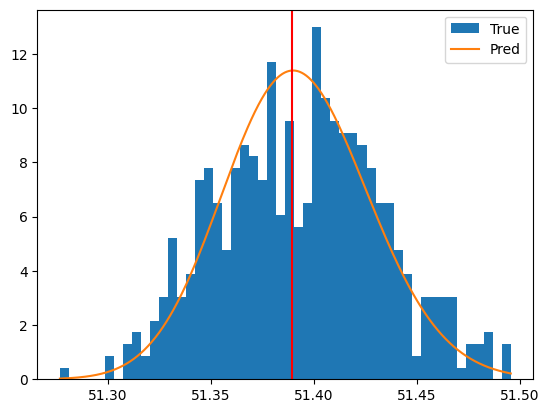

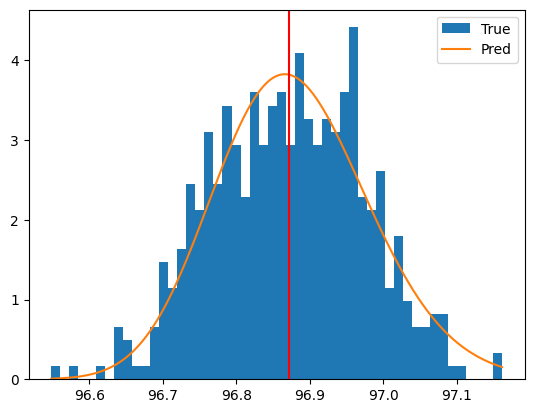

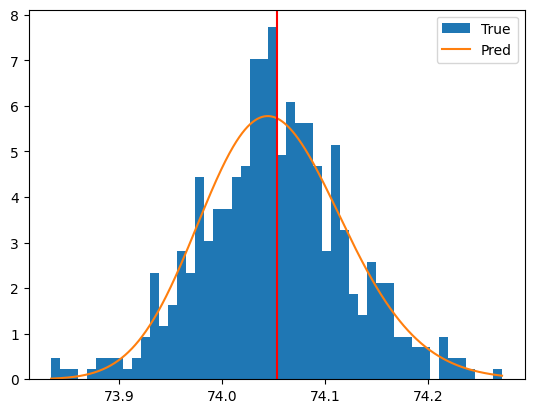

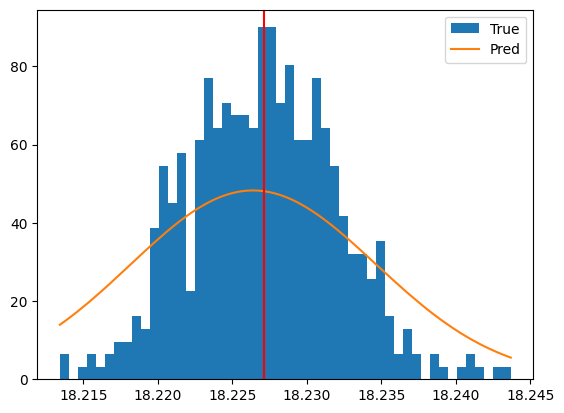

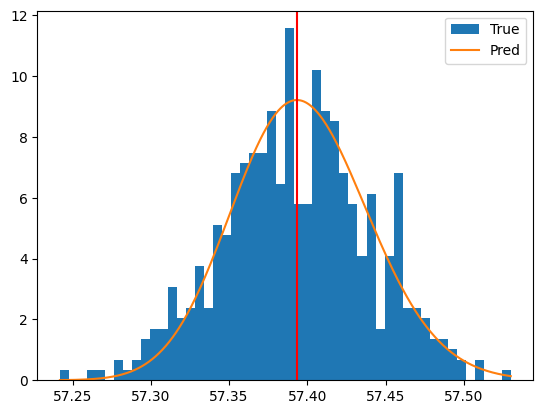

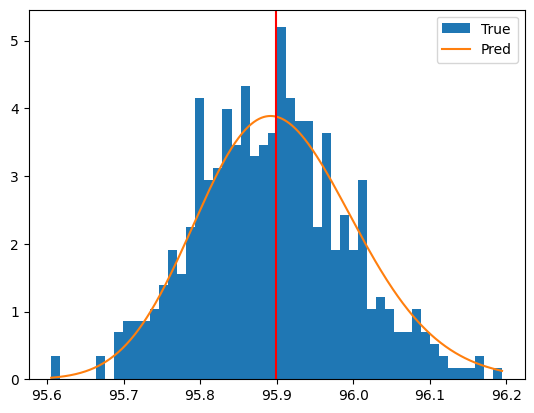

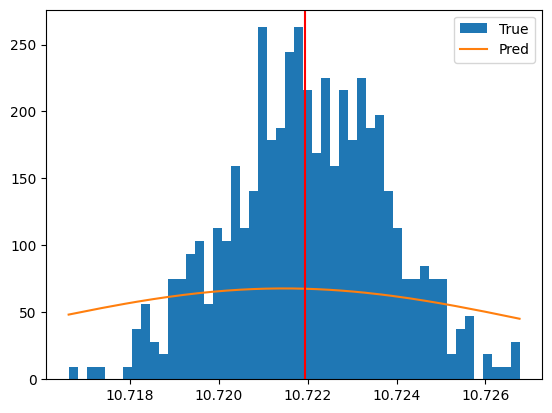

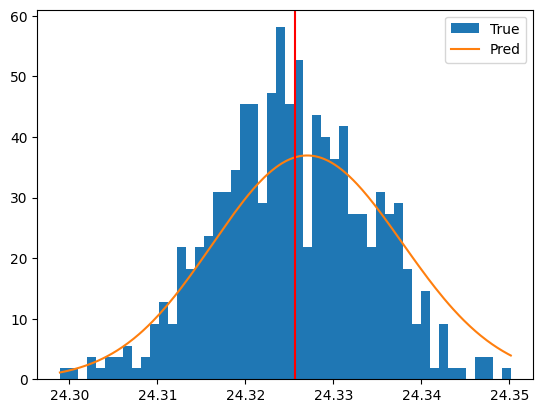

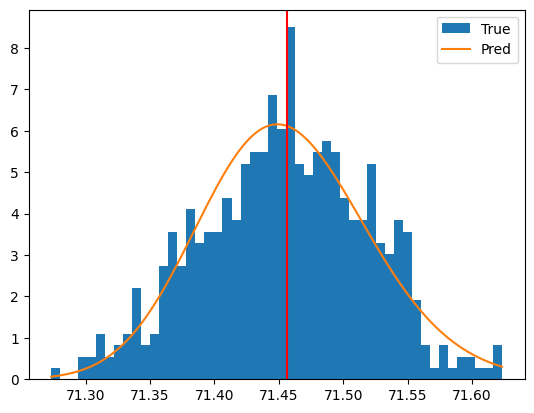

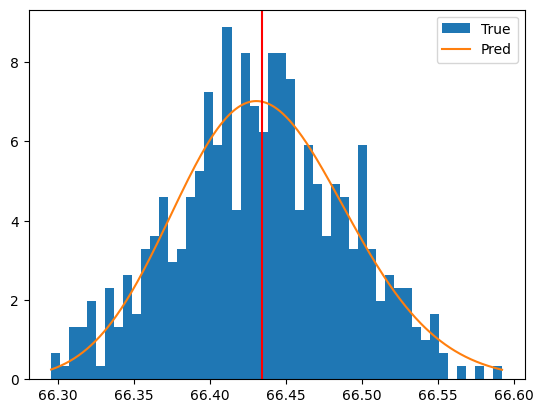

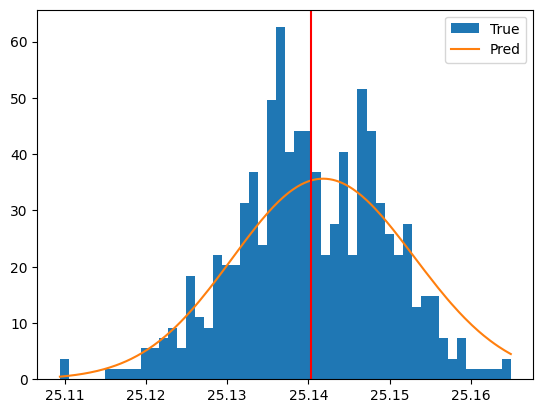

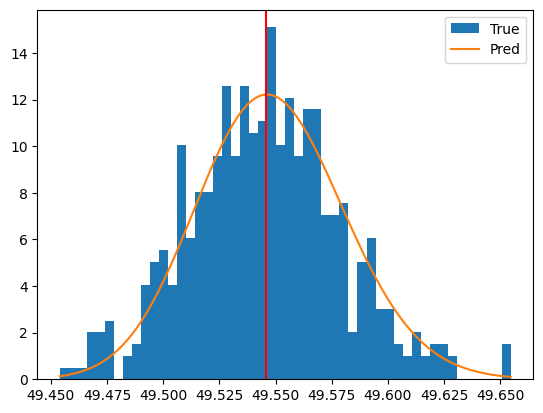

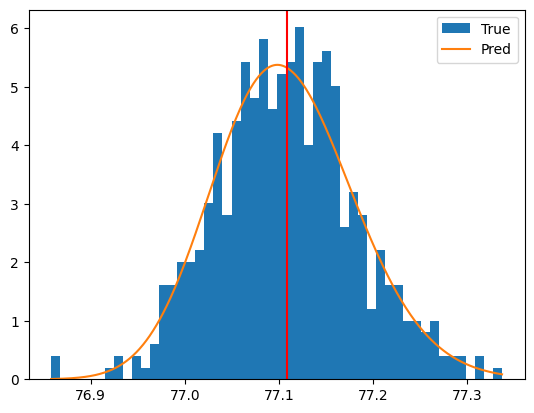

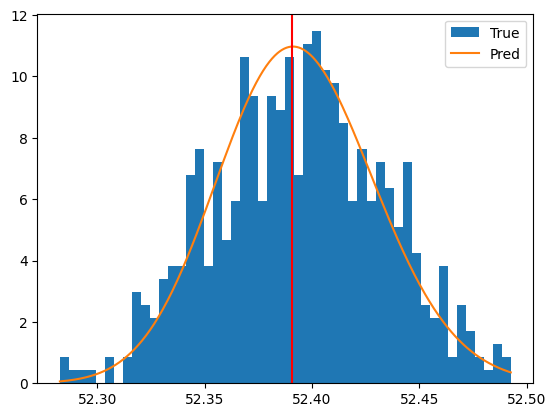

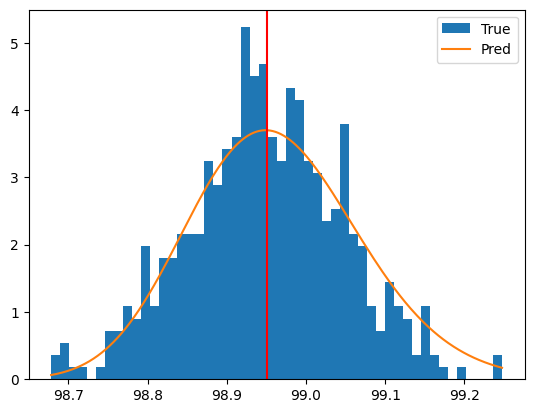

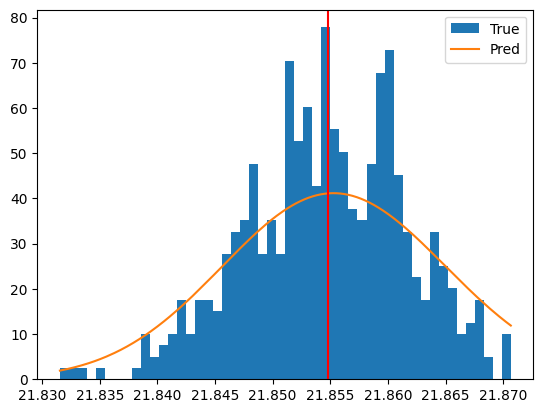

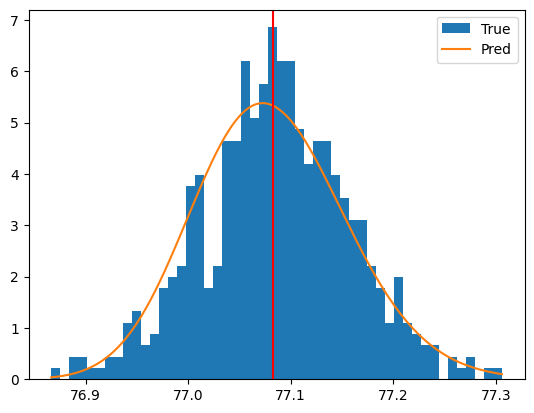

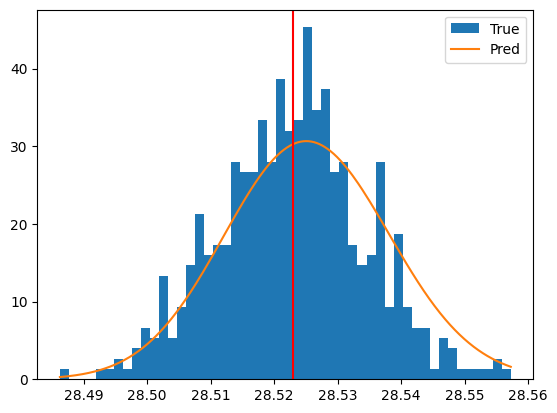

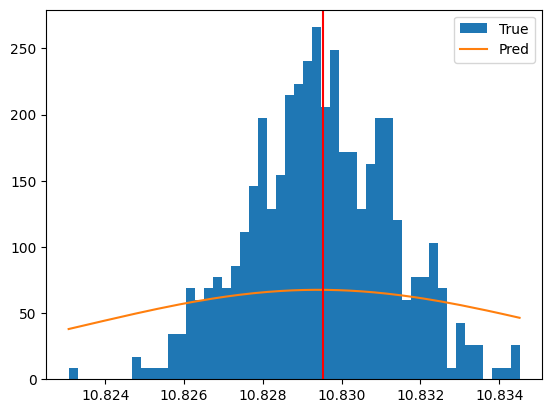

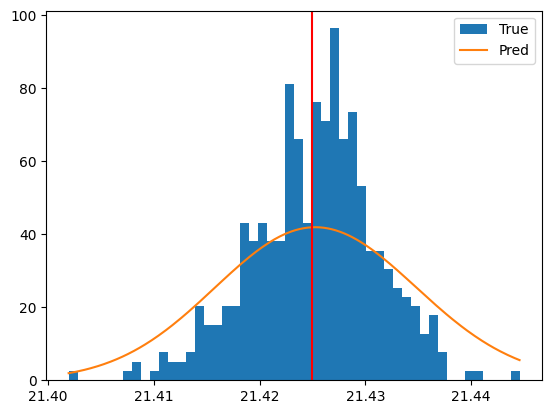

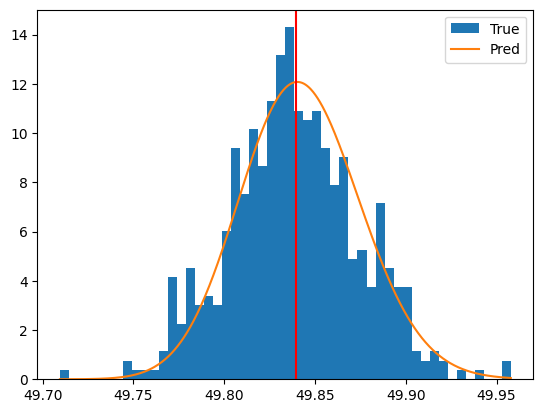

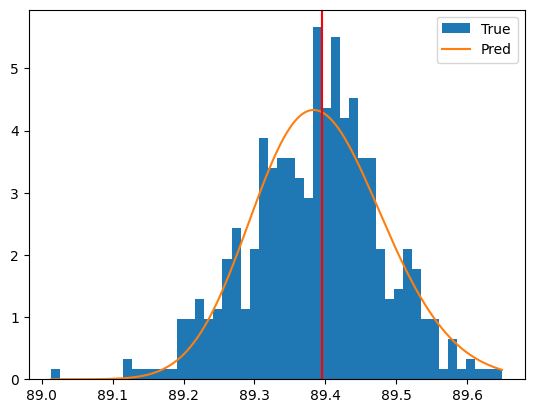

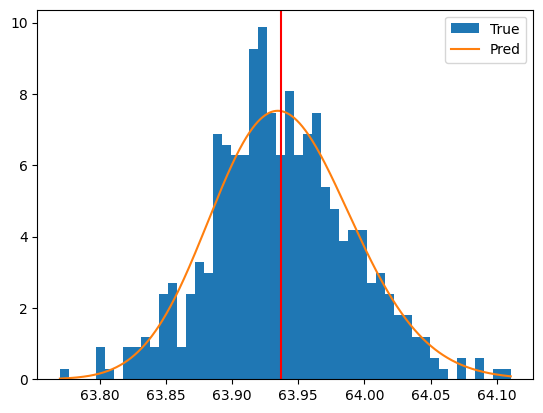

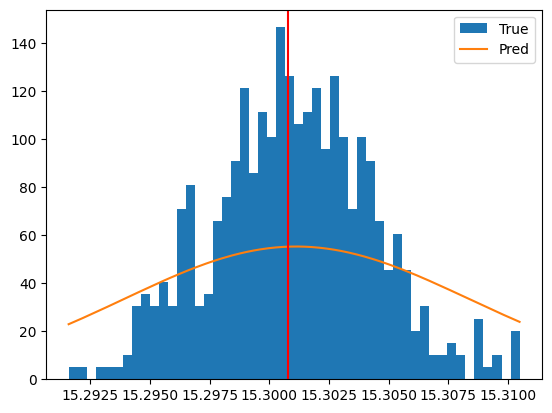

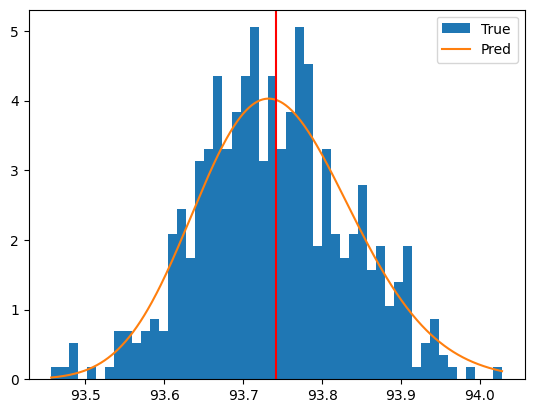

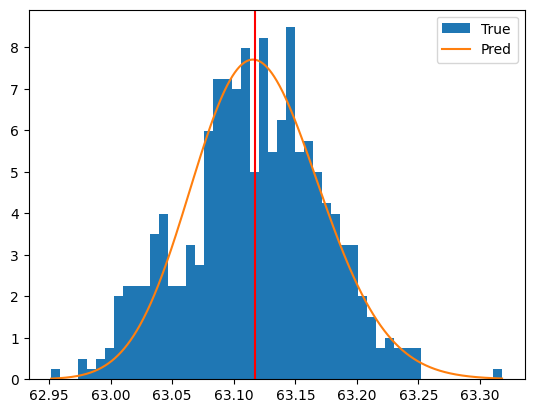

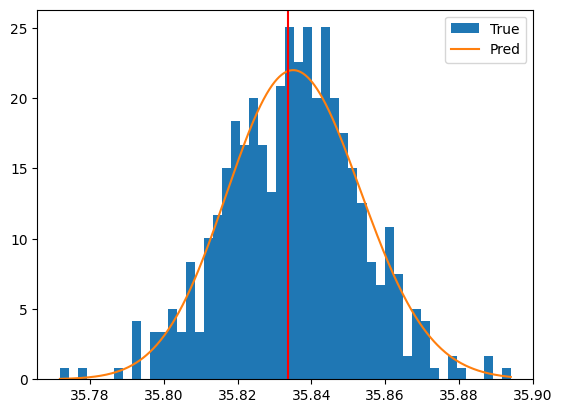

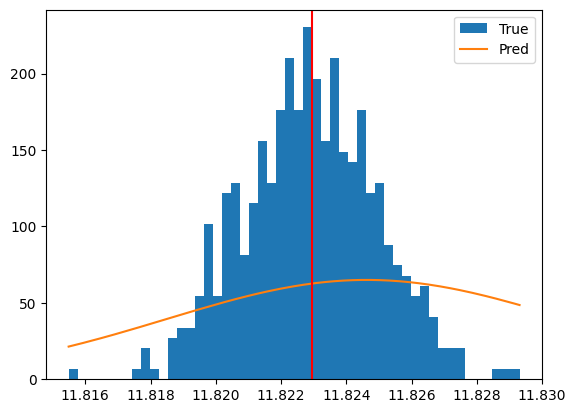

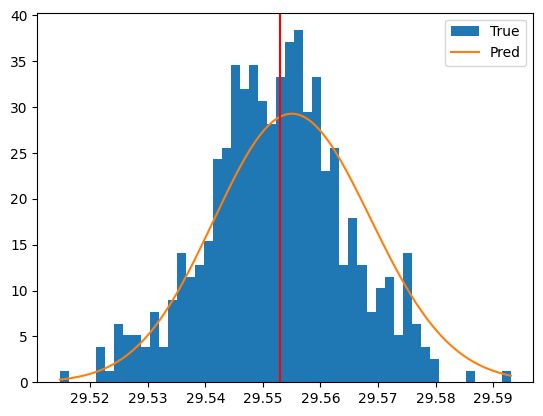

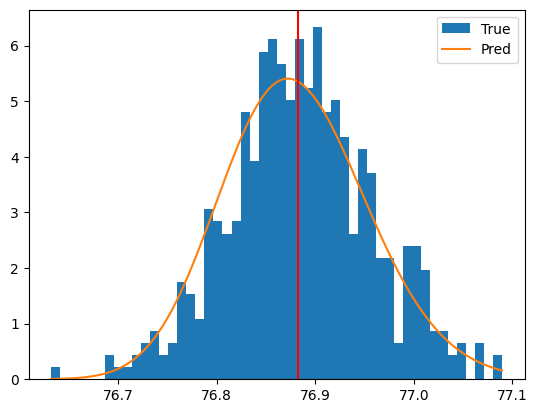

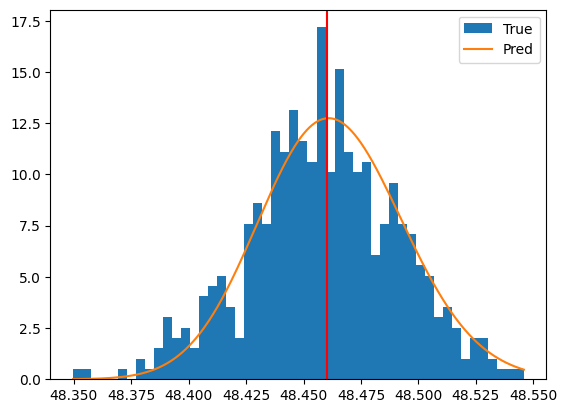

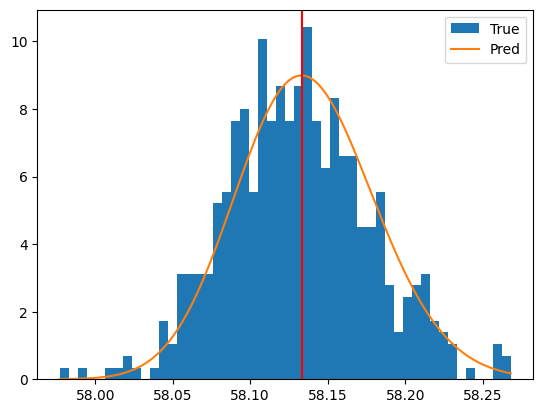

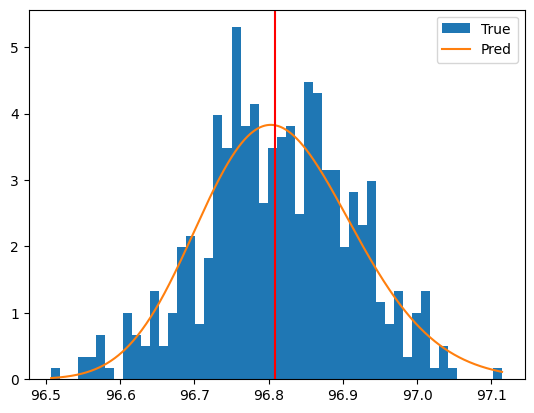

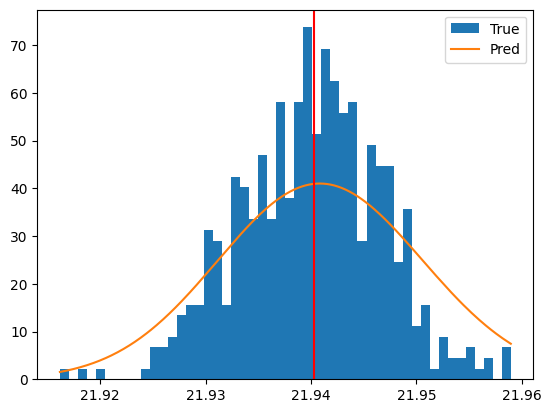

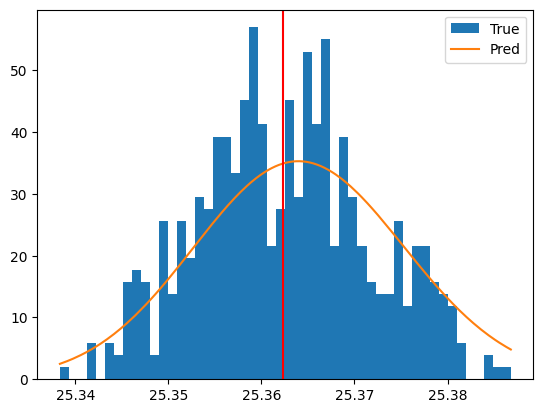

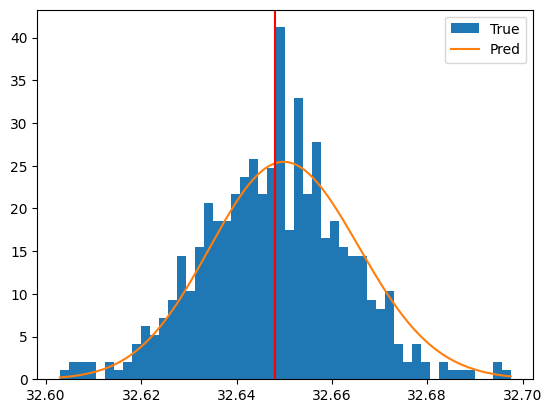

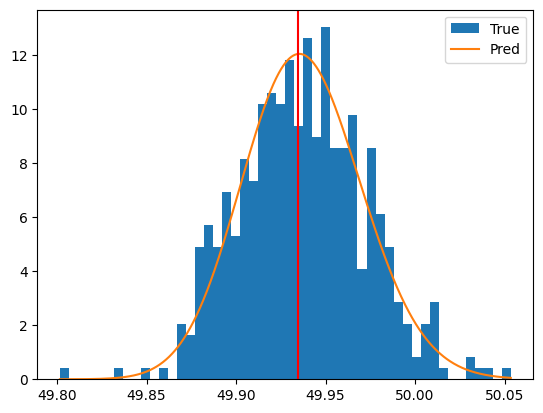

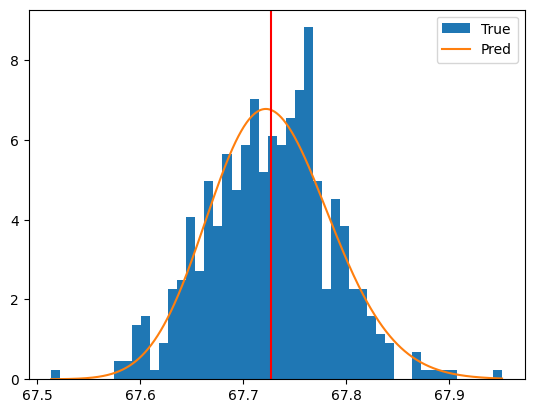

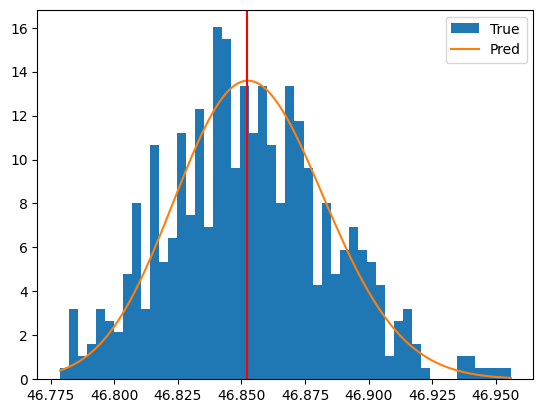

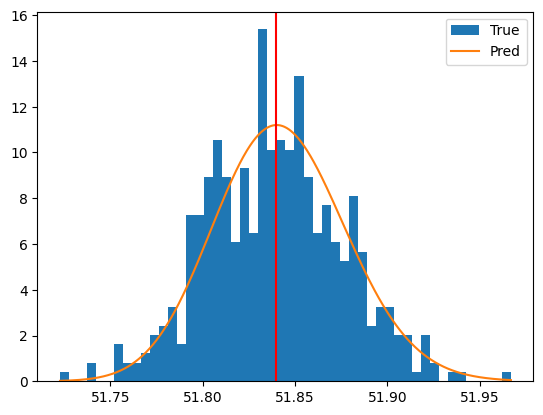

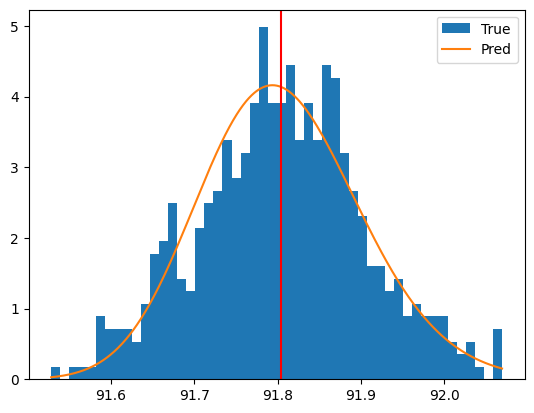

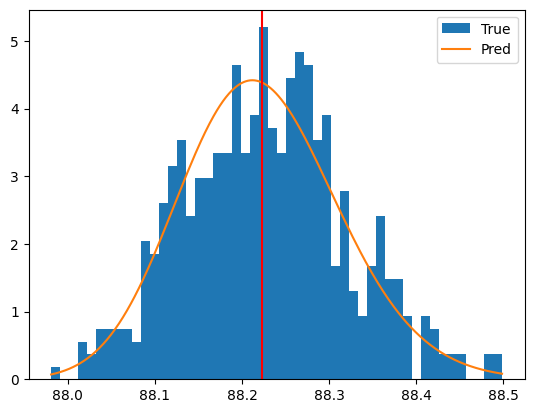

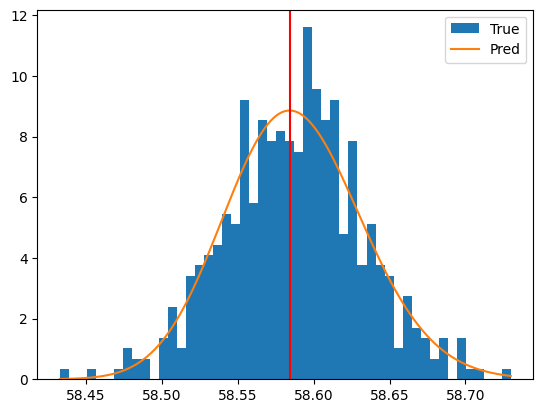

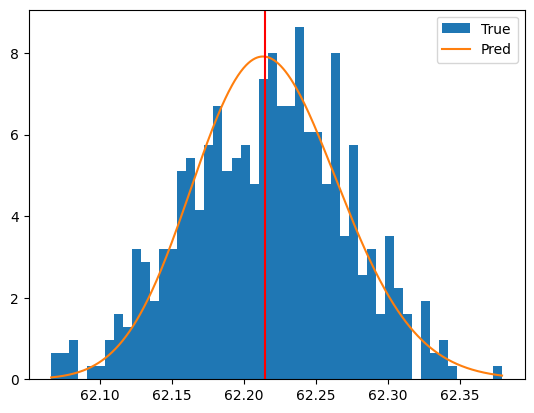

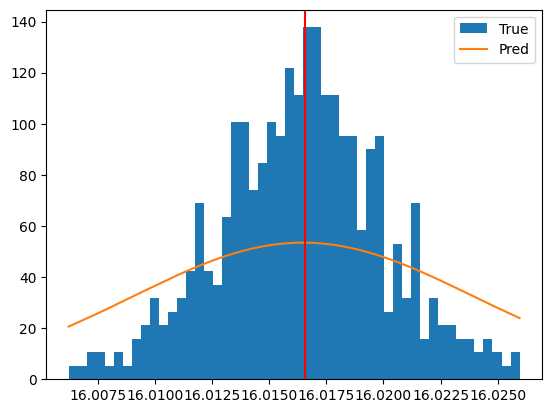

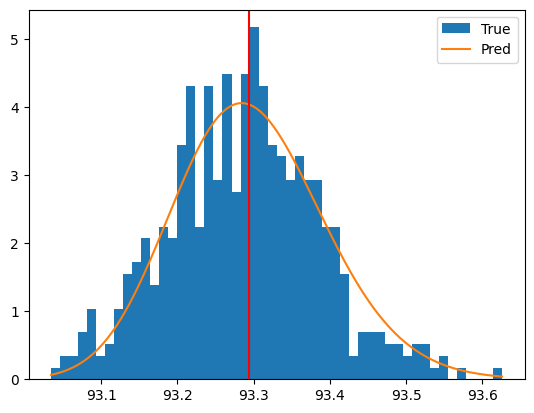

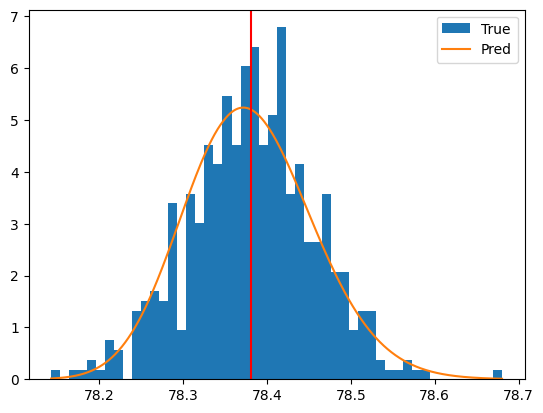

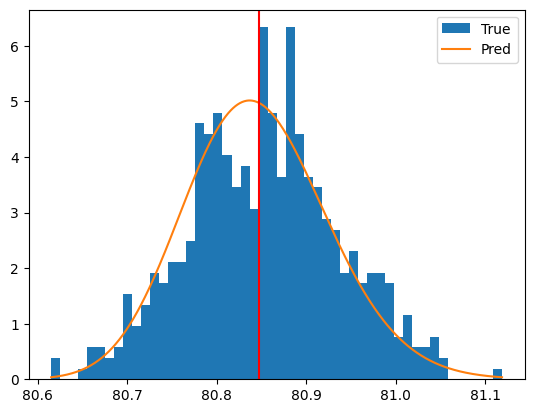

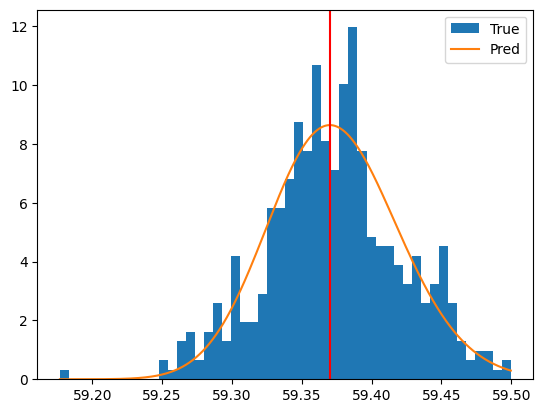

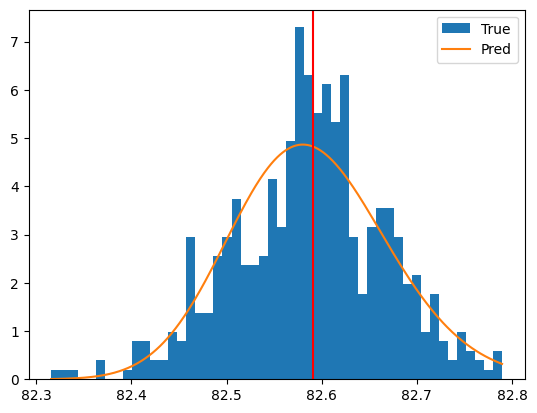

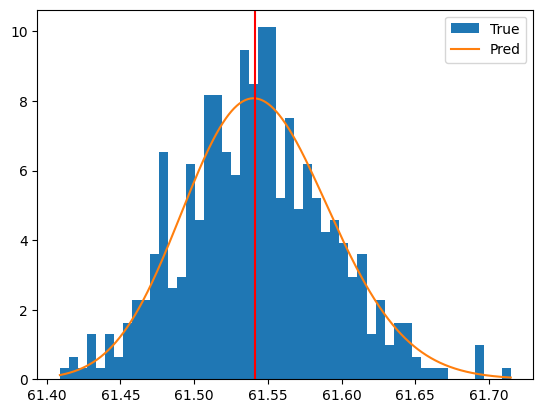

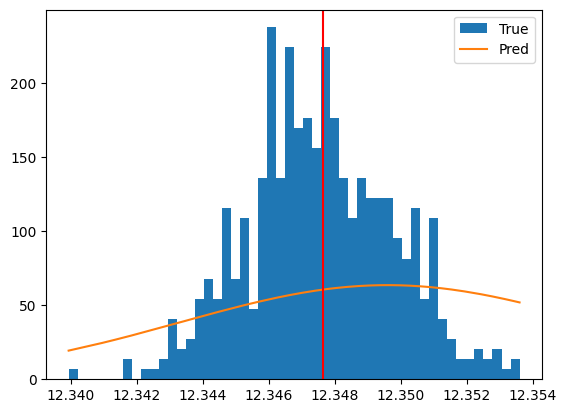

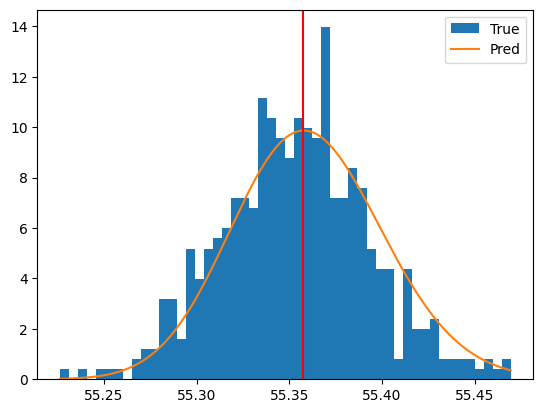

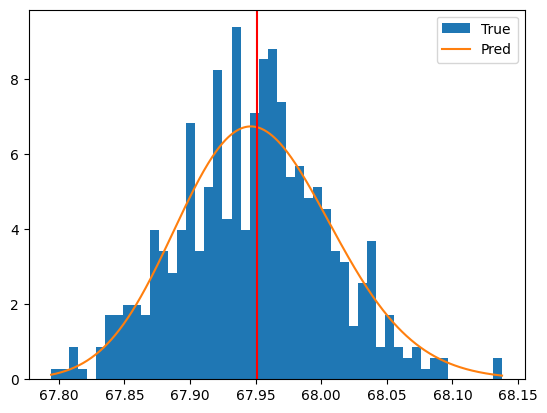

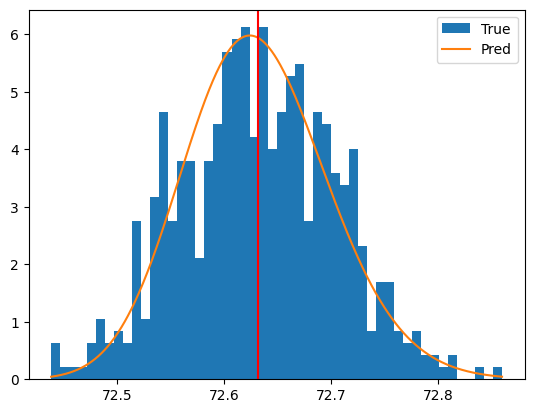

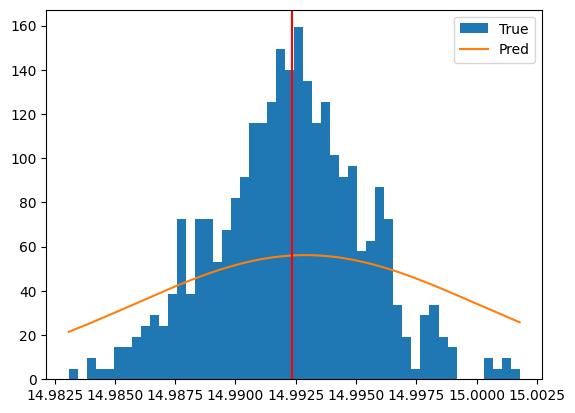

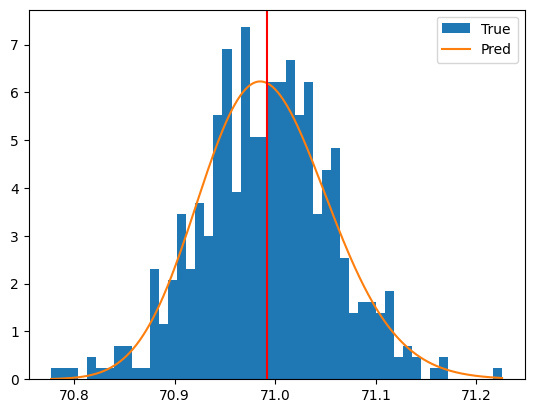

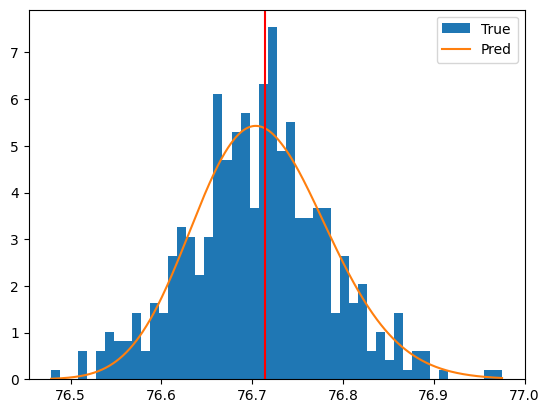

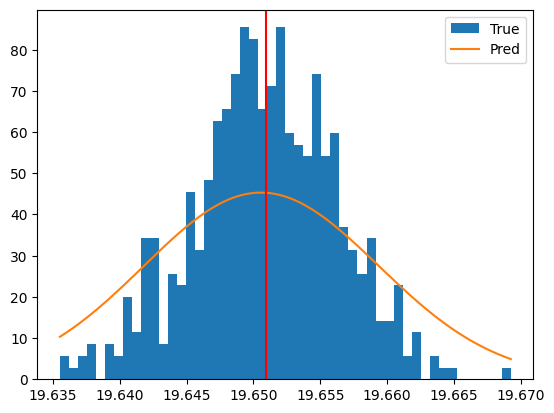

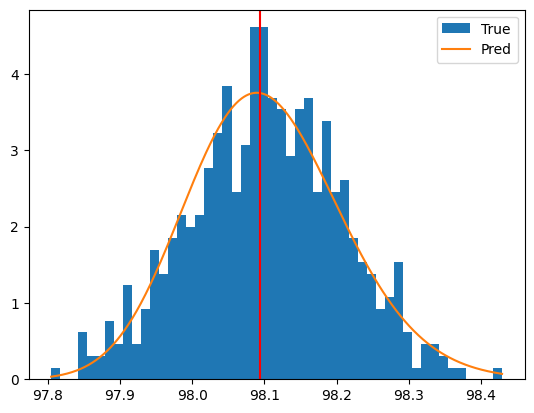

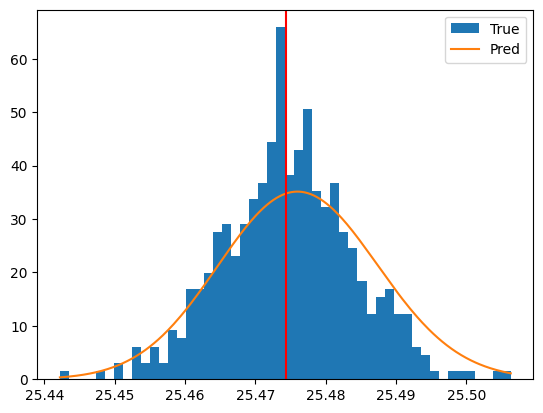

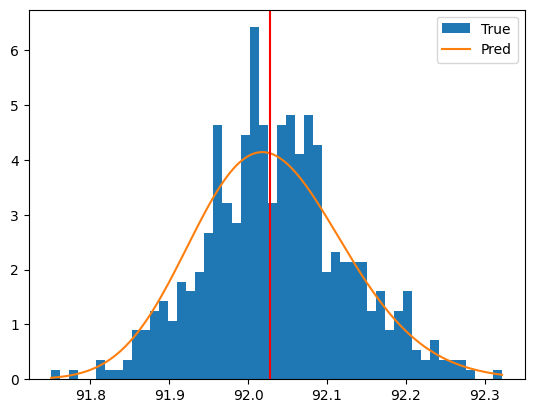

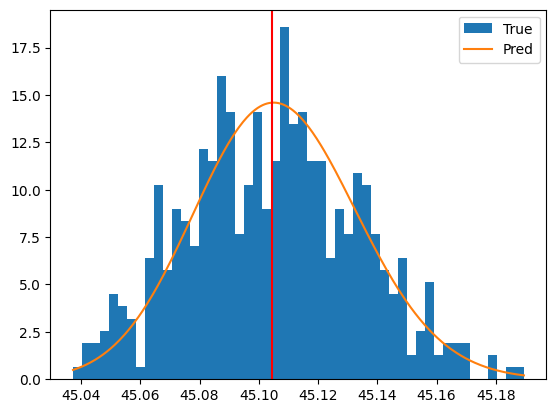

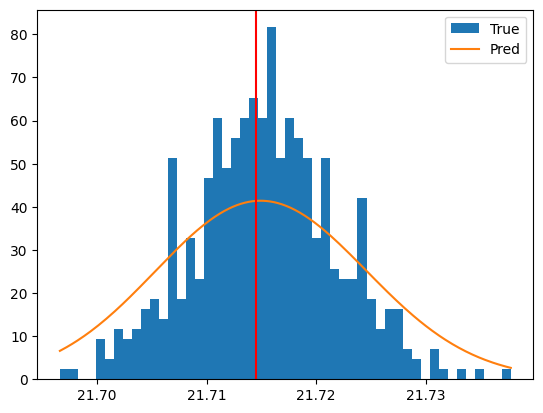

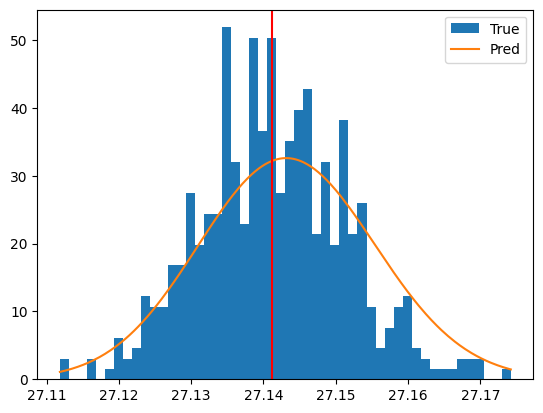

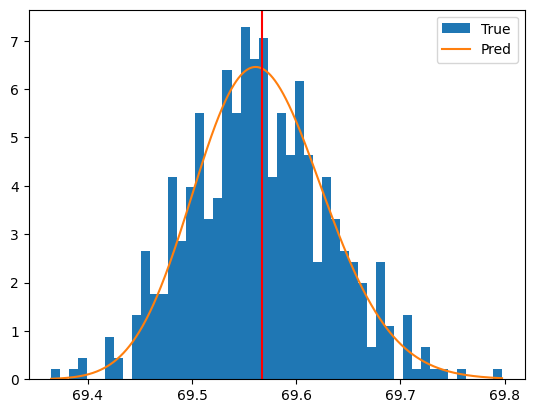

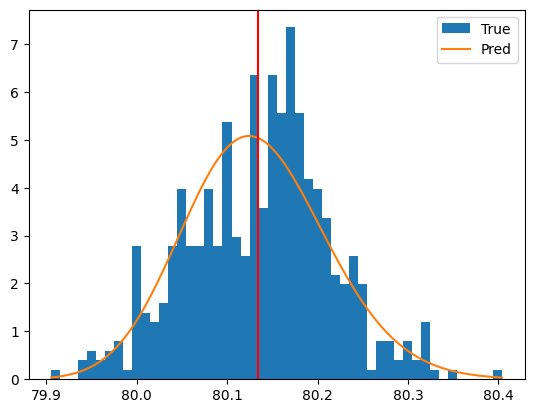

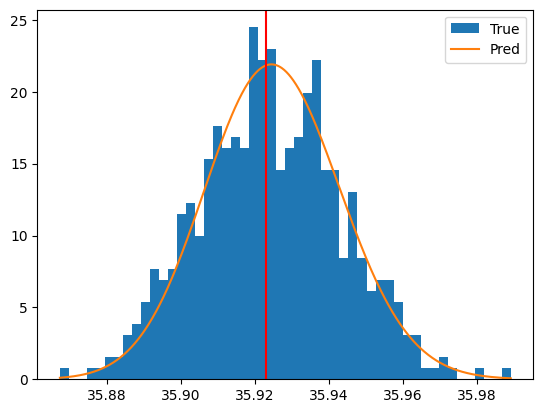

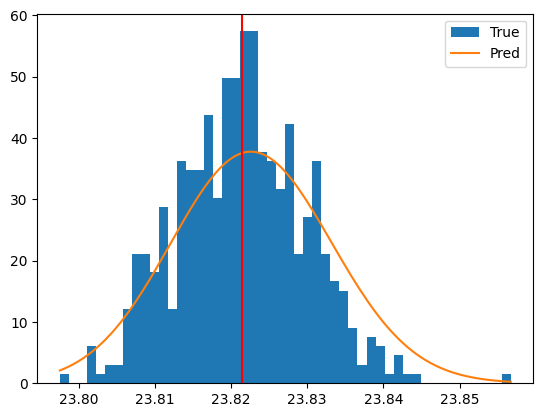

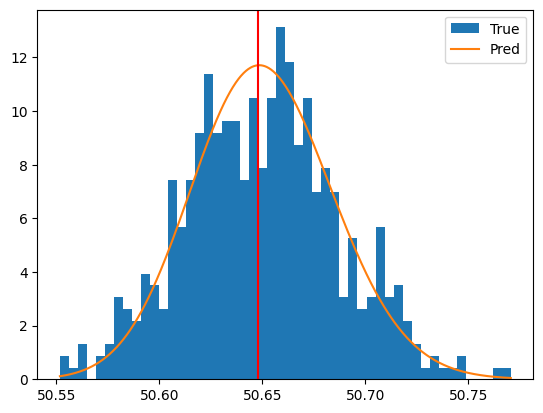

In [26]:
for p, t in zip(posteriors, true):

    plt.hist(p, bins=50, density=True, label='True')

    xx = jnp.linspace(p.min(), p.max(), 1_000)
    pred = jnp.exp(flow.log_prob(xx[:, None], jnp.array([t])))
    plt.plot(xx, pred, label='Pred')

    plt.axvline(t, c='r')

    plt.legend()
    plt.show()

In [25]:
cc = jnp.array([true[0]])

potential_fn = lambda xx: -flow.log_prob(xx, cc).squeeze()
nuts = numpyro.infer.NUTS(potential_fn=potential_fn)

mcmc = numpyro.infer.MCMC(
    sampler=nuts,
    num_warmup=1_000,
    num_samples=1_000,
    progress_bar=True,
    jit_model_args=True,
    )

key, key_ = jax.random.split(key)
mcmc.run(key_, init_params=jnp.ones(dim))
mcmc.print_summary()

sample: 100%|████████| 2000/2000 [00:02<00:00, 972.86it/s, 7 steps of size 8.30e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     32.80      0.02     32.80     32.77     32.82    475.22      1.00

Number of divergences: 0


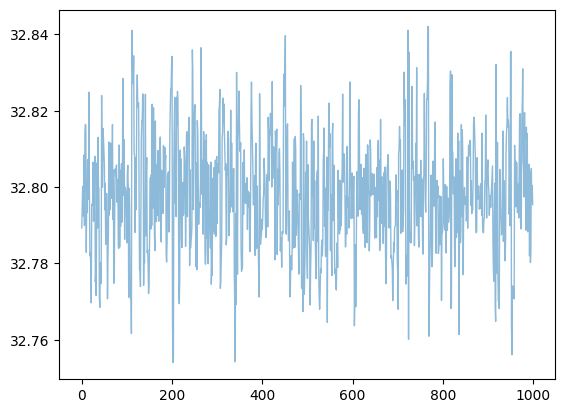

In [26]:
pred = mcmc.get_samples().squeeze()
plt.plot(pred, lw=1, alpha=0.5);

In [ ]:
bins = np.linspace(
    min(posteriors[0].min(), pred.min()),
    max(posteriors[0].max(), pred.max()),
    50,
    )
plt.hist(posteriors[0], bins=bins, density=True)
plt.hist(mcmc.get_samples().squeeze(), bins=bins, density=True, histtype='step');